## CLIF Table One

Author: Kaveri Chhikara
Date v1: September 8, 2025

This script identifies the cohort of encounters with at least one ICU stay and then summarizes the cohort data into one table. 


#### Requirements

* Required table filenames should be `clif_patient`, `clif_hospitalization`, `clif_adt`, `clif_vitals`, `clif_labs`, `clif_medication_admin_continuous`, `clif_respiratory_support`, `clif_patient_assessments`
* Within each table, the following variables and categories are required.

| Table Name | Required Variables | Required Categories |
| --- | --- | --- |
| **clif_patient** | `patient_id`, `race_category`, `ethnicity_category`, `sex_category`, `death_dttm` | - |
| **clif_hospitalization** | `patient_id`, `hospitalization_id`, `admission_dttm`, `discharge_dttm`,`discharge_dttm`, `age_at_admission` | - |
| **clif_adt** |  `hospitalization_id`, `hospital_id`,`in_dttm`, `out_dttm`, `location_category` | - |
| **clif_vitals** | `hospitalization_id`, `recorded_dttm`, `vital_category`, `vital_value` | weight_kg |
| **clif_labs** | `hospitalization_id`, `lab_result_dttm`, `lab_order_dttm`, `lab_category`, `lab_value_numeric` | creatinine, bilirubin_total, po2_arterial, platelet_count |
| **clif_medication_admin_continuous** | `hospitalization_id`, `admin_dttm`, `med_name`, `med_category`, `med_dose`, `med_dose_unit` | norepinephrine, epinephrine, phenylephrine, vasopressin, dopamine, angiotensin(optional) |
| **clif_respiratory_support** | `hospitalization_id`, `recorded_dttm`, `device_category`, `mode_category`,  `fio2_set`, `lpm_set`, `resp_rate_set`, `peep_set`, `resp_rate_obs`, `tidal_volume_set`, `pressure_control_set`, `pressure_support_set` | - |
| **clif_patient_assessments** | `hospitalization_id`, `recorded_dttm` , `assessment_category`, `numerical_value`| `gcs_total` |
| **clif_crrt_therapy** | `hospitalization_id`, `recorded_dttm` | - |


## Cohort Identification


## Inclusion 
1. Adults
2. Patients with at least one ICU stay or those who had only emergency department or ward encounters and either died or received life support at any point. Life support is defined as the administration of any vasoactive drugs or respiratory support exceeding low-flow oxygen.

Respiratory support device: 'IMV', 'NIPPV', 'CPAP', 'High Flow NC'  

Vasoactive: 'norepinephrine', 'epinephrine', 'phenylephrine', 'vasopressin',
    'dopamine', 'angiotensin'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
from pathlib import Path
import json
from typing import Union
from tqdm import tqdm
import csv
import sys
import clifpy
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import colorsys
import matplotlib.path
import matplotlib.patches
import matplotlib.patheffects
import polars as pl
print("=== Environment Verification ===")
print(f"Python executable: {sys.executable}")
print(f"Python version: {sys.version}")
print(f"clifpy version: {clifpy.__version__}")
print(f"clifpy location: {clifpy.__file__}")

print("\n=== Python Path Check ===")
local_clifpy_path = "/Users/kavenchhikara/Desktop/CLIF/CLIFpy"
if any(local_clifpy_path in path for path in sys.path):
    print("⚠️  WARNING: Local CLIFpy still in path!")
    for path in sys.path:
        if local_clifpy_path in path:
            print(f"   Found: {path}")
else:
    print("✅ Clean environment - no local CLIFpy in path")

print(f"\n=== Working Directory ===")
print(f"Current directory: {os.getcwd()}")

=== Environment Verification ===
Python executable: /Users/kavenchhikara/Projects/CLIF/CLIF-TableOne/.venv/bin/python
Python version: 3.11.11 (main, Feb 12 2025, 15:06:01) [Clang 19.1.6 ]
clifpy version: 0.2.4
clifpy location: /Users/kavenchhikara/Projects/CLIF/CLIF-TableOne/.venv/lib/python3.11/site-packages/clifpy/__init__.py

=== Python Path Check ===
✅ Clean environment - no local CLIFpy in path

=== Working Directory ===
Current directory: /Users/kavenchhikara/Projects/CLIF/CLIF-TableOne/code


In [2]:
# Load configuration
config_path = "../config/config.json"
with open(config_path, 'r') as f:
    config = json.load(f)

# Create the output directory for tableone results if it does not already exist
# Create necessary output directories within output/final
output_base_dir = Path("../output/final")
# Add all required subdirectories, including 'tableone/figures'
subdirs = [
    'tableone',
    'tableone/figures',
    'tableone/mcide',
    'tableone/summary_stats',
    'reports',
    'results',
    'clifpy'
]
for subdir in subdirs:
    dir_path = output_base_dir / subdir
    dir_path.mkdir(parents=True, exist_ok=True)
output_dir = output_base_dir / 'tableone'
mcide_dir = '../output/final/tableone/mcide'
clifpy_dir = '../output/final/clifpy'
summary_stats_dir = '../output/final/tableone/summary_stats'

print(f"\n=� Configuration:")
print(f"   Data directory: {config['tables_path']}")
print(f"   File type: {config['file_type']}")
print(f"   Timezone: {config['timezone']}")


=� Configuration:
   Data directory: /Users/kavenchhikara/Library/CloudStorage/Box-Box/RCLIF_data/CLIF_2018_24/WIP_2_1
   File type: parquet
   Timezone: US/Central


## Required columns and categories

In [3]:
print("\n" + "=" * 80)
print("Defining Required Data Elements")
print("=" * 80)

# Full patient table 

# Full hospitalization table 

# Full ADT table

# Vitals
vitals_required_columns = [
    'hospitalization_id',
    'recorded_dttm',
    'vital_category',
    'vital_value'
]
vitals_of_interest = ['heart_rate', 'respiratory_rate', 'sbp', 'dbp', 'map', 'spo2', 'weight_kg', 'height_cm']

# Respiratory Support 
rst_required_columns = [
    'hospitalization_id',
    'recorded_dttm',
    'device_name',
    'device_category',
    'mode_name', 
    'mode_category',
    'tracheostomy',
    'fio2_set',
    'lpm_set',
    'resp_rate_set',
    'peep_set',
    'resp_rate_obs',
    'tidal_volume_set', 
    'pressure_control_set',
    'pressure_support_set',
    'peak_inspiratory_pressure_set',
    'peak_inspiratory_pressure_obs',
    'plateau_pressure_obs',
    'minute_vent_obs'
]


# Continuous administered meds
meds_required_columns = [
    'hospitalization_id',
    'admin_dttm',
    'med_name',
    'med_category',
    'med_dose',
    'med_dose_unit'
]
meds_of_interest = [
    'norepinephrine', 'epinephrine', 'phenylephrine', 'vasopressin',
    'dopamine', 'angiotensin', 'dobutamine', 'milrinone', 'isoproterenol',
    'propofol', 'midazolam', 'lorazepam', 'dexmedetomidine', 
    'vecuronium', 'rocuronium', 'cisatracurium', 'pancuronium'
]


Defining Required Data Elements


In [4]:
strobe_counts = {}

## Functions

In [ ]:
def get_value_counts(clif_table, field_names, output_dir=None):
    """
    Get N (count) for all unique combinations of the specified fields from CLIF table.
    
    Parameters
    ----------
    clif_table : CLIF table object
        CLIF table object with .df attribute (e.g., clif.patient, clif.crrt_therapy).
    field_names : list of str
        List of field names to calculate count combinations for.
    output_dir : str, optional
        Directory path to save CSV file. If provided, saves summary CSV.
        Default is None (no files saved).
    
    Returns
    -------
    pd.DataFrame
        DataFrame with all unique combinations of field_names and a column 'N' with counts.

    Examples
    --------
    >>> result = get_value_counts(clif.patient, ['sex_name','sex_category'])
    >>> result = get_value_counts(clif.patient, ['race_name', 'race_category'], 
    ...                          output_dir='../output/final/tableone')
    """
    df = clif_table.df
    # Filter to only valid columns
    valid_fields = [field for field in field_names if field in df.columns]
    if not valid_fields:
        raise ValueError("None of the specified fields are in the DataFrame.")
        
    # Group by all specified fields and count
    combo_counts = (
        df.groupby(valid_fields, dropna=False)
          .size()
          .reset_index(name='N')
    )
    
    if output_dir:
        import os
        os.makedirs(output_dir, exist_ok=True)
        out_path = f"{output_dir}/{'_'.join(valid_fields)}_counts.csv"
        combo_counts.to_csv(out_path, index=False)
    
    return combo_counts

def create_summary_table(clif_table, numeric_cols, group_by_cols=None, output_dir=None):
    """
    Create summary statistics for numeric columns from CLIF table.
    
    Parameters
    ----------
    clif_table : CLIF table object
        CLIF table object with .df attribute.
    numeric_cols : str or list of str
        Column name(s) to summarize (e.g., 'fio2_set' or ['fio2_set', 'peep_set']).
    group_by_cols : str or list of str, optional
        Column name(s) to group by. If None, provides overall summary.
    output_dir : str, optional
        Directory path to save CSV. If provided, saves summary table.
        
    Returns
    -------
    pd.DataFrame
        Summary with columns: [group_cols (if any), 'variable', 'N', 'missing', 
        'min', 'q25', 'median', 'q75', 'mean', 'max'].
        
    Examples
    --------
    >>> summary = create_summary_table(clif.respiratory_support, 'fio2_set')
    >>> summary = create_summary_table(clif.respiratory_support, 
    ...                                ['fio2_set', 'peep_set'], 
    ...                                group_by_cols='device_category',
    ...                                output_dir='../output/final/tableone')
    """
    df = clif_table.df
    table_name = str(clif_table.labs).split('.')[-1].split()[0]
    if isinstance(numeric_cols, str):
        numeric_cols = [numeric_cols]
    if isinstance(group_by_cols, str):
        group_by_cols = [group_by_cols]
    
    summaries = []
    
    for col in numeric_cols:
        if col not in df.columns:
            continue
        
        agg_dict = {
            col: ['count', lambda x: x.isna().sum(), 'min', 
                  lambda x: x.quantile(0.25), lambda x: x.quantile(0.50),
                  lambda x: x.quantile(0.75), 'mean', 'max']
        }
        
        if group_by_cols:
            summary = df.groupby(group_by_cols).agg(agg_dict)
            summary.columns = summary.columns.droplevel(0)
            summary = summary.reset_index()
        else:
            summary = df.agg(agg_dict).to_frame().T
            summary.columns = summary.columns.droplevel(0)
        
        summary.columns = (list(group_by_cols) if group_by_cols else []) + \
                         ['N', 'missing', 'min', 'q25', 'median', 'q75', 'mean', 'max']
        summary.insert(len(group_by_cols) if group_by_cols else 0, 'variable', col)
        summaries.append(summary)
    
    result = pd.concat(summaries, ignore_index=True)
    
    if output_dir:
        filename = f"{table_name}_{'_'.join(group_by_cols) if group_by_cols else 'overall'}_summary.csv"
        result.to_csv(f"{output_dir}/{filename}", index=False)
    
    return result

In [6]:
def get_distinct_colors(n):
    """Generate n visually distinct colors."""
    hue_partition = 1 / (n + 1)
    colors = [colorsys.hsv_to_rgb(hue_partition * value, 0.8, 0.5)
              for value in range(0, n)]
    return reversed(colors[::2] + colors[1::2])


class Sankey:
    def __init__(self, df,
                 plot_width=8,
                 plot_height=8,
                 gap=0.12,
                 alpha=0.3,
                 fontsize='small',
                 order=None,
                 mapping=None,
                 tag=None,
                 title=None,
                 title_left=None,
                 title_right=None,
                 labels=True,
                 block_width=0.1,
                 block_fontsize=12,
                 flow_color_func=None,
                 colors=None,
                 ax=None
    ):
        self.df = df
        if ax:
            self.plot_width = ax.get_position().width * ax.figure.get_size_inches()[0]
            self.plot_height = ax.get_position().height * ax.figure.get_size_inches()[1]
        else:
            self.plot_width = plot_width
            self.plot_height = plot_height
        self.gap = gap
        self.block_width = block_width
        self.block_fontsize = block_fontsize
        self.alpha = alpha
        self.labels = labels
        self.fontsize = fontsize
        self.order = order
        self.flow_color_func = flow_color_func
        self.mapping_colors = {
            'increase': '#1f721c',
            'decrease': '#ddc90f',
            'mistake': '#dd1616',
            'correct': '#dddddd',
            'novel': '#59a8d6',
        }

        self.init_figure(ax)
        self.init_flows()
        self.init_nodes(order)
        self.init_widths()
        
        # inches per 1 item in x and y
        self.resolution = (plot_height - gap * (len(order) - 1)) / df.shape[0]
        
        if colors is not None:
            self.colors = colors
        else:
            self.colors = {
                name: colour
                for name, colour
                in zip(self.nodes[0].keys(),
                    get_distinct_colors(len(self.nodes[0])))
            }

        self.init_offsets()

    def init_figure(self, ax):
        if ax is None:
            self.fig = plt.figure()
            self.ax = plt.Axes(self.fig, [0, 0, 1, 1])
            self.fig.add_axes(self.ax)
        else:
            self.fig = ax.figure
            self.ax = ax

    def init_flows(self):
        self.flows = []
        n_cols = self.df.columns.size
        for i in range(n_cols - 1):
            x, y = self.df.iloc[:, i], self.df.iloc[:, i + 1]
            self.flows.append(collections.Counter(zip(x, y)))

    def init_nodes(self, order):
        self.nodes = []

        for i in range(self.df.columns.size):
            column = collections.OrderedDict()
            counts = self.df.iloc[:, i].value_counts()
            for item in order:
                if item in counts:
                    column[item] = counts[item]
                else:
                    column[item] = 0
            self.nodes.append(column)

    def init_widths(self):
        self.left_stop = self.block_width
        self.right_stop = self.plot_width - self.block_width
        self.stops = []
        n_cols = self.df.columns.size
        self.flow_width = (self.plot_width - self.block_width * (n_cols - 2)) / (n_cols - 1)

        for i in range(1, n_cols):
            stop1 = (self.block_width * i
                     + self.flow_width * (i - 1) + self.flow_width * 7 / 20)
            stop2 = (self.block_width * i
                     + self.flow_width * (i - 1) + self.flow_width * 13 / 20)
            self.stops.append((stop1, stop2))

    def init_offsets(self):
        self.offsets = []

        for col in self.nodes:
            offset = 0
            offsets = collections.OrderedDict()
            for name, size in col.items():
                offsets[name] = offset
                offset += size * self.resolution + self.gap
            self.offsets.append(offsets)

    def draw_flow(self, x, left, right, flow, node_offsets_l, node_offsets_r):
        P = matplotlib.path.Path

        left_y = self.offsets[x][left] + node_offsets_l[left]
        right_y = self.offsets[x + 1][right] + node_offsets_r[right]

        flow *= self.resolution

        node_offsets_l[left] += flow
        node_offsets_r[right] += flow
        
        if self.flow_color_func is not None:
            mapping = self.flow_color_func(left, right)
            color = self.mapping_colors[mapping]
        else:
            color = self.colors[left]

        left_x = self.flow_width * x + self.block_width * (x + 1)
        right_x  = left_x + self.flow_width

        path_data = [
            (P.MOVETO, (left_x, -left_y)),
            (P.LINETO, (left_x, -left_y - flow)),
            (P.CURVE4, (self.stops[x][0], -left_y - flow)),
            (P.CURVE4, (self.stops[x][1], -right_y - flow)),
            (P.CURVE4, (right_x, -right_y - flow)),
            (P.LINETO, (right_x, -right_y)),
            (P.CURVE4, (self.stops[x][1], -right_y)),
            (P.CURVE4, (self.stops[x][0], -left_y)),
            (P.CURVE4, (left_x, -left_y)),
            (P.CLOSEPOLY, (left_x, -left_y)),
        ]
        codes, verts = zip(*path_data)
        path = P(verts, codes)
        patch = matplotlib.patches.PathPatch(
            path,
            facecolor=color,
            alpha=0.9 if flow < .02 else self.alpha,
            edgecolor='none',
        )
        self.ax.add_patch(patch)

    def draw_node(self, x, y, size, name):
        if size <= 0:
            return
        y = -list(self.offsets[x].values())[y] - size * self.resolution
        x = self.flow_width * x + self.block_width * x
        color = self.colors[name]
        patch = matplotlib.patches.Rectangle(
            (x, y),
            width=self.block_width,
            height=size * self.resolution,
            facecolor=color,
            edgecolor='none',
        )
        self.ax.add_patch(patch)
        self.ax.text(
            x + self.block_width / 2,
            y + size * self.resolution / 2,
            name,
            color="black",
            va="center",
            ha="center",
            size=self.block_fontsize,
            path_effects=[
                matplotlib.patheffects.Stroke(linewidth=2, foreground="white"),
                matplotlib.patheffects.Normal()
            ]
        )

    def draw(self):
        for x, col in enumerate(self.nodes):
            for y, (name, size) in enumerate(col.items()):
                self.draw_node(x, y, size, name)

        for x, flows in enumerate(self.flows):
            node_offsets_l = collections.Counter()
            node_offsets_r = collections.Counter()

            for (left, right), flow in sorted(
                flows.items(),
                key=lambda x: (self.order.index(x[0][0]), self.order.index(x[0][1]))
            ):
                self.draw_flow(
                    x,
                    left,
                    right,
                    flow,
                    node_offsets_l,
                    node_offsets_r
                )

        self.ax.set_ylim(
            -self.resolution * self.df.shape[0] - self.gap * (len(self.order) - 1),
            0
        )
        self.ax.set_xlim(
            0,
            self.block_width * self.df.shape[1] + self.flow_width * (self.df.shape[1] - 1)
        )
        self.ax.get_xaxis().set_visible(False)
        self.ax.get_yaxis().set_visible(False)
        for k in self.ax.spines.keys():
            self.ax.spines[k].set_visible(False)


# ============================================================================
# Data Preparation Functions
# ============================================================================

def simplify_location_category(location):
    """Map location to simplified categories."""
    if pd.isna(location):
        return 'Other'
    
    location_lower = str(location).lower()
    
    if location_lower == 'icu':
        return 'ICU'
    elif location_lower == 'ward':
        return 'Ward'
    elif location_lower == 'ed':
        return 'ED'
    elif location_lower == 'procedural':
        return 'Procedural'
    else:
        return 'Other'


def create_outcome_df(final_tableone_df):
    """Create outcome dataframe with death indicator."""
    outcome_df = final_tableone_df[['encounter_block', 'death_enc', 'death_dttm', 'discharge_dttm']].copy()
    outcome_df['final_outcome_dttm'] = outcome_df['death_dttm'].fillna(outcome_df['discharge_dttm'])
    outcome_df = outcome_df[['encounter_block', 'death_enc', 'final_outcome_dttm']].drop_duplicates()
    return outcome_df


def prepare_sankey_wide_format(adt_cohort, encounter_blocks, outcome_df, max_locations=7):
    """
    Transform ADT data into wide format for Sankey diagram.
    Returns DataFrame where each row = encounter, each column = location position.
    """
    # Filter and sort
    adt_filtered = adt_cohort[adt_cohort['encounter_block'].isin(encounter_blocks)].copy()
    adt_filtered = adt_filtered.sort_values(['encounter_block', 'in_dttm'])
    
    # Simplify locations
    adt_filtered['location_simple'] = adt_filtered['location_category'].apply(simplify_location_category)
    
    # Add position/segment rank
    adt_filtered['segment_rank'] = adt_filtered.groupby('encounter_block').cumcount() + 1
    adt_filtered = adt_filtered[adt_filtered['segment_rank'] <= max_locations]
    
    # Pivot to wide format
    sankey_df = adt_filtered.pivot(
        index='encounter_block',
        columns='segment_rank',
        values='location_simple'
    ).reset_index()
    
    # Rename columns to float format (1.0, 2.0, etc.) to match example
    column_mapping = {col: float(col) for col in sankey_df.columns if col != 'encounter_block'}
    sankey_df = sankey_df.rename(columns=column_mapping)
    
    # Fill NaN with 'Discharged'
    location_cols = [float(i) for i in range(1, max_locations + 1)]
    for col in location_cols:
        if col not in sankey_df.columns:
            sankey_df[col] = 'Discharged'
        else:
            sankey_df[col] = sankey_df[col].fillna('Discharged')
    
    # Merge death information
    sankey_df = sankey_df.merge(
        outcome_df[['encounter_block', 'death_enc']], 
        on='encounter_block', 
        how='left'
    )
    
    return sankey_df, location_cols


def propagate_death(df, location_cols):
    """
    Propagate 'Died' status across all subsequent segments.
    Once a patient dies, all future segments show 'Died'.
    """
    def propagate_row(row):
        death_found = False
        for col in location_cols:
            if row[col] == 'Died':
                death_found = True
            if death_found:
                row[col] = 'Died'
        return row
    
    df[location_cols] = df[location_cols].apply(propagate_row, axis=1)
    return df


def mark_final_outcomes(df, location_cols):
    """
    Mark the final outcome for each encounter based on death_enc.
    """
    for idx, row in df.iterrows():
        # Find last actual location (not Discharged/Died)
        last_location_idx = None
        for i, col in enumerate(location_cols):
            if row[col] not in ['Discharged', 'Died']:
                last_location_idx = i
        
        if last_location_idx is not None:
            # Determine outcome
            if row['death_enc'] == 1:
                outcome = 'Died'
            else:
                outcome = 'Discharged'
            
            # Fill remaining positions with outcome
            for i in range(last_location_idx + 1, len(location_cols)):
                df.at[idx, location_cols[i]] = outcome
    
    return df


def create_sankey_diagram(adt_cohort, encounter_blocks, outcome_df, 
                         max_locations=7,
                         title="Patient Flow Through Locations",
                         output_file=None,
                         figsize=(16, 8)):
    """
    Create Sankey diagram using custom matplotlib Sankey class.
    """
    # Prepare data in wide format
    sankey_df, location_cols = prepare_sankey_wide_format(
        adt_cohort, encounter_blocks, outcome_df, max_locations
    )
    
    # Mark final outcomes based on death_enc
    sankey_df = mark_final_outcomes(sankey_df, location_cols)
    
    # Propagate death status through remaining positions
    sankey_df = propagate_death(sankey_df, location_cols)
    
    # Define colors (matching your preferences)
    # colors = {
    #     "ED": '#f08080',         # Light coral (red)
    #     "ICU": '#c9a0a0',        # Dusty rose
    #     "Ward": '#87ceeb',       # Sky blue
    #     'Procedural': '#d8bfd8', # Thistle (purple)
    #     "Other": '#d3d3d3',      # Light gray
    #     "Discharged": '#d3d3d3', # Light gray
    #     "Died": '#696969'        # Dim gray (dark)
    # }
    colors = {
            "ED": '#f08080',         # Light coral (keep)
            "ICU": '#87ceeb',        # Sky blue (SWAP with Ward!)
            "Ward": '#d4c5a0',       # Beige/tan (neutral, distinct)
            'Procedural': '#c9a0c9', # Light purple (but be careful)
            "Other": '#e8e8e8',      # Very light gray
            "Discharged": '#b8d4b8', # Light sage green
            "Died": '#696969'        # Dark gray (keep)
        }
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
    
    # Create Sankey diagram
    diag = Sankey(
        sankey_df[location_cols],
        ax=ax,
        order=["ED", "Ward", "ICU", "Procedural", "Other", "Discharged", "Died"],
        block_width=0.15,
        colors=colors,
        alpha=0.4,
        block_fontsize=10,
        gap=0.05  # Smaller gap between node types
    )
    diag.draw()
    
    # Set title
    ax.set_title(f"{title}\nN={len(encounter_blocks)} encounters", 
                 size=18, pad=20, fontweight='bold')
    
    # Set x-axis ticks for location numbers
    ax.set_xticks([
        diag.block_width / 2 + diag.flow_width * x + diag.block_width * x 
        for x in range(len(location_cols))
    ])
    ax.set_xticklabels([int(col) for col in location_cols])
    ax.set_xlabel("Location number", size=16, fontweight='bold')
    ax.get_xaxis().set_visible(True)
    ax.tick_params(axis="x", pad=10, labelsize=14)
    
    # Save if requested
    if output_file:
        fig.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"✅ Saved: {output_file}")
    
    plt.tight_layout()
    return fig, sankey_df

## Cohort identification

In [7]:
print("\n" + "=" * 80)
print("Loading CLIF Tables")
print("=" * 80)

from clifpy.clif_orchestrator import ClifOrchestrator

# Initialize ClifOrchestrator
clif = ClifOrchestrator(
    data_directory=config['tables_path'],
    filetype=config['file_type'],
    timezone=config['timezone'],
    output_directory='../output/final/clifpy'
)


Loading CLIF Tables
📢 ClifOrchestrator initialized


## Step0: Load Core Tables

In [8]:
# ============================================================================
# STEP 0: Load Core Tables (Patient, Hospitalization, ADT)
# ============================================================================
print("\n" + "=" * 80)
print("Step 0: Load Core Tables (Patient, Hospitalization, ADT)")
print("=" * 80)
core_tables = ['patient', 'hospitalization', 'adt']

print(f"\nLoading {len(core_tables)} core tables...")
for table_name in core_tables:
    print(f"   Loading {table_name}...", end=" ")
    try:
        clif.load_table(table_name)
        table = getattr(clif, table_name)
        print(f"✓ ({len(table.df):,} rows)")
    except Exception as e:
        print(f"✗ Error: {e}")
        raise

print("\nCore tables loaded successfully!")


Step 0: Load Core Tables (Patient, Hospitalization, ADT)

Loading 3 core tables...
   Loading patient... 📢 Initialized patient table
📢 Data directory: /Users/kavenchhikara/Library/CloudStorage/Box-Box/RCLIF_data/CLIF_2018_24/WIP_2_1
📢 File type: parquet
📢 Timezone: US/Central
📢 Output directory: ../output/final/clifpy
📢 Loaded schema from /Users/kavenchhikara/Projects/CLIF/CLIF-TableOne/.venv/lib/python3.11/site-packages/clifpy/schemas/patient_schema.yaml
📢 Loaded outlier configuration
✓ (97,254 rows)
   Loading hospitalization... 📢 Initialized hospitalization table
📢 Data directory: /Users/kavenchhikara/Library/CloudStorage/Box-Box/RCLIF_data/CLIF_2018_24/WIP_2_1
📢 File type: parquet
📢 Timezone: US/Central
📢 Output directory: ../output/final/clifpy
📢 Loaded schema from /Users/kavenchhikara/Projects/CLIF/CLIF-TableOne/.venv/lib/python3.11/site-packages/clifpy/schemas/hospitalization_schema.yaml
📢 Loaded outlier configuration
✓ (166,814 rows)
   Loading adt... 📢 Initialized adt table
📢

In [9]:
hosp_df = clif.hospitalization.df
adt_df = clif.adt.df

# Merge to get age information
all_encounters = pd.merge(
    hosp_df[["patient_id", "hospitalization_id", "admission_dttm", "discharge_dttm", 
             "age_at_admission", "discharge_category", "admission_type_category"]],
    adt_df[["hospitalization_id", "hospital_id", "in_dttm", "out_dttm", 
            "location_category", "location_type"]],
    on='hospitalization_id',
    how='inner'
)

In [10]:
get_value_counts(clif.adt, ['location_name', 'location_category'], output_dir=mcide_dir)
get_value_counts(clif.hospitalization, ['discharge_name', 'discharge_category'], output_dir=mcide_dir)
get_value_counts(clif.hospitalization, ['admission_type_name', 'admission_type_category'], output_dir=mcide_dir)
get_value_counts(clif.patient, ['race_name', 'race_category'], output_dir=mcide_dir)
get_value_counts(clif.patient, ['ethnicity_name', 'ethnicity_category'], output_dir=mcide_dir)

ethnicity_name ethnicity_category      N
0                                        Cuban           Hispanic      9
1                           Hispanic or Latino           Hispanic   3837
2      Mexican, Mexican American, or Chicano/a           Hispanic    691
3    Not Hispanic, Latino/a, or Spanish origin       Non-Hispanic  85841
4  Other Hispanic, Latino/a, or Spanish origin           Hispanic   1667
5                  Patient declines to respond            Unknown    975
6                                 Puerto Rican           Hispanic     51
7         Unknown or Patient unable to respond            Unknown   4032
8                                          NaN            Unknown    151

In [11]:
# Check for duplicates by ['hospitalization_id', 'in_dttm', 'out_dttm']
dup_counts = all_encounters.duplicated(subset=['hospitalization_id', 'in_dttm', 'out_dttm']).sum()
if dup_counts > 0:
    print(f"Warning: {dup_counts} duplicate (hospitalization_id, in_dttm, out_dttm) entries found in all_encounters.")
else:
    print("No duplicate (hospitalization_id, in_dttm, out_dttm) entries found in all_encounters.")

No duplicate (hospitalization_id, in_dttm, out_dttm) entries found in all_encounters.


## Step1: Date & Age filter

In [12]:
# ============================================================================
# STEP 1: Identify Adult Patients (Age >= 18) and Admissions 2018-2024
# ============================================================================
print("\n" + "=" * 80)
print("Step 1: Identifying Adult Patients (Age >= 18) and Admissions 2018-2024")
print("=" * 80)

print("Applying initial cohort filters...")

# Use only the relevant columns from all_encounters
adult_encounters = all_encounters[
    [
        'patient_id', 'hospitalization_id', 'admission_dttm', 'discharge_dttm',
        'age_at_admission', 'discharge_category', 'admission_type_category' ,'hospital_id',
        'in_dttm', 'out_dttm', 'location_category', 'location_type'
    ]
].copy()

if config['timezone'].lower() == "mimic":
    # MIMIC: only age >= 18, no admit year restriction
    adult_encounters = adult_encounters[
        (adult_encounters['age_at_admission'] >= 18) & (adult_encounters['age_at_admission'].notna())
    ]
else:
    # Other sites: age >= 18 and admission between 2018-2024 inclusive
    adult_encounters = adult_encounters[
        (adult_encounters['age_at_admission'] >= 18) &
        (adult_encounters['age_at_admission'].notna()) &
        (adult_encounters['admission_dttm'].dt.year >= 2018) &
        (adult_encounters['admission_dttm'].dt.year <= 2024)
    ]

print(f"\nFiltering Results:")
print(f"   Total hospitalizations: {len(all_encounters['hospitalization_id'].unique()):,}")
print(f"   Adult hospitalizations (age >= 18, 2018-2024): {len(adult_encounters['hospitalization_id'].unique()):,}")
print(f"   Excluded (age < 18 or outside 2018-2024): {len(all_encounters['hospitalization_id'].unique()) - len(adult_encounters['hospitalization_id'].unique()):,}")


strobe_counts["0_total_hospitalizations"] = len(all_encounters['hospitalization_id'].unique())
strobe_counts["1_adult_hospitalizations"] = len(adult_encounters['hospitalization_id'].unique())
# Get list of adult hospitalization IDs for filtering
adult_hosp_ids = set(adult_encounters['hospitalization_id'].unique())
print(f"\n   Unique adult hospitalization IDs: {len(adult_hosp_ids):,}")


Step 1: Identifying Adult Patients (Age >= 18) and Admissions 2018-2024
Applying initial cohort filters...

Filtering Results:
   Total hospitalizations: 166,781
   Adult hospitalizations (age >= 18, 2018-2024): 166,781
   Excluded (age < 18 or outside 2018-2024): 0

   Unique adult hospitalization IDs: 166,781


### Stitch hospitalizations 

If the `id_col` supplied by user is `hospitalization_id`, then we combine multiple `hospitalization_ids` into a single `encounter_block` for patients who transfer between hospital campuses or return soon after discharge. Hospitalizations that have a gap of **6 hours or less** between the discharge dttm and admission dttm are put in one encounter block.

If the `id_col` supplied by user is `hospitalization_joined_id` from the hospitalization table, then we consider the user has already stitched similar encounters, and we will consider that as the primary id column for all table joins moving forward.

In [13]:
from clifpy.utils.stitching_encounters import stitch_encounters

# stitch hospitalizations
hosp_filtered = clif.hospitalization.df[clif.hospitalization.df['hospitalization_id'].isin(adult_hosp_ids)]
adt_filtered = clif.adt.df[clif.adt.df['hospitalization_id'].isin(adult_hosp_ids)]

hosp_stitched, adt_stitched, encounter_mapping = stitch_encounters(
    hospitalization=hosp_filtered,
    adt=adt_filtered,
    time_interval=6  
)

# Direct assignment without additional copies
clif.hospitalization.df = hosp_stitched
clif.adt.df = adt_stitched

# Store the encounter mapping in the orchestrator for later use
clif.encounter_mapping = encounter_mapping

# Clean up intermediate variables
del hosp_filtered, adt_filtered
gc.collect()

0

In [14]:
# After your stitching code, add these calculations:

# Calculate stitching statistics
strobe_counts['1b_before_stitching'] = len(adult_hosp_ids)  # Original adult hospitalizations
strobe_counts['1b_after_stitching'] = len(hosp_stitched['encounter_block'].unique())  # Unique encounter blocks after stitching
strobe_counts['1b_stitched_hosp_ids'] = strobe_counts['1b_before_stitching'] - strobe_counts['1b_after_stitching']  # Number of hospitalizations that were linked

print(f"\nEncounter Stitching Results:")
print(f"   Number of unique hospitalizations before stitching: {strobe_counts['1b_before_stitching']:,}")
print(f"   Number of unique encounter blocks after stitching: {strobe_counts['1b_after_stitching']:,}")
print(f"   Number of linked hospitalization ids: {strobe_counts['1b_stitched_hosp_ids']:,}")

# Optional: Show the encounter mapping details
print(f"\nEncounter Mapping Details:")
print(f"   Total encounter mappings created: {len(encounter_mapping):,}")
if len(encounter_mapping) > 0:
    # Show some examples of how many original hospitalizations were combined
    mapping_counts = encounter_mapping.groupby('encounter_block').size()
    print(f"   Encounter blocks with multiple hospitalizations: {(mapping_counts > 1).sum():,}")
    print(f"   Maximum hospitalizations combined into one block: {mapping_counts.max()}")


Encounter Stitching Results:
   Number of unique hospitalizations before stitching: 166,781
   Number of unique encounter blocks after stitching: 166,644
   Number of linked hospitalization ids: 137

Encounter Mapping Details:
   Total encounter mappings created: 166,781
   Encounter blocks with multiple hospitalizations: 136
   Maximum hospitalizations combined into one block: 3


# ADT

In [15]:
# Merge all_encounters with encounter_mapping to get encounter_block information
all_encounters = pd.merge(all_encounters, encounter_mapping, on='hospitalization_id', how='left')

# Convert location_category and discharge_category to lowercase in place (vectorized)
all_encounters['location_category'] = all_encounters['location_category'].str.lower()
all_encounters['discharge_category'] = all_encounters['discharge_category'].str.lower()
all_encounters['admission_type_category'] = all_encounters['admission_type_category'].str.lower()

# Create vectorized ICU and death masks
icu_mask = all_encounters['location_category'].str.contains('icu', na=False)
death_mask = all_encounters['discharge_category'].isin(['expired', 'hospice'])

# Vectorized: For each encounter_block, does any row have ICU or death? (much faster)
# Use groupby('encounter_block')[mask].transform('any') to vectorize
all_encounters['icu_enc'] = icu_mask.groupby(all_encounters['encounter_block']).transform('any').astype(int)
all_encounters['death_enc'] = death_mask.groupby(all_encounters['encounter_block']).transform('any').astype(int)

# Cohort flag using logical OR (vectorized)
all_encounters['cohort_enc'] = (all_encounters['icu_enc'] | all_encounters['death_enc']).astype(int)

# Store hospitalization_ids for cohort_enc==1 in a list (as before)
cohort_enc_hospitalization_ids = all_encounters.loc[all_encounters['cohort_enc'] == 1, 'hospitalization_id'].unique().tolist()

In [16]:
# Identify encounters where death occurred
death_encounters = all_encounters[all_encounters['death_enc'] == 1]
# Identify those that never touched the ICU
non_icu_deaths = death_encounters[~death_encounters['icu_enc'].astype(bool)]
# Count the number of unique encounters with deaths outside of ICU
num_deaths_outside_icu = non_icu_deaths['encounter_block'].nunique()
# Calculate total deaths (unique encounter blocks with death)
total_encounters = all_encounters['encounter_block'].nunique()
# Calculate the percentage
pct_deaths_outside_icu = (num_deaths_outside_icu / total_encounters * 100) if total_encounters > 0 else 0
print(f"Number of deaths outside ICU: {num_deaths_outside_icu} ({pct_deaths_outside_icu:.1f}% of all hospitalizations)")

# Add ICU encounters to strobe counts as 1_icu_encounters
num_icu_encounters = all_encounters[all_encounters['icu_enc'] == 1]['encounter_block'].nunique()
if 'strobe_counts' not in globals():
    strobe_counts = {}
strobe_counts['1_icu_encounters'] = num_icu_encounters

Number of deaths outside ICU: 2600 (1.6% of all hospitalizations)


In [17]:
final_cohort = all_encounters[
    all_encounters['hospitalization_id'].isin(cohort_enc_hospitalization_ids)
][['encounter_block', 'icu_enc', 'death_enc', 'cohort_enc']].drop_duplicates()

# Respiratory Support

In [18]:
# ============================================================================
# STEP 2: Load Respiratory Support and Identify Patients on Advanced Respiratory support 
# ============================================================================
print("\n" + "=" * 80)
print(" Loading Respiratory Support and Identifying IMV Patients")
print("=" * 80)

print(f"\nLoading respiratory_support table...")
clif.load_table('respiratory_support',
                        columns=rst_required_columns,
                        filters={'hospitalization_id': list(adult_hosp_ids)})
print(f"Respiratory support loaded ({len(clif.respiratory_support.df):,} rows)")

get_value_counts(clif.respiratory_support, ['device_name', 'device_category'], output_dir=mcide_dir)
get_value_counts(clif.respiratory_support, ['mode_name', 'mode_category'], output_dir=mcide_dir)
get_value_counts(clif.respiratory_support, ['device_name', 'device_category', 'mode_name', 'mode_category'], output_dir=mcide_dir)

# Standardize category columns to lowercase
print(f"\nStandardizing category columns...")
category_cols = [col for col in clif.respiratory_support.df.columns if col.endswith('_category')]
for col in category_cols:
    clif.respiratory_support.df[col] = clif.respiratory_support.df[col].str.lower()




 Loading Respiratory Support and Identifying IMV Patients

Loading respiratory_support table...
📢 Initialized respiratory_support table
📢 Data directory: /Users/kavenchhikara/Library/CloudStorage/Box-Box/RCLIF_data/CLIF_2018_24/WIP_2_1
📢 File type: parquet
📢 Timezone: US/Central
📢 Output directory: ../output/final/clifpy
📢 Loaded schema from /Users/kavenchhikara/Projects/CLIF/CLIF-TableOne/.venv/lib/python3.11/site-packages/clifpy/schemas/respiratory_support_schema.yaml
📢 Loaded outlier configuration
Respiratory support loaded (6,973,889 rows)

Standardizing category columns...


In [19]:
# Identify hospitalizations on advanced mechanical support
print(f"\nIdentifying hospitalizations with advanced respiratory support devices...")
device_types = ['imv', 'nippv', 'cpap', 'high flow nc']
clif.respiratory_support.df = pd.merge(clif.respiratory_support.df, encounter_mapping, 
                                        on='hospitalization_id', how='left')
advanced_support_hosp_ids = clif.respiratory_support.df.loc[
    clif.respiratory_support.df['device_category'].str.lower().isin([d.lower() for d in device_types]),
    'encounter_block'
].unique()
print(f"Hospitalizations with any advanced resp. device ({', '.join(device_types).upper()}): {len(advanced_support_hosp_ids):,}")
strobe_counts["2_advanced_resp_support_hospitalizations"] = len(advanced_support_hosp_ids)


Identifying hospitalizations with advanced respiratory support devices...
Hospitalizations with any advanced resp. device (IMV, NIPPV, CPAP, HIGH FLOW NC): 30,596


In [20]:
# Create a DataFrame with advanced_support_hosp_ids and 'high_support_en' == 1
advanced_support_df = pd.DataFrame({
    'encounter_block': advanced_support_hosp_ids,
    'high_support_enc': 1
})

In [21]:
# Perform a full join (outer merge) of final_cohort and advanced_support_df on 'encounter_block'
final_cohort = final_cohort.merge(
    advanced_support_df,
    on='encounter_block',
    how='outer'
)

# Vasoactives

In [22]:
print(f"\nLoading medication_admin_continuous table...")
clif.load_table(
    'medication_admin_continuous',
    columns=meds_required_columns,
    filters={
        'hospitalization_id': list(adult_hosp_ids),
        'med_category': meds_of_interest
    }
)


Loading medication_admin_continuous table...
📢 Initialized medication_admin_continuous table
📢 Data directory: /Users/kavenchhikara/Library/CloudStorage/Box-Box/RCLIF_data/CLIF_2018_24/WIP_2_1
📢 File type: parquet
📢 Timezone: US/Central
📢 Output directory: ../output/final/clifpy
📢 Loaded schema from /Users/kavenchhikara/Projects/CLIF/CLIF-TableOne/.venv/lib/python3.11/site-packages/clifpy/schemas/medication_admin_continuous_schema.yaml
📢 Loaded outlier configuration


In [23]:
# Identify hospitalizations on advanced mechanical support
print(f"\nIdentifying hospitalizations with advanced respiratory support devices...")
vasoactive_meds = ['norepinephrine', 'epinephrine', 'phenylephrine', 'vasopressin','dopamine', 'angiotensin']
clif.medication_admin_continuous.df= pd.merge(clif.medication_admin_continuous.df, encounter_mapping, 
                                        on='hospitalization_id', how='left')
vasoactive_hosp_ids = clif.medication_admin_continuous.df.loc[
    clif.medication_admin_continuous.df['med_category'].str.lower().isin([d.lower() for d in vasoactive_meds]),
    'encounter_block'
].unique()
print(f"Hospitalizations with any vasoactives. device ({', '.join(vasoactive_meds).upper()}): {len(vasoactive_hosp_ids):,}")
strobe_counts["3_vasoactive_hospitalizations"] = len(vasoactive_hosp_ids)


Identifying hospitalizations with advanced respiratory support devices...
Hospitalizations with any vasoactives. device (NOREPINEPHRINE, EPINEPHRINE, PHENYLEPHRINE, VASOPRESSIN, DOPAMINE, ANGIOTENSIN): 25,190


In [24]:
# Create a DataFrame with advanced_support_hosp_ids and 'high_support_en' == 1
vasoactives_df = pd.DataFrame({
    'encounter_block': vasoactive_hosp_ids,
    'vaso_support_enc': 1
})

In [25]:
# Join vasoactives_df with final cohort on hospitalization_id
final_cohort = final_cohort.merge(
    vasoactives_df,
    on='encounter_block',
    how='outer'
)

In [26]:
# Missing high_support_en means not on advanced support
final_cohort['vaso_support_enc'] = final_cohort['vaso_support_enc'].fillna(0).astype(int)
# Missing high_support_en means not on advanced support
final_cohort['high_support_enc'] = final_cohort['high_support_enc'].fillna(0).astype(int)
# Missing icu_enc means not ICU
final_cohort['icu_enc'] = final_cohort['icu_enc'].fillna(0).astype(int)
# Define the criteria for other critically ill
final_cohort['other_critically_ill'] = (
    (final_cohort[['icu_enc', 'vaso_support_enc', 'high_support_enc']].sum(axis=1) == 0)
).astype(int)
# Calculate the count
strobe_counts['4_other_critically_ill'] = final_cohort.loc[final_cohort['other_critically_ill'] == 1, 
                                                            'encounter_block'].nunique()
strobe_counts['5_all_critically_ill'] = final_cohort['encounter_block'].nunique()

# Summary

In [27]:
import pandas as pd
strobe_counts_df = pd.DataFrame(list(strobe_counts.items()), columns=['count_name', 'count_value'])
strobe_counts_df.to_csv('../output/final/tableone/strobe_counts.csv', index=False)
# Calculate mortality rates
mortality_rates = {
    'ICU Hospitalizations': final_cohort.loc[final_cohort['icu_enc'] == 1, 'death_enc'].mean() * 100,
    'Advanced Respiratory Support': final_cohort.loc[final_cohort['high_support_enc'] == 1, 'death_enc'].mean() * 100,
    'Vasoactive Hospitalizations': final_cohort.loc[final_cohort['vaso_support_enc'] == 1, 'death_enc'].mean() * 100,
    'Other Critically Ill': final_cohort.loc[final_cohort['other_critically_ill'] == 1, 'death_enc'].mean() * 100,
    'All Critically Ill Adults': final_cohort['death_enc'].mean() * 100,
}
mortality_rates_df = pd.DataFrame(list(mortality_rates.items()), columns=['count_name', 'count_value'])
mortality_rates_df.to_csv('../output/final/tableone/mortality_rates.csv', index=False)

In [28]:
cohort_df = encounter_mapping.copy()
cohort_df = cohort_df[cohort_df['encounter_block'].isin(final_cohort['encounter_block'])]

# Merge cohort_df with all_encounters on hospitalization_id
cohort_df = cohort_df.merge(
    all_encounters,
    on=['hospitalization_id', 'encounter_block'],
    how='left',
    suffixes=('', '_allenc')
)

In [29]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

def create_consort_diagram(strobe_counts, mortality_rates):
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    ax.set_xlim(-1, 13)
    ax.set_ylim(0, 14)
    ax.axis('off')

    box_style = "round,pad=0.1"
    boxes = {}

    def create_box(x, y, width, height, text, box_id=None, fontsize=10, fontweight='normal'):
        box = FancyBboxPatch(
            (x - width/2, y - height/2), width, height,
            boxstyle=box_style, facecolor='white', edgecolor='black', linewidth=1.5
        )
        ax.add_patch(box)
        ax.text(x, y, text, ha='center', va='center', fontsize=fontsize, fontweight=fontweight, wrap=True)
        
        return {
            'x': x, 'y': y, 'width': width, 'height': height,
            'left': x - width/2, 'right': x + width/2,
            'top': y + height/2, 'bottom': y - height/2
        }

    def create_arrow(from_box, to_box):
        x1, y1 = from_box['x'], from_box['bottom'] - 0.1
        x2, y2 = to_box['x'], to_box['top'] + 0.1
        ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                    arrowprops=dict(arrowstyle='->', lw=2, color='black'))

    ax.text(5, 13, 'Cohort', ha='center', va='center', fontsize=16, fontweight='bold')

    # Define and arrange the boxes
    box1 = create_box(5, 12, 3, 0.7, 
                      f"Total Hospitalizations\nn = {strobe_counts['0_total_hospitalizations']:,}",
                      'total', fontsize=11, fontweight='bold')

    box2 = create_box(5, 10.5, 3, 0.7,
                      f"Stitched Adult Hospitalizations\nn = {strobe_counts['1b_after_stitching']:,}",
                      'adult', fontsize=11, fontweight='bold')
    create_arrow(box1, box2)

    # Define ICU, respiratory support, vasoactive, and other critically ill categories
    box3_icu = create_box(1, 8, 3, 0.9,
                          f"ICU Hospitalizations\nn = {strobe_counts['1_icu_encounters']:,}\nMortality: {mortality_rates['ICU Hospitalizations']:.2f}%",
                          'icu', fontsize=11, fontweight='bold')

    box3_resp = create_box(4.5, 8, 3, 0.9,
                           f"Advanced Respiratory Support\nn = {strobe_counts['2_advanced_resp_support_hospitalizations']:,}\nMortality: {mortality_rates['Advanced Respiratory Support']:.2f}%",
                           'resp_support', fontsize=11, fontweight='bold')

    box3_vaso = create_box(8, 8, 3, 0.9,
                           f"Vasoactive Hospitalizations\nn = {strobe_counts['3_vasoactive_hospitalizations']:,}\nMortality: {mortality_rates['Vasoactive Hospitalizations']:.2f}%",
                           'vasoactive', fontsize=11, fontweight='bold')

    box3_other = create_box(11.3, 8, 3, 0.9,
                            f"Other Critically Ill\nn = {strobe_counts['4_other_critically_ill']:,}\nMortality: {mortality_rates['Other Critically Ill']:.2f}%",
                            'other', fontsize=11, fontweight='bold')

    create_arrow(box2, box3_icu)
    create_arrow(box2, box3_resp)
    create_arrow(box2, box3_vaso)
    create_arrow(box2, box3_other)

    # Add a final box for "All Critically Ill Adults"
    box_final = create_box(5.7, 4.5, 5.2, 1.1,
        f"All Critically Ill Adults\nn = {final_cohort['encounter_block'].nunique():,}\nMortality: {mortality_rates['All Critically Ill Adults']:.2f}%",
        'all_critically_ill', fontsize=13, fontweight='bold')

    # Do NOT draw arrows from the four groups to the all critically ill adults box

    plt.tight_layout()
    plt.savefig('../output/final/tableone/consort_flow_diagram.png', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()

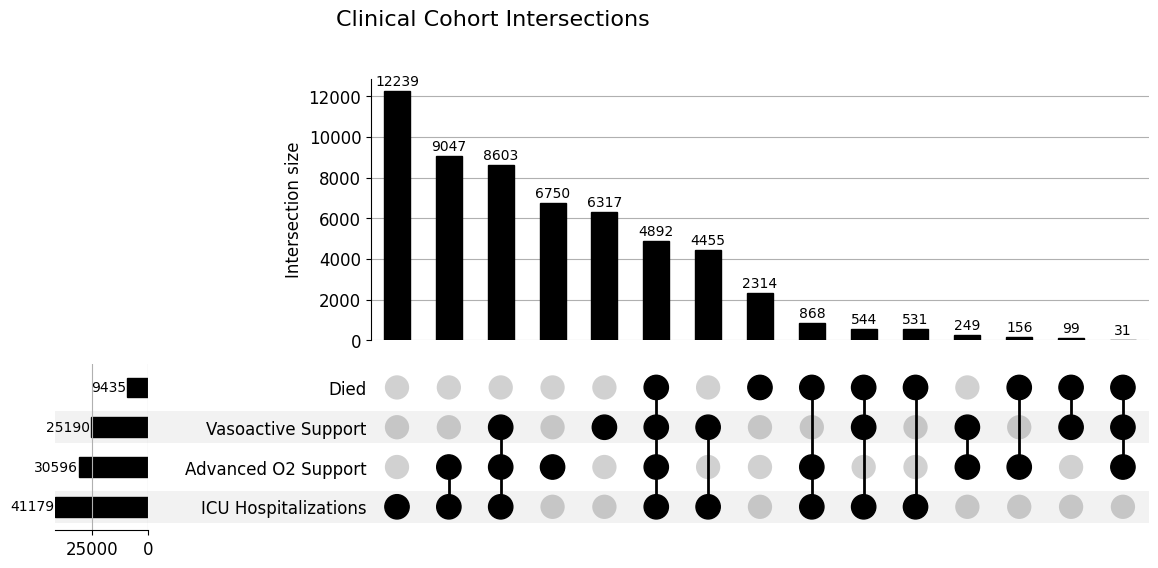


Generating 4-way Venn Diagram


<Figure size 1200x1000 with 0 Axes>

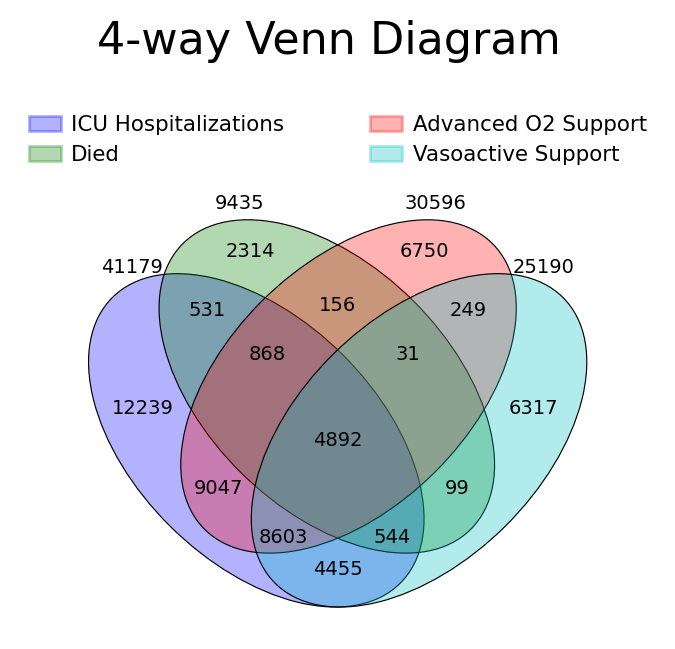

✅ Saved: ../output/final/tableone/venn_all_4_groups.png


In [30]:
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_indicators
import os
import pandas as pd

import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='upsetplot')

# Create output directory if it doesn't exist
os.makedirs('../output/final/tableone', exist_ok=True)

# Prepare final_cohort data for UpSet and venn plots
summary_df = final_cohort[['encounter_block', 'icu_enc', 'death_enc', 'high_support_enc', 'vaso_support_enc']].drop_duplicates()

# Rename columns
summary_df = summary_df.rename(columns={
    'icu_enc': 'ICU Hospitalizations',
    'death_enc': 'Died',
    'high_support_enc': 'Advanced O2 Support',
    'vaso_support_enc': 'Vasoactive Support'
})

# Convert to boolean for UpSet and venn
summary_df['ICU Hospitalizations'] = summary_df['ICU Hospitalizations'].fillna(0).astype(bool)
summary_df['Died'] = summary_df['Died'].fillna(0).astype(bool)
summary_df['Advanced O2 Support'] = summary_df['Advanced O2 Support'].fillna(0).astype(bool)
summary_df['Vasoactive Support'] = summary_df['Vasoactive Support'].fillna(0).astype(bool)
summary_df.to_csv('../output/final/tableone/upset_data.csv', index=False)

# ========== UpSet Plot ==========
fig = plt.figure(figsize=(16, 12))
upset_data = from_indicators(
    ['ICU Hospitalizations', 'Died', 'Advanced O2 Support', 'Vasoactive Support'], 
    data=summary_df.set_index('encounter_block')
)

upset = UpSet(upset_data, 
              subset_size='count',
              show_counts=True,
              sort_by='cardinality',
              element_size=50,
              with_lines=True)

upset.plot(fig=fig)

plt.subplots_adjust(left=0.2, bottom=0.2, right=0.95, top=0.85, hspace=0.3, wspace=0.3)
plt.suptitle('Clinical Cohort Intersections', fontsize=16, y=0.95)

# Adjust font sizes for better readability
for ax in fig.get_axes():
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)

plt.savefig('../output/final/tableone/cohort_intersect_upset_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# ========== Venn Diagrams ==========

# ========== 4-way Venn with venny4py ==========
print("\n" + "="*80)
print("Generating 4-way Venn Diagram")
print("="*80)

# Create dictionary of sets for venny4py
sets_dict = {
    'ICU Hospitalizations': set(summary_df.loc[summary_df['ICU Hospitalizations'], 'encounter_block']),
    'Died': set(summary_df.loc[summary_df['Died'], 'encounter_block']),
    'Advanced O2 Support': set(summary_df.loc[summary_df['Advanced O2 Support'], 'encounter_block']),
    'Vasoactive Support': set(summary_df.loc[summary_df['Vasoactive Support'], 'encounter_block'])
}

# Create 4-way Venn diagram
fig = plt.figure(figsize=(12, 10))
from venny4py.venny4py import venny4py
venny4py(sets=sets_dict, dpi=300)
plt.suptitle('4-way Venn Diagram', fontsize=16, y=0.98)
plt.savefig('../output/final/tableone/venn_all_4_groups.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: ../output/final/tableone/venn_all_4_groups.png")

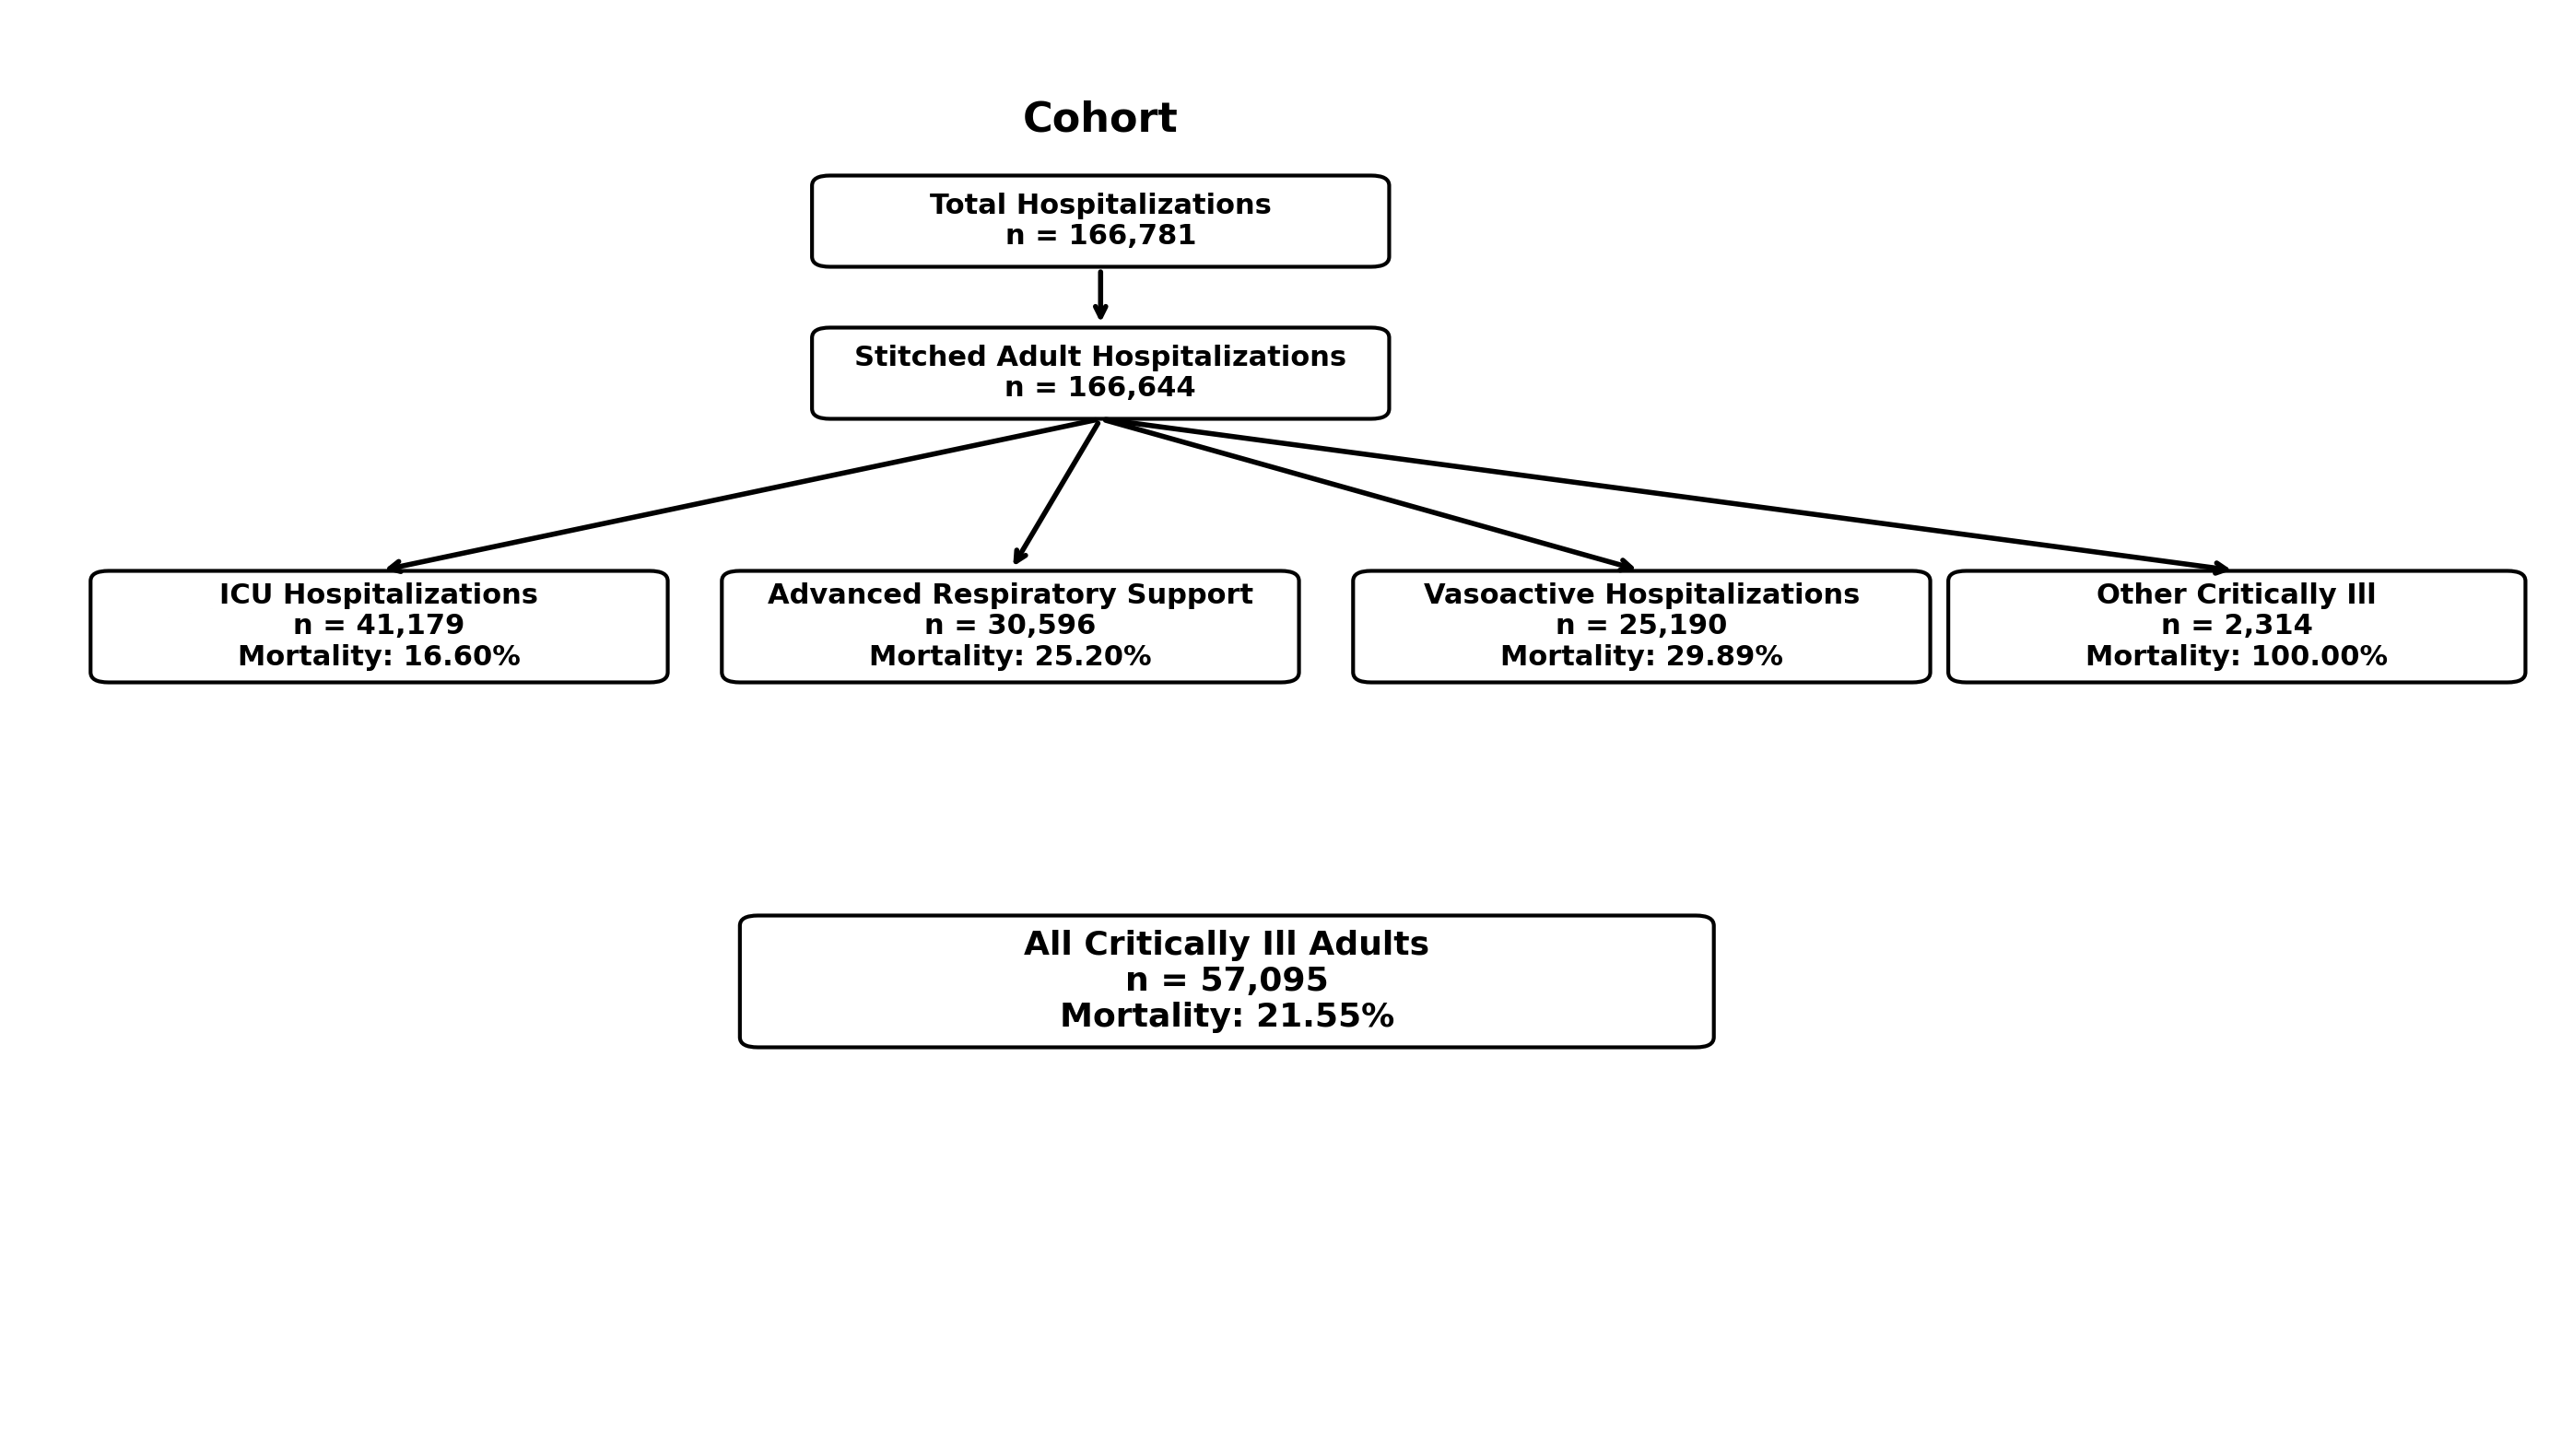

In [31]:
# Create the diagram
create_consort_diagram(strobe_counts, mortality_rates)

# Demographics

In [32]:
# 1. Filter patient table to cohort
patient_df = clif.patient.df.copy()
patient_df = patient_df[['patient_id', 'race_category', 'ethnicity_category',
                         'sex_category', 'death_dttm']]

# Filter patient_df to those in cohort
patient_df = patient_df[patient_df['patient_id'].isin(cohort_df['patient_id'])]
# Merge patient_df with cohort_df on patient_id
cohort_df = patient_df.merge(cohort_df, on='patient_id', how='right')

# Final cohort df

In [ ]:
final_tableone_df = cohort_df[['patient_id', 'hospitalization_id', 'encounter_block', 'admission_dttm', 
                                'discharge_dttm', 'age_at_admission', 'discharge_category', 'admission_type_category',
                                'race_category', 'ethnicity_category', 'sex_category', 'death_dttm', 
                                'icu_enc', 'death_enc', 'cohort_enc']].drop_duplicates()

final_tableone_df = final_tableone_df.merge(
    final_cohort[['encounter_block','high_support_enc', 'vaso_support_enc', 'other_critically_ill']],
    on = 'encounter_block',
    how="outer"
)

# Merge hospital_id onto final_tableone_df by hospitalization_id
final_tableone_df = final_tableone_df.merge(
    cohort_df[['hospitalization_id', 'hospital_id']].drop_duplicates(),
    on='hospitalization_id',
    how='left'
)

adt_cohort = cohort_df[['patient_id', 'hospitalization_id', 'encounter_block',
                       'hospital_id', 'in_dttm', 'out_dttm', 'location_category',
                       'location_type']].drop_duplicates()

In [34]:
final_hosp_ids = final_tableone_df['hospitalization_id'].unique().tolist()
final_patient_ids = final_tableone_df['patient_id'].unique().tolist()
final_enc_blocks = final_tableone_df['encounter_block'].unique().tolist()

# Cohort Group Sankey


CREATING MATPLOTLIB SANKEY DIAGRAMS
✅ Saved: ../output/final/tableone/figures/sankey_matplotlib_icu.png


/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_52347/3100514747.py:425: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


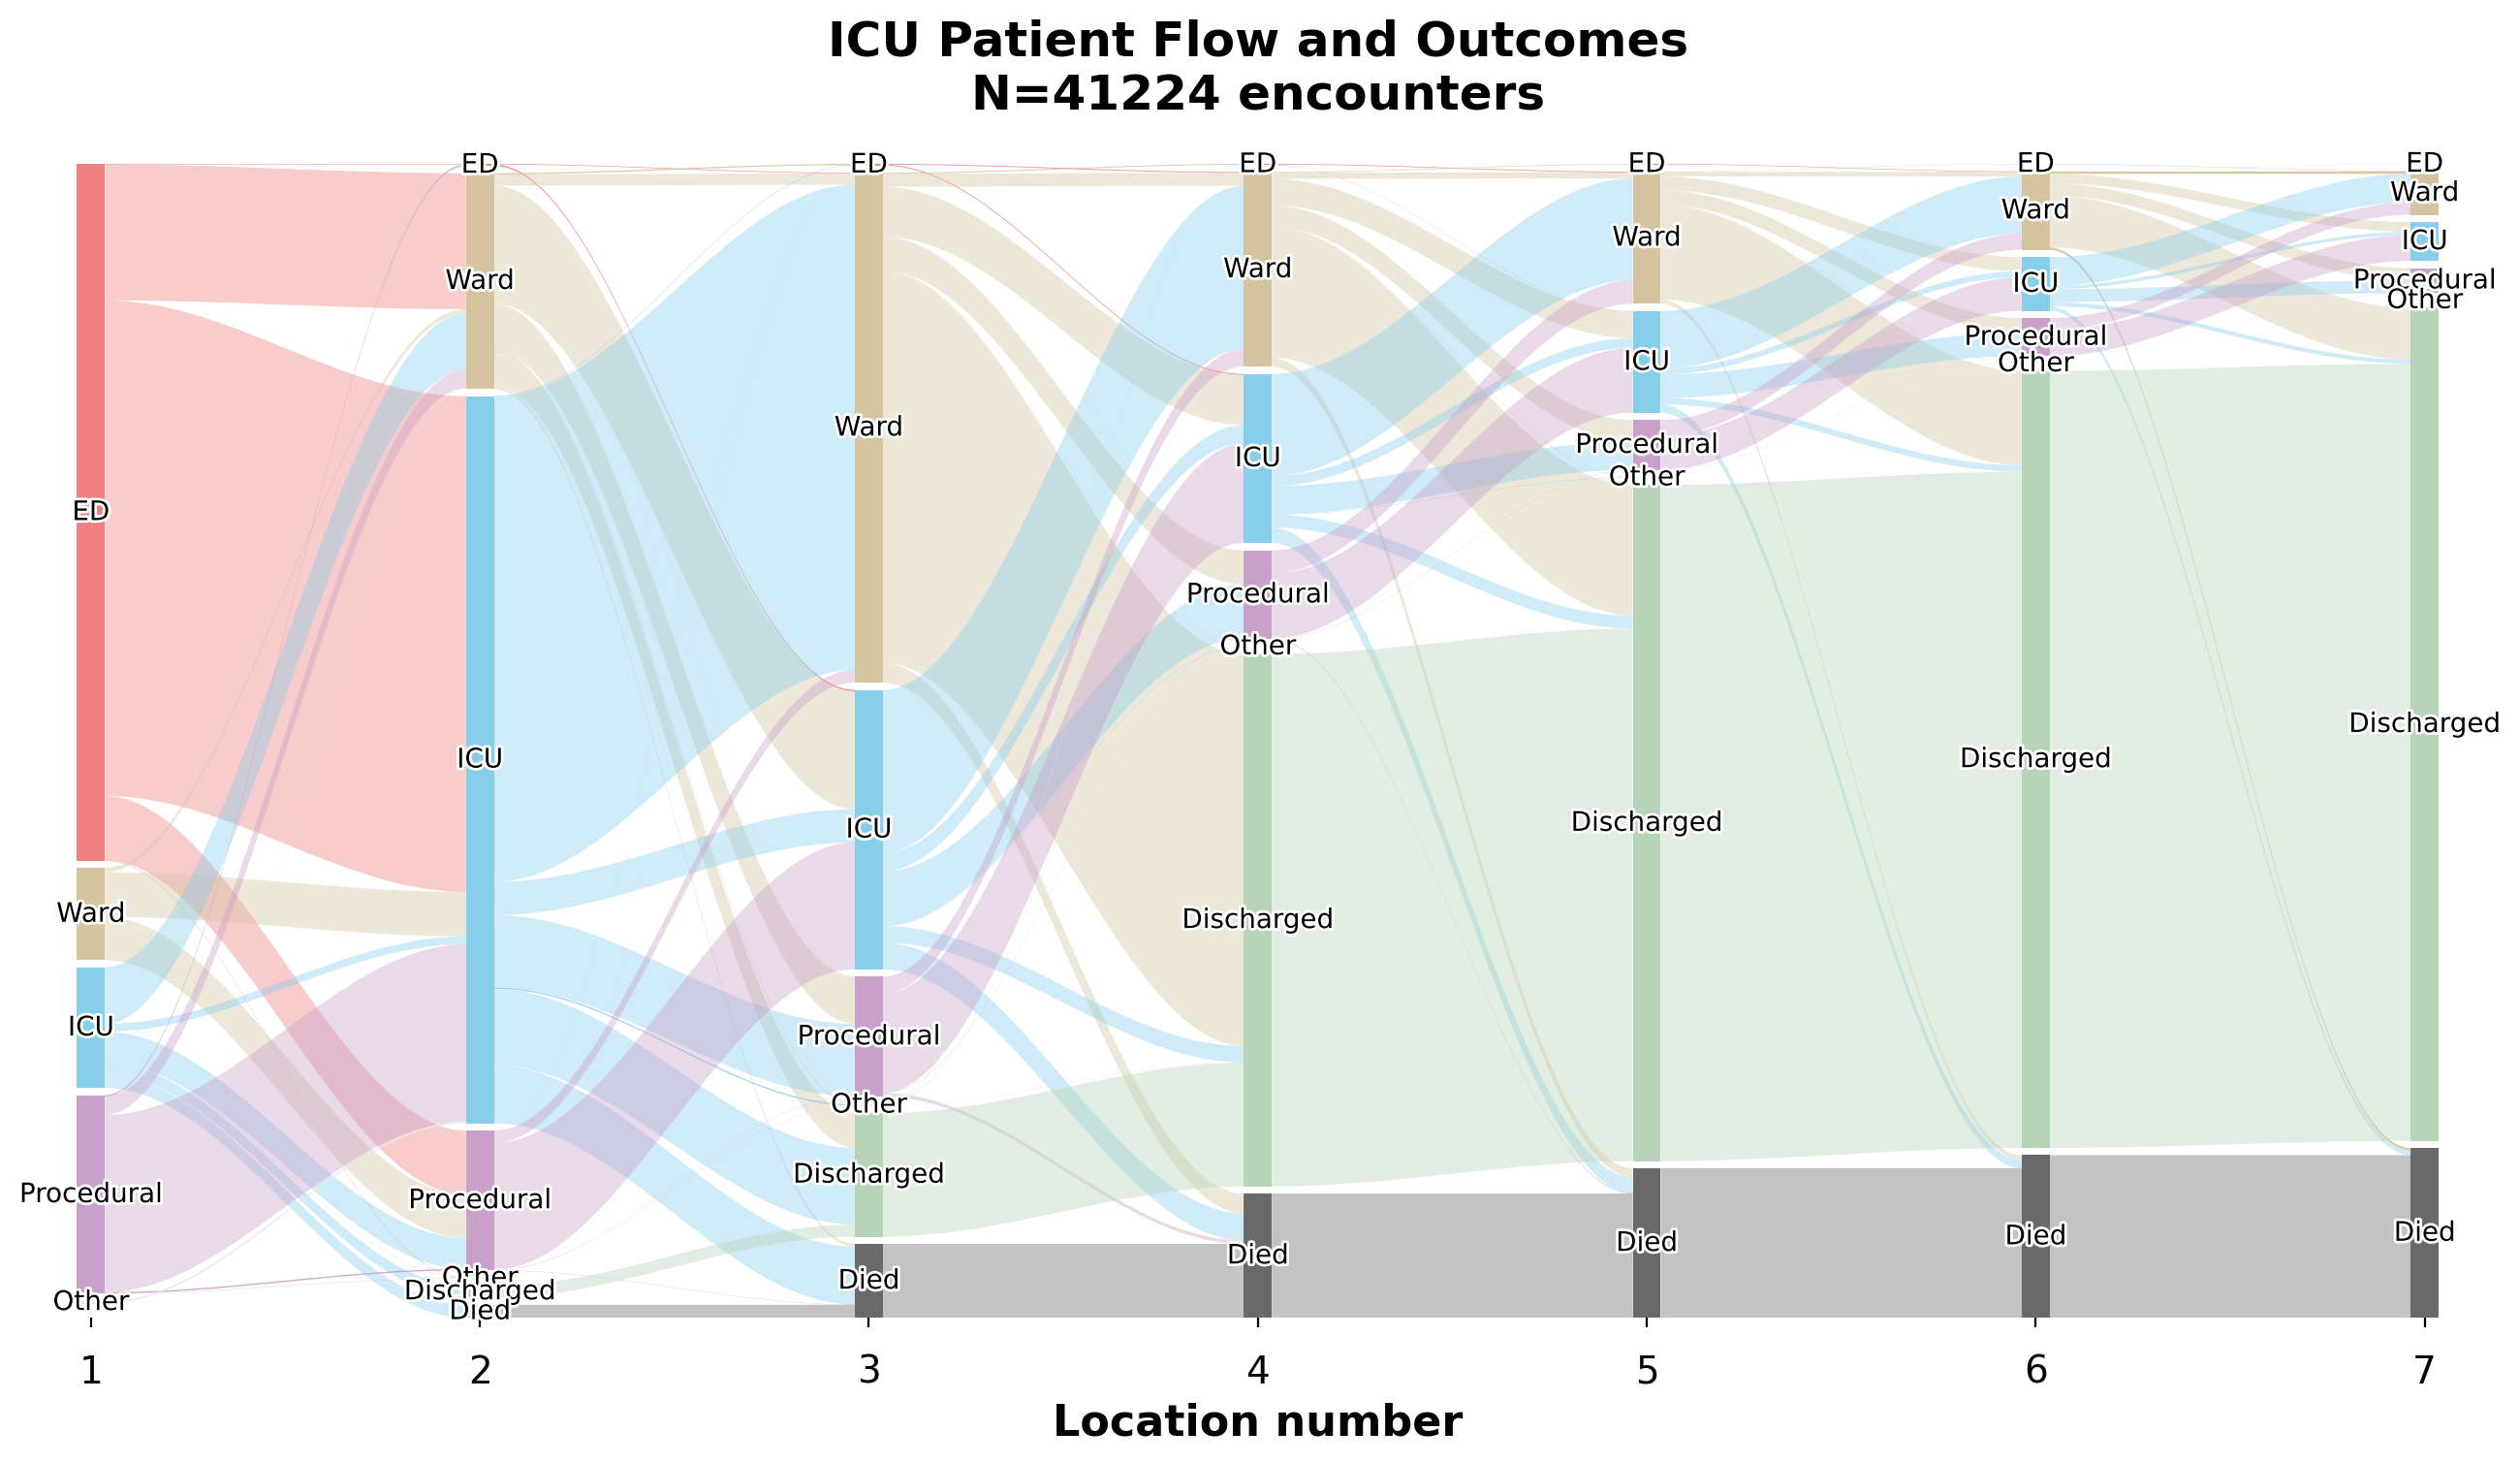

In [35]:
outcome_df = create_outcome_df(final_tableone_df)

print("\n" + "="*80)
print("CREATING MATPLOTLIB SANKEY DIAGRAMS")
print("="*80)

# Example 1: ICU encounters
# icu_blocks = final_tableone_df[final_tableone_df['icu_enc'] == 1]['encounter_block'].sample(
#     min(300, final_tableone_df[final_tableone_df['icu_enc'] == 1].shape[0]), 
#     random_state=42
# ).tolist()
# fig1, df1 = create_sankey_diagram(
#     adt_cohort=adt_cohort,
#     encounter_blocks=icu_blocks,
#     outcome_df=outcome_df,
#     max_locations=7,
#     title="ICU Patient Flow and Outcomes (Sample 300 encounters)",
#     output_file=f"{output_dir}/figures/sankey_matplotlib_icu.png",
#     figsize=(16, 8)
# )
# plt.show()
icu_blocks_all = final_tableone_df[final_tableone_df['icu_enc'] == 1]['encounter_block'].tolist()
fig1, df1 = create_sankey_diagram(
    adt_cohort=adt_cohort,
    encounter_blocks=icu_blocks_all,
    outcome_df=outcome_df,
    max_locations=7,
    title="ICU Patient Flow and Outcomes",
    output_file=f"{output_dir}/figures/sankey_matplotlib_icu.png",
    figsize=(16, 8)
)
plt.show()



 Other critically ill  (N=2317)
✅ Saved: ../output/final/tableone/figures/sankey_matplotlib_others.png


/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_52347/3100514747.py:425: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


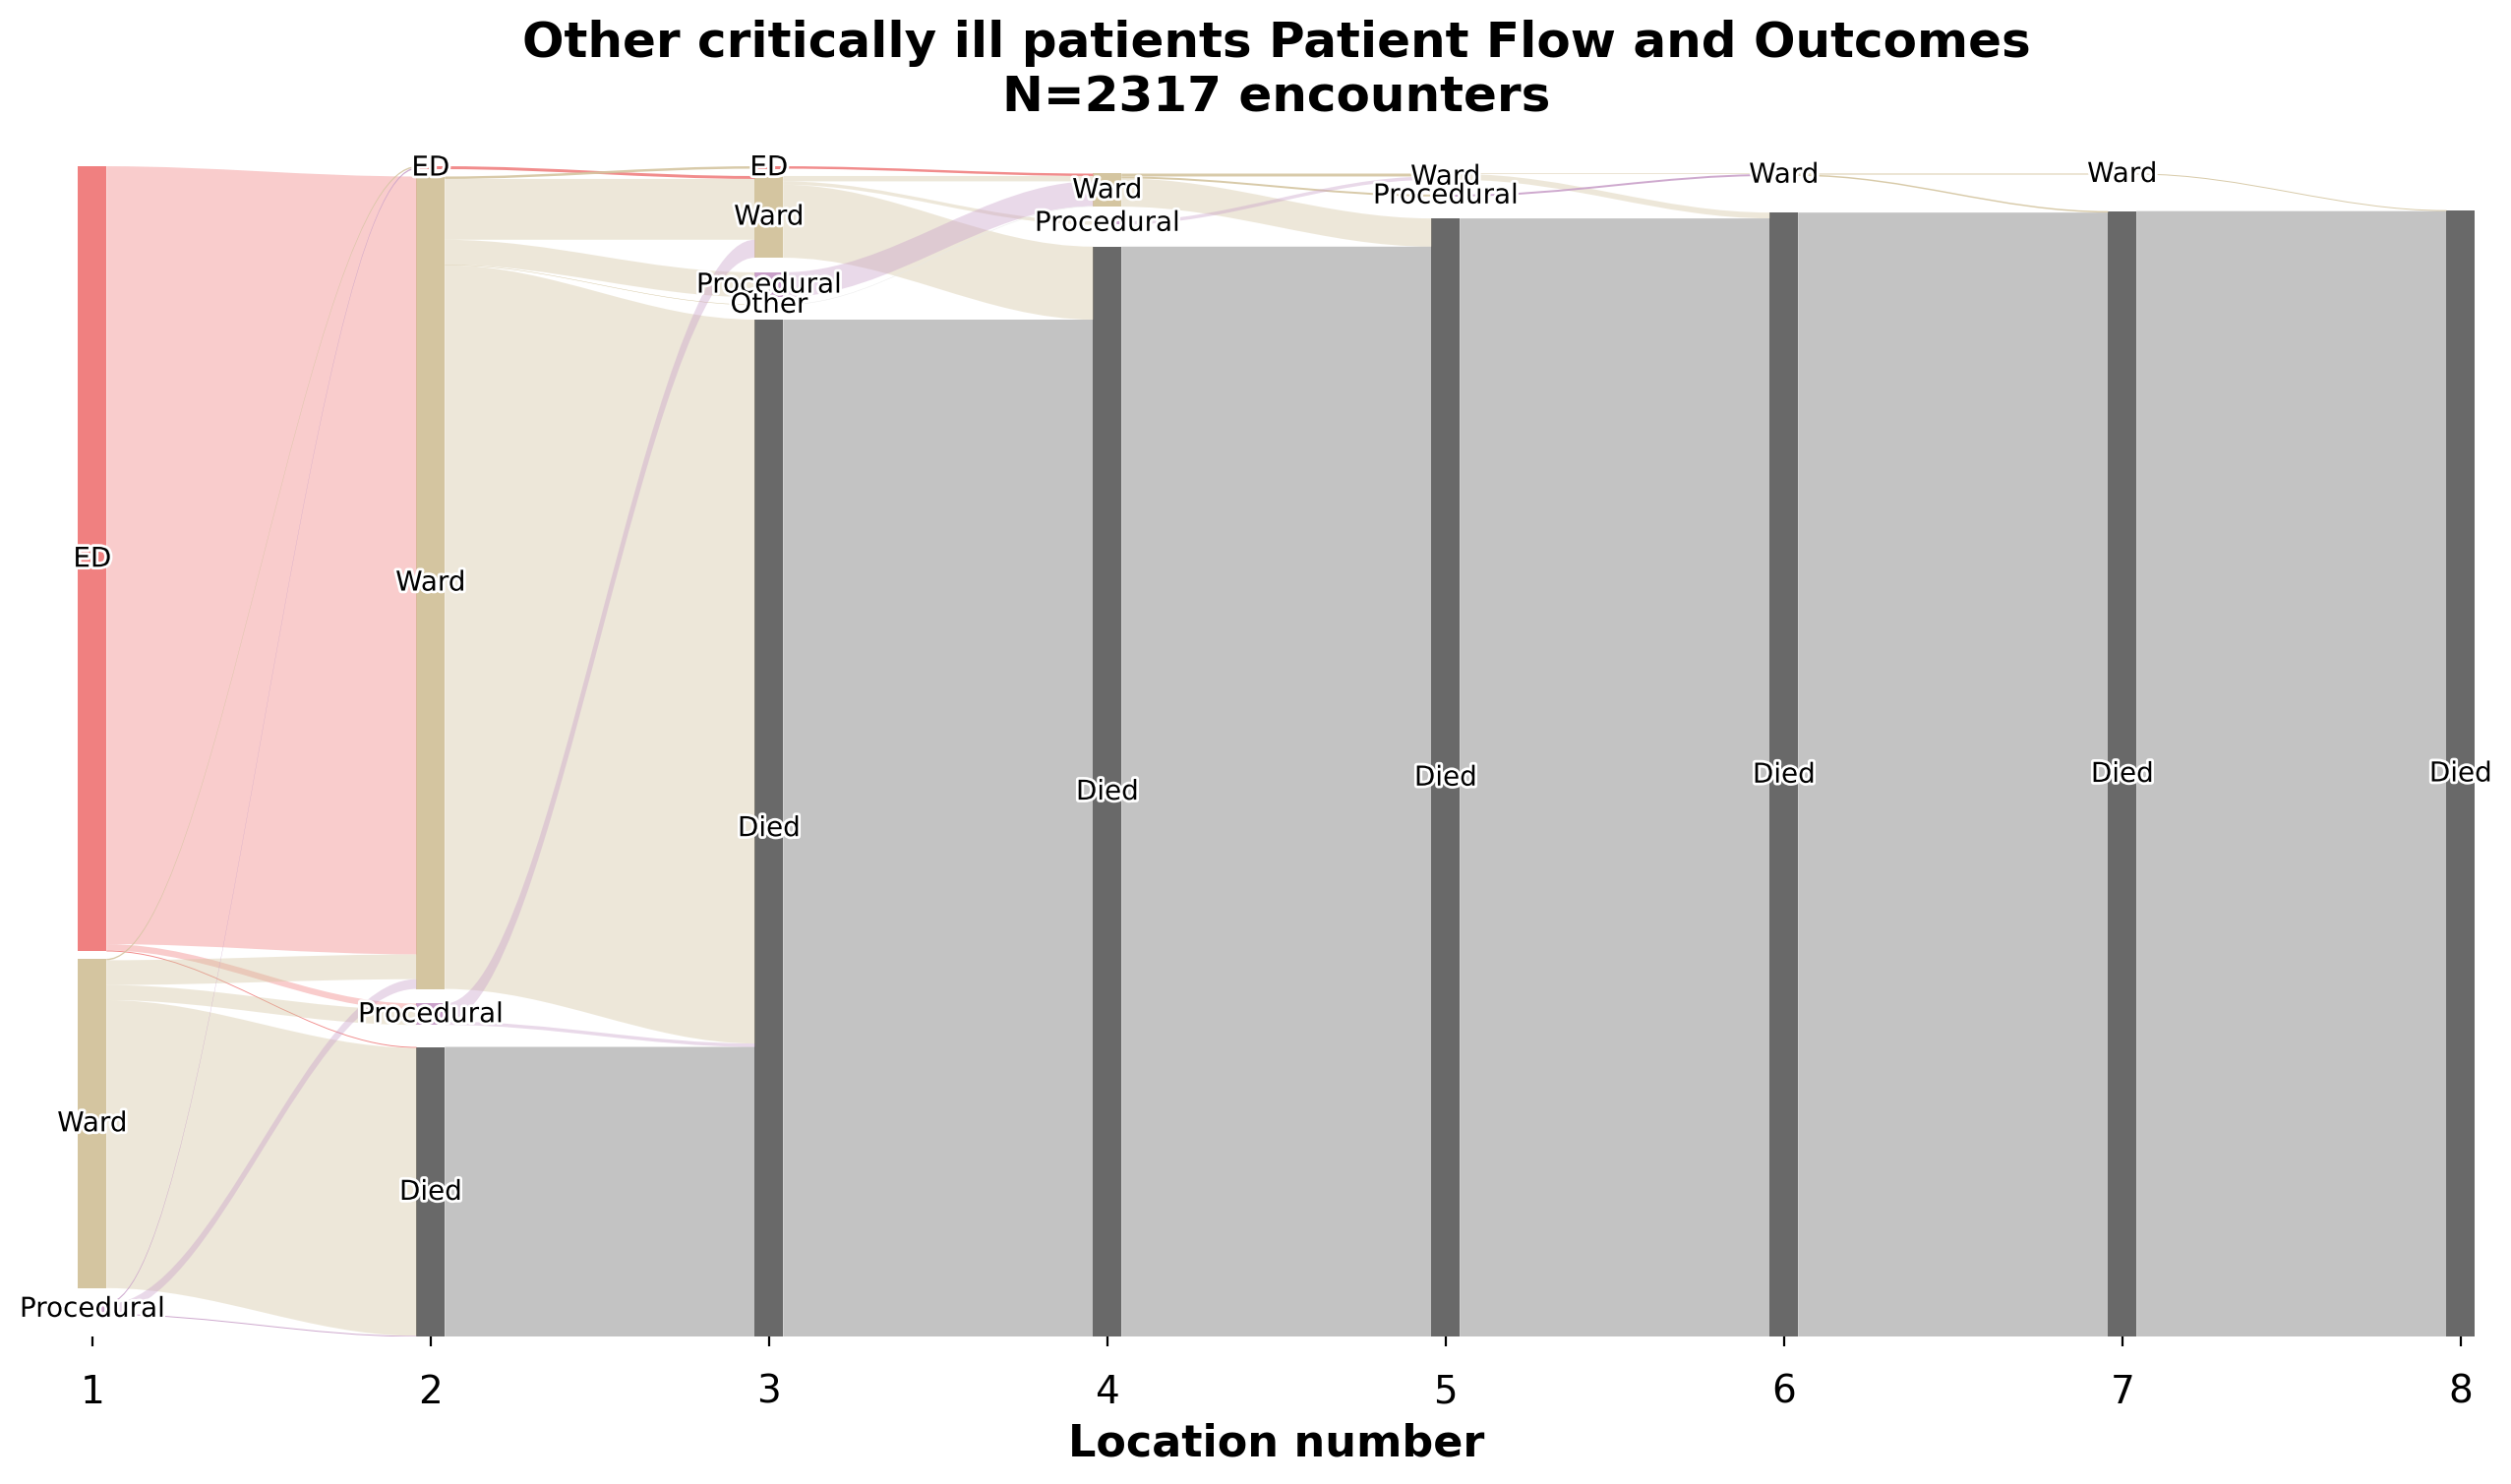

In [36]:
# other critically ill
other_enc = final_tableone_df[final_tableone_df['other_critically_ill'] == 1]['encounter_block'].tolist()

print(f"\n Other critically ill  (N={len(other_enc)})")
fig1, df1 = create_sankey_diagram(
    adt_cohort=adt_cohort,
    encounter_blocks=other_enc,
    outcome_df=outcome_df,
    max_locations=8,
    title="Other critically ill patients Patient Flow and Outcomes",
    output_file=f"{output_dir}/figures/sankey_matplotlib_others.png",
    figsize=(16, 8)
)
plt.show()

✅ Saved: ../output/final/tableone/figures/sankey_matplotlib_high_o2_support.png


/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_52347/3100514747.py:425: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


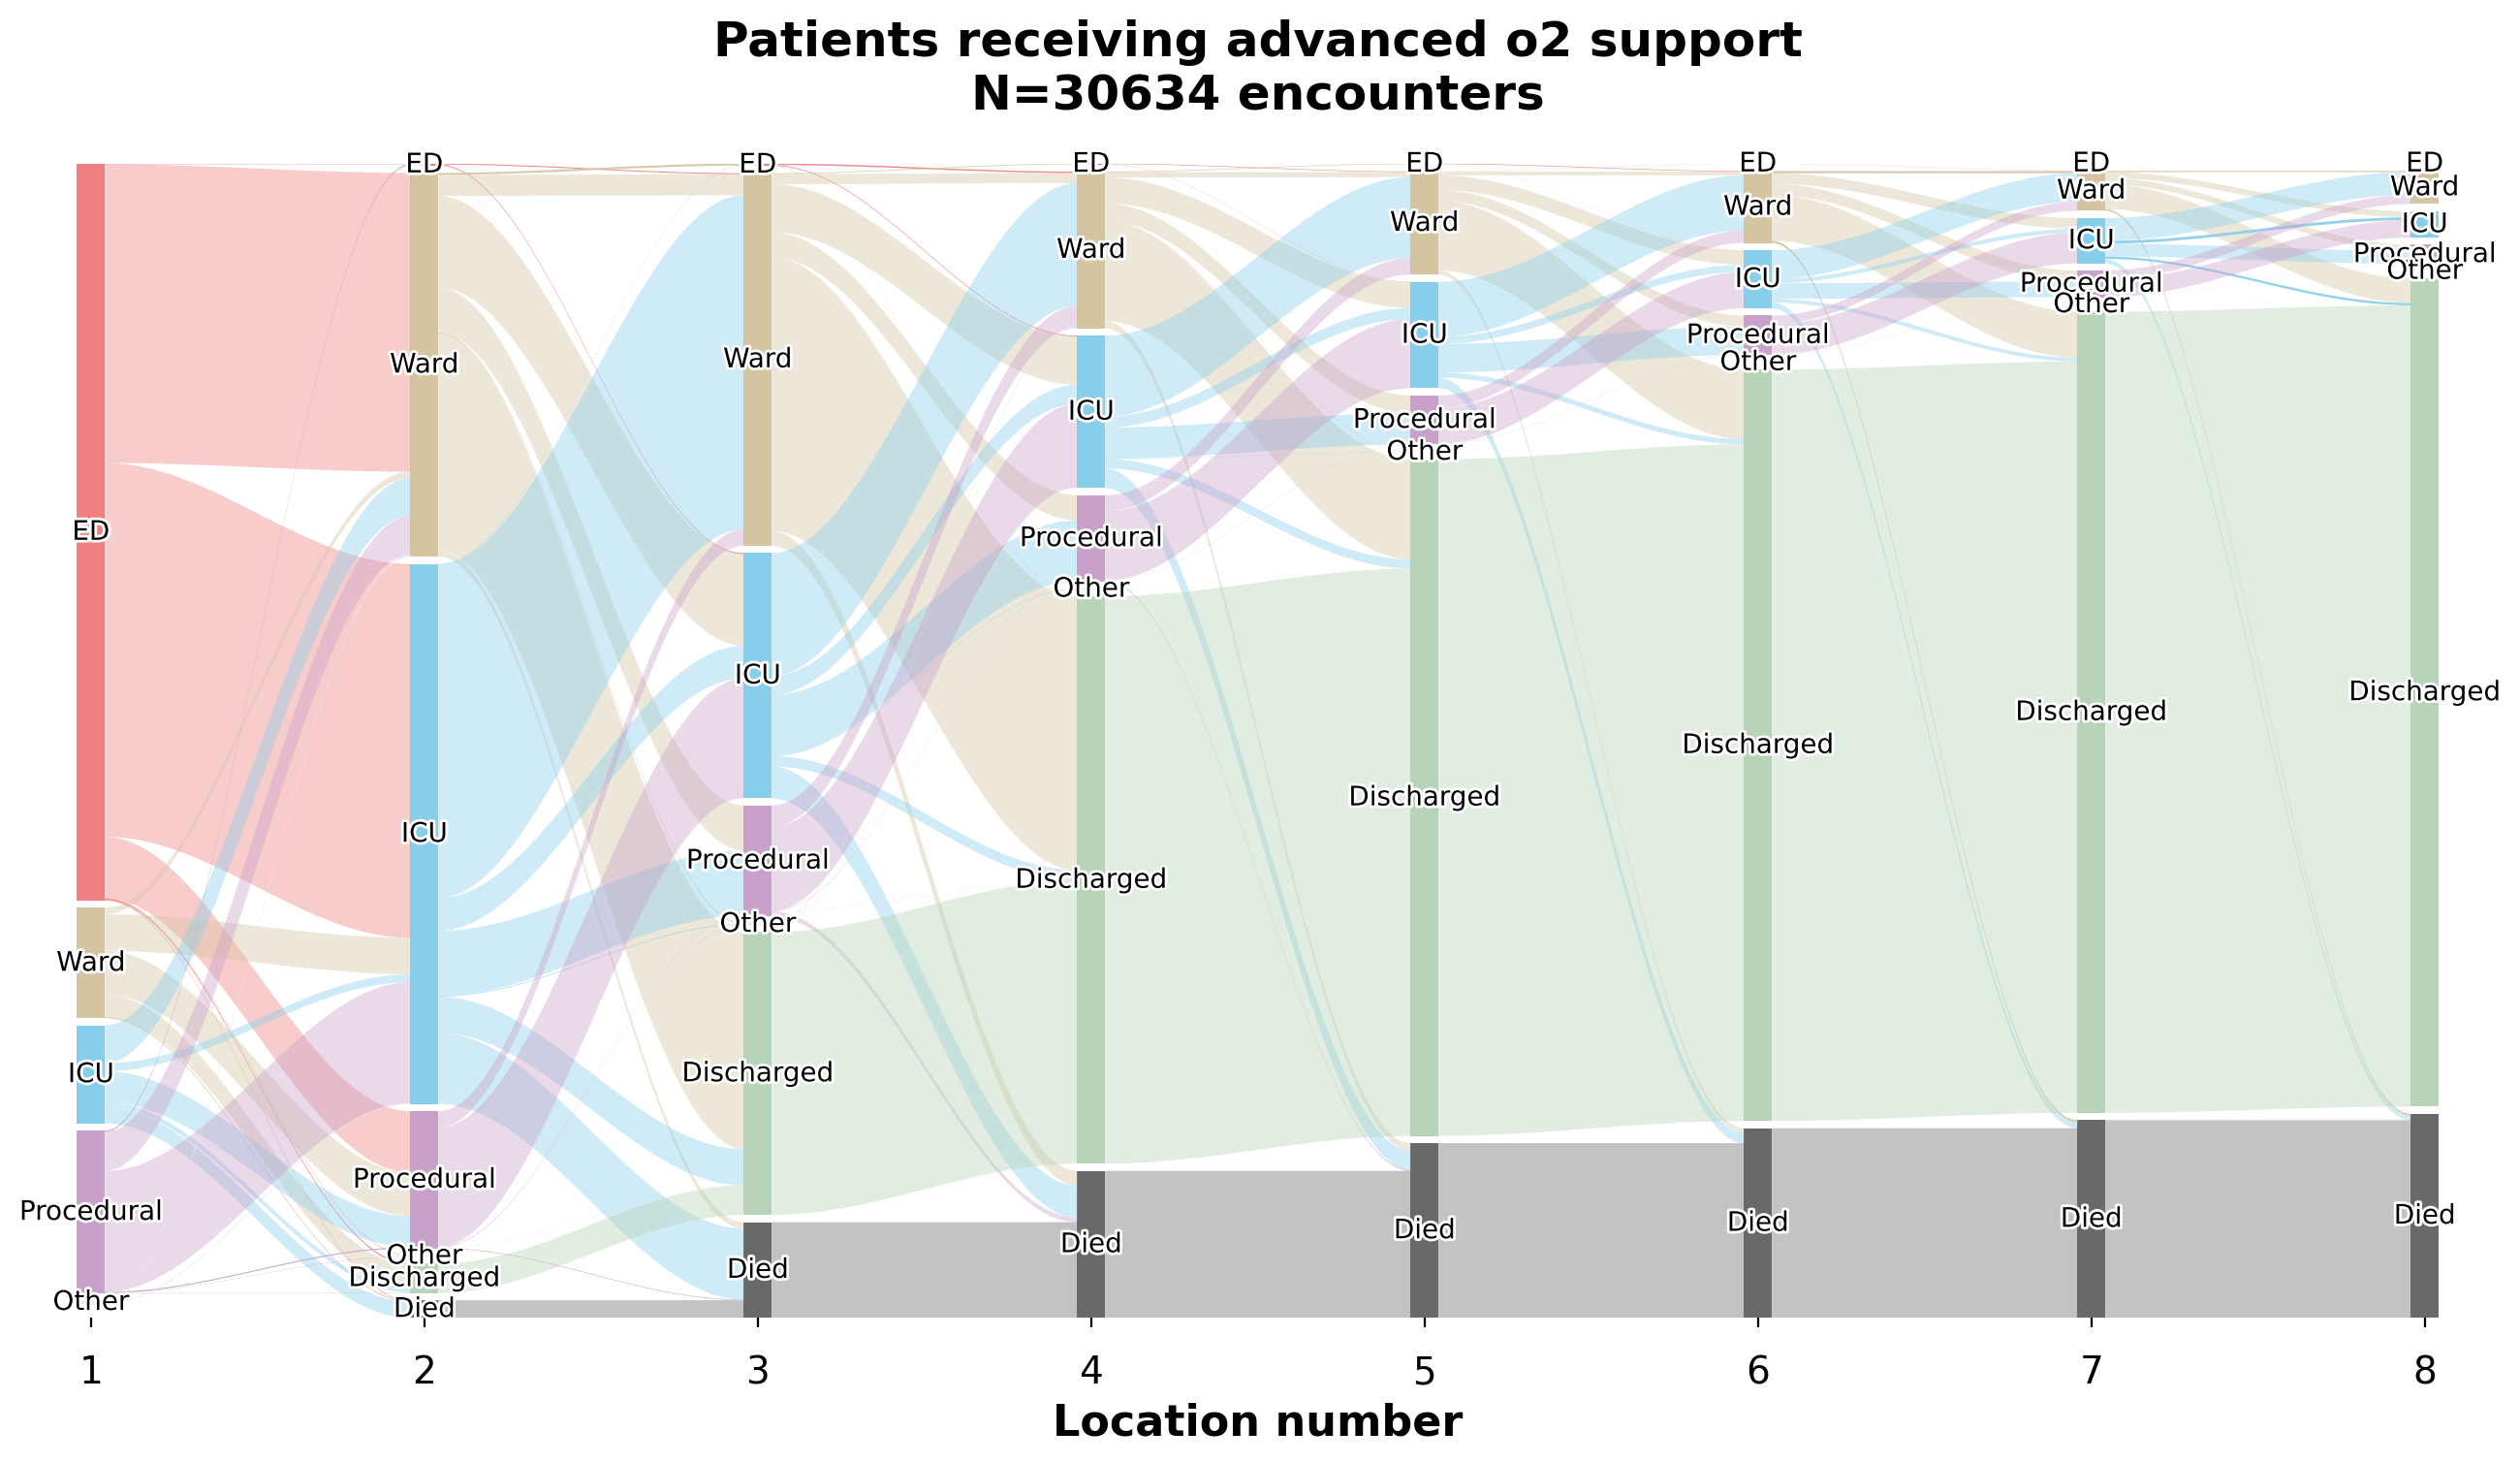

In [37]:
# other critically ill
adv_o2_sup = final_tableone_df[final_tableone_df['high_support_enc'] == 1]['encounter_block'].tolist()
fig1, df1 = create_sankey_diagram(
    adt_cohort=adt_cohort,
    encounter_blocks=adv_o2_sup,
    outcome_df=outcome_df,
    max_locations=8,
    title="Patients receiving advanced o2 support",
    output_file=f"{output_dir}/figures/sankey_matplotlib_high_o2_support.png",
    figsize=(16, 8)
)
plt.show()

✅ Saved: ../output/final/tableone/figures/sankey_matplotlib_vaso_support.png


/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_52347/3100514747.py:425: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


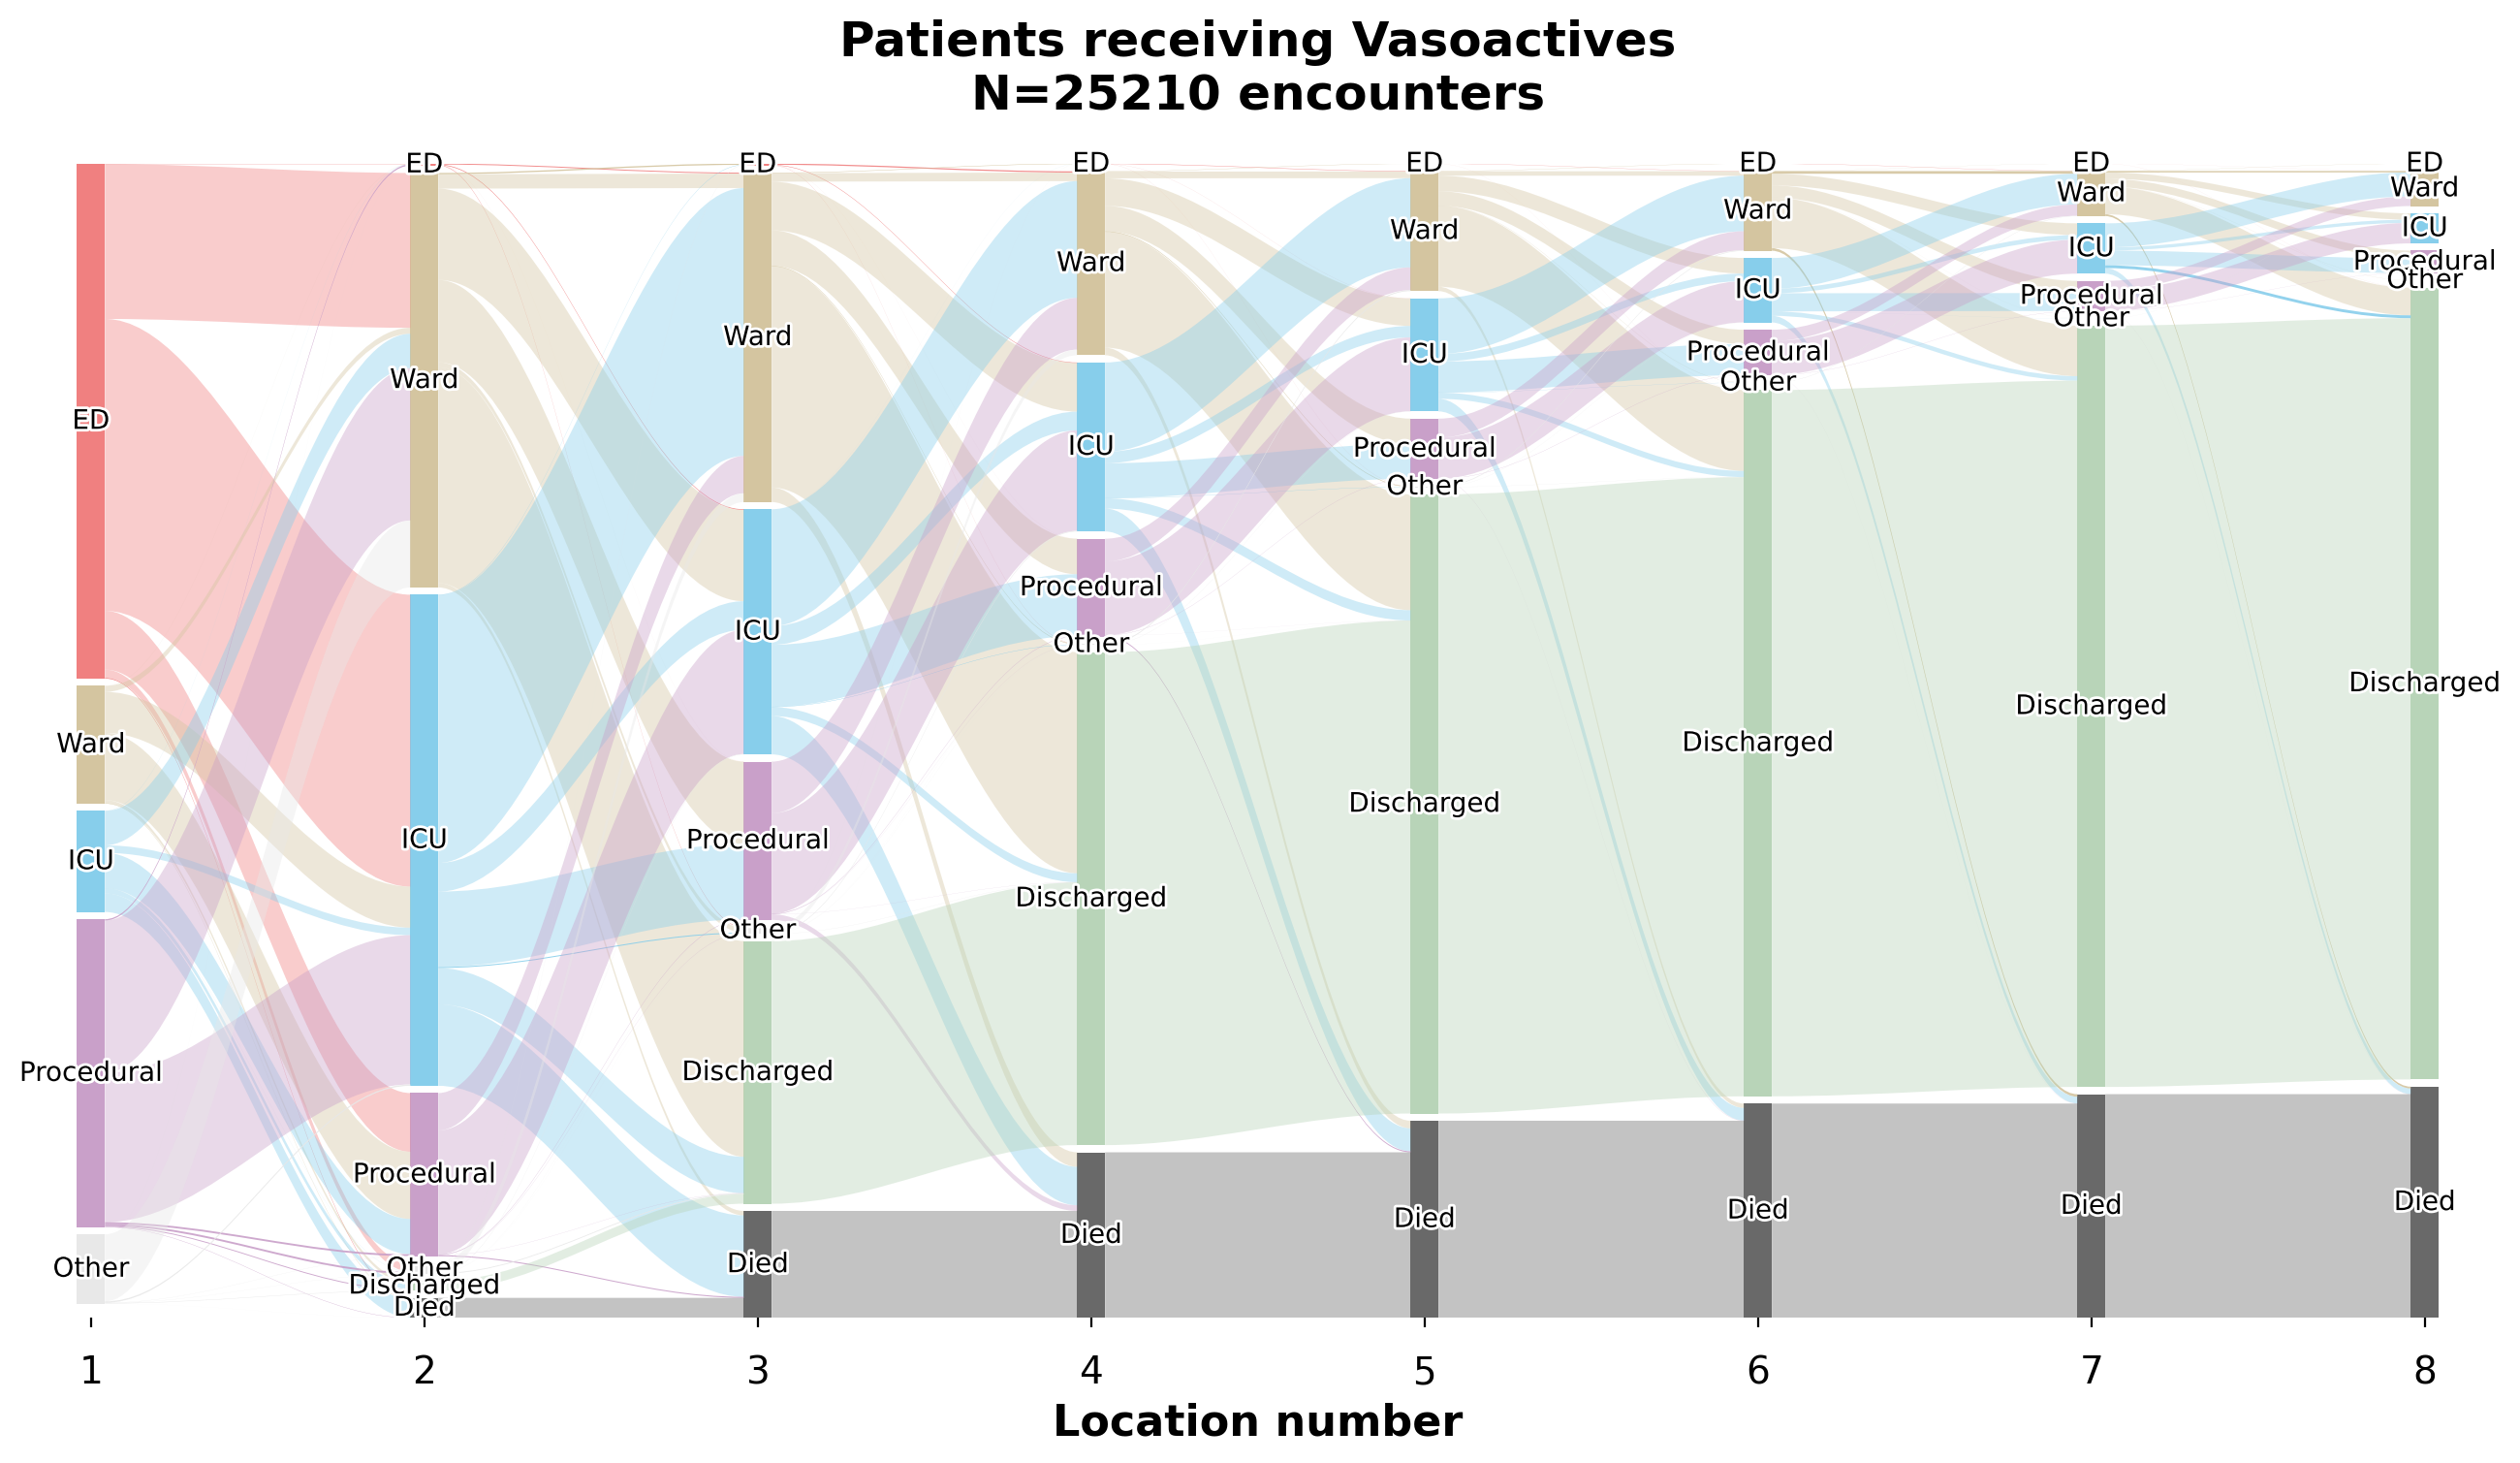

In [38]:
# other critically ill
vaso_sup = final_tableone_df[final_tableone_df['vaso_support_enc'] == 1]['encounter_block'].tolist()
fig1, df1 = create_sankey_diagram(
    adt_cohort=adt_cohort,
    encounter_blocks=vaso_sup,
    outcome_df=outcome_df,
    max_locations=8,
    title="Patients receiving Vasoactives",
    output_file=f"{output_dir}/figures/sankey_matplotlib_vaso_support.png",
    figsize=(16, 8)
)
plt.show()

# Hospital and ICU Admission Summary

1. Get the first ICU dttm for ICU encounters 
2. Calculate ICU LOS and Hospital LOS for each encounter in days. 

In [39]:
hosp_admission_summary = (
        adt_cohort
        .groupby('encounter_block')
        .agg(
            min_in_dttm = ('in_dttm', 'min'),
            max_out_dttm = ('out_dttm', 'max'),
            first_admission_location = ('location_category', 'first')
        )
)
hosp_admission_summary['hospital_length_of_stay_days'] = (
    (hosp_admission_summary['max_out_dttm'] - hosp_admission_summary['min_in_dttm']) / pd.Timedelta(days=1))

In [40]:
# lowercase the column, not the entire df
adt_cohort['location_category'] = (
    adt_cohort['location_category']
    .str.lower()
)

# restrict to ICU rows
icu_df = adt_cohort.query('location_category == "icu"')

# find first ICU in time per 'encounter_block'
first_in = (
    icu_df
     .groupby('encounter_block', as_index=False)
     .agg(first_icu_in_dttm=('in_dttm', 'min'))
)

# join back to pull the matching out_dttm
icu_summary = (
    first_in
      # bring in that one row’s out_dttm
      .merge(
          icu_df[['hospitalization_id','in_dttm','out_dttm', 'encounter_block']],
          left_on=['encounter_block', 'first_icu_in_dttm'],
          right_on=['encounter_block', 'in_dttm'],
          how='left'
      )
      .rename(columns={'out_dttm':'first_icu_out_dttm'})
)

# compute LOS in days (out - in)
icu_summary['first_icu_los_days'] = (
    (icu_summary['first_icu_out_dttm'] - icu_summary['first_icu_in_dttm'])
    .dt.total_seconds()
    / (3600 * 24)
)

# trim to just the columns you need
icu_summary = icu_summary[['encounter_block', 'first_icu_in_dttm',
                           'first_icu_out_dttm','first_icu_los_days']]

In [41]:
# Merge all_ids with icu_summary and hosp_admission_summary
final_tableone_df = (
    final_tableone_df
    .merge(icu_summary, on='encounter_block', how='left')
    .merge(hosp_admission_summary, on='encounter_block', how='left')
)
final_tableone_df['first_admission_location'] = final_tableone_df['first_admission_location'].fillna('Missing')

# Code Status

In [42]:
# ----------------------------------------------------------------------------
# Load Code Status
# ----------------------------------------------------------------------------
print(f"\nLoading code_status table...")
clif.load_table(
    'code_status'
)

get_value_counts(clif.code_status, ['code_status_name', 'code_status_category'], output_dir=mcide_dir)
print(f"   code_status loaded: {len(clif.code_status.df):,} rows")
print(f"   Unique code_status categories: {clif.code_status.df['code_status_category'].nunique()}")
print(f"   Unique code_status patients: {clif.code_status.df['patient_id'].nunique()}")


Loading code_status table...
📢 Initialized code_status table
📢 Data directory: /Users/kavenchhikara/Library/CloudStorage/Box-Box/RCLIF_data/CLIF_2018_24/WIP_2_1
📢 File type: parquet
📢 Timezone: US/Central
📢 Output directory: ../output/final/clifpy
📢 Loaded schema from /Users/kavenchhikara/Projects/CLIF/CLIF-TableOne/.venv/lib/python3.11/site-packages/clifpy/schemas/code_status_schema.yaml
📢 Loaded outlier configuration
   code_status loaded: 20,234 rows
   Unique code_status categories: 3
   Unique code_status patients: 11818


In [43]:
# Take the last code_status_category for each patient_id
code_status_latest = (
    clif.code_status.df.sort_values(['patient_id', 'start_dttm'])
    .groupby('patient_id', as_index=False)
    .last()[['patient_id', 'code_status_category']]
    .rename(columns={'code_status_category': 'last_code_status_category'})
)

# Merge with final_tableone_df on patient_id
final_tableone_df = final_tableone_df.merge(code_status_latest, on='patient_id', how='left')

In [44]:
# ============================================================================
# Prepare Aggregated Data for Code Status Visualizations
# ============================================================================

encounter_flags = ['icu_enc', 'high_support_enc', 'vaso_support_enc', 'other_critically_ill']
flag_labels = ['ICU Encounters', 'Advanced Respiratory Support', 'Vasoactive Support', 'Other Critically Ill']

# Initialize containers
code_status_counts = {}
code_status_percentages = {}
missingness_info = {}

# Collect aggregated data for each encounter type
for flag, label in zip(encounter_flags, flag_labels):
    subset = final_tableone_df[final_tableone_df[flag] == 1]
    
    # Total encounters for this type
    total_encounters = len(subset)
    
    # Count missing values
    n_missing = subset['last_code_status_category'].isna().sum()
    
    # Get value counts (including handling of NaN)
    counts = subset['last_code_status_category'].value_counts(dropna=False)
    
    # Store counts
    code_status_counts[label] = counts
    
    # Calculate percentages
    percentages = (counts / total_encounters * 100).round(2)
    code_status_percentages[label] = percentages
    
    # Store missingness information
    missingness_info[label] = {
        'total_encounters': total_encounters,
        'n_missing': n_missing,
        'pct_missing': round(n_missing / total_encounters * 100, 2) if total_encounters > 0 else 0
    }

# ============================================================================
# Create DataFrames for Export
# ============================================================================

# 1. Counts DataFrame
df_counts = pd.DataFrame(code_status_counts).fillna(0).astype(int)
df_counts.index.name = 'code_status_category'

# Handle NaN index (if exists)
if df_counts.index.isna().any():
    df_counts.index = df_counts.index.fillna('Missing')

# 2. Percentages DataFrame
df_percentages = pd.DataFrame(code_status_percentages).fillna(0)
df_percentages.index.name = 'code_status_category'

if df_percentages.index.isna().any():
    df_percentages.index = df_percentages.index.fillna('Missing')

# 3. Missingness Summary DataFrame
df_missingness = pd.DataFrame(missingness_info).T
df_missingness.index.name = 'encounter_type'

# ============================================================================
# Add Summary Statistics
# ============================================================================

# Add row totals to counts
df_counts['Total'] = df_counts.sum(axis=1)

# Add column totals to counts
df_counts.loc['Total'] = df_counts.sum(axis=0)

# Add summary to percentages (column sums should be ~100%)
df_percentages.loc['Total'] = df_percentages.sum(axis=0)

# ============================================================================
# Save to CSV Files
# ============================================================================

output_dir = '../output/final/tableone/'

# Save counts
df_counts.to_csv(f'{output_dir}code_status_counts_by_encounter_type.csv')
print(f"✅ Saved: {output_dir}code_status_counts_by_encounter_type.csv")

# Save percentages
df_percentages.to_csv(f'{output_dir}code_status_percentages_by_encounter_type.csv')
print(f"✅ Saved: {output_dir}code_status_percentages_by_encounter_type.csv")

# Save missingness summary
df_missingness.to_csv(f'{output_dir}code_status_missingness_summary.csv')
print(f"✅ Saved: {output_dir}code_status_missingness_summary.csv")

# ============================================================================
# Create Combined Summary File (Optional)
# ============================================================================

# Create a comprehensive summary with counts and percentages
combined_summary = []

for col in df_counts.columns[:-1]:  # Exclude 'Total' column
    for idx in df_counts.index[:-1]:  # Exclude 'Total' row
        count = df_counts.loc[idx, col]
        pct = df_percentages.loc[idx, col]
        combined_summary.append({
            'encounter_type': col,
            'code_status': idx,
            'count': count,
            'percentage': pct
        })

df_combined = pd.DataFrame(combined_summary)
df_combined.to_csv(f'{output_dir}code_status_combined_summary.csv', index=False)
print(f"✅ Saved: {output_dir}code_status_combined_summary.csv")

print("\n" + "="*80)
print("SAVED AGGREGATED DATA (NO PATIENT-LEVEL INFORMATION)")
print("="*80)
print(f"1. {output_dir}code_status_counts_by_encounter_type.csv")
print(f"2. {output_dir}code_status_percentages_by_encounter_type.csv")
print(f"3. {output_dir}code_status_missingness_summary.csv")
print(f"4. {output_dir}code_status_combined_summary.csv")

✅ Saved: ../output/final/tableone/code_status_counts_by_encounter_type.csv
✅ Saved: ../output/final/tableone/code_status_percentages_by_encounter_type.csv
✅ Saved: ../output/final/tableone/code_status_missingness_summary.csv
✅ Saved: ../output/final/tableone/code_status_combined_summary.csv

SAVED AGGREGATED DATA (NO PATIENT-LEVEL INFORMATION)
1. ../output/final/tableone/code_status_counts_by_encounter_type.csv
2. ../output/final/tableone/code_status_percentages_by_encounter_type.csv
3. ../output/final/tableone/code_status_missingness_summary.csv
4. ../output/final/tableone/code_status_combined_summary.csv


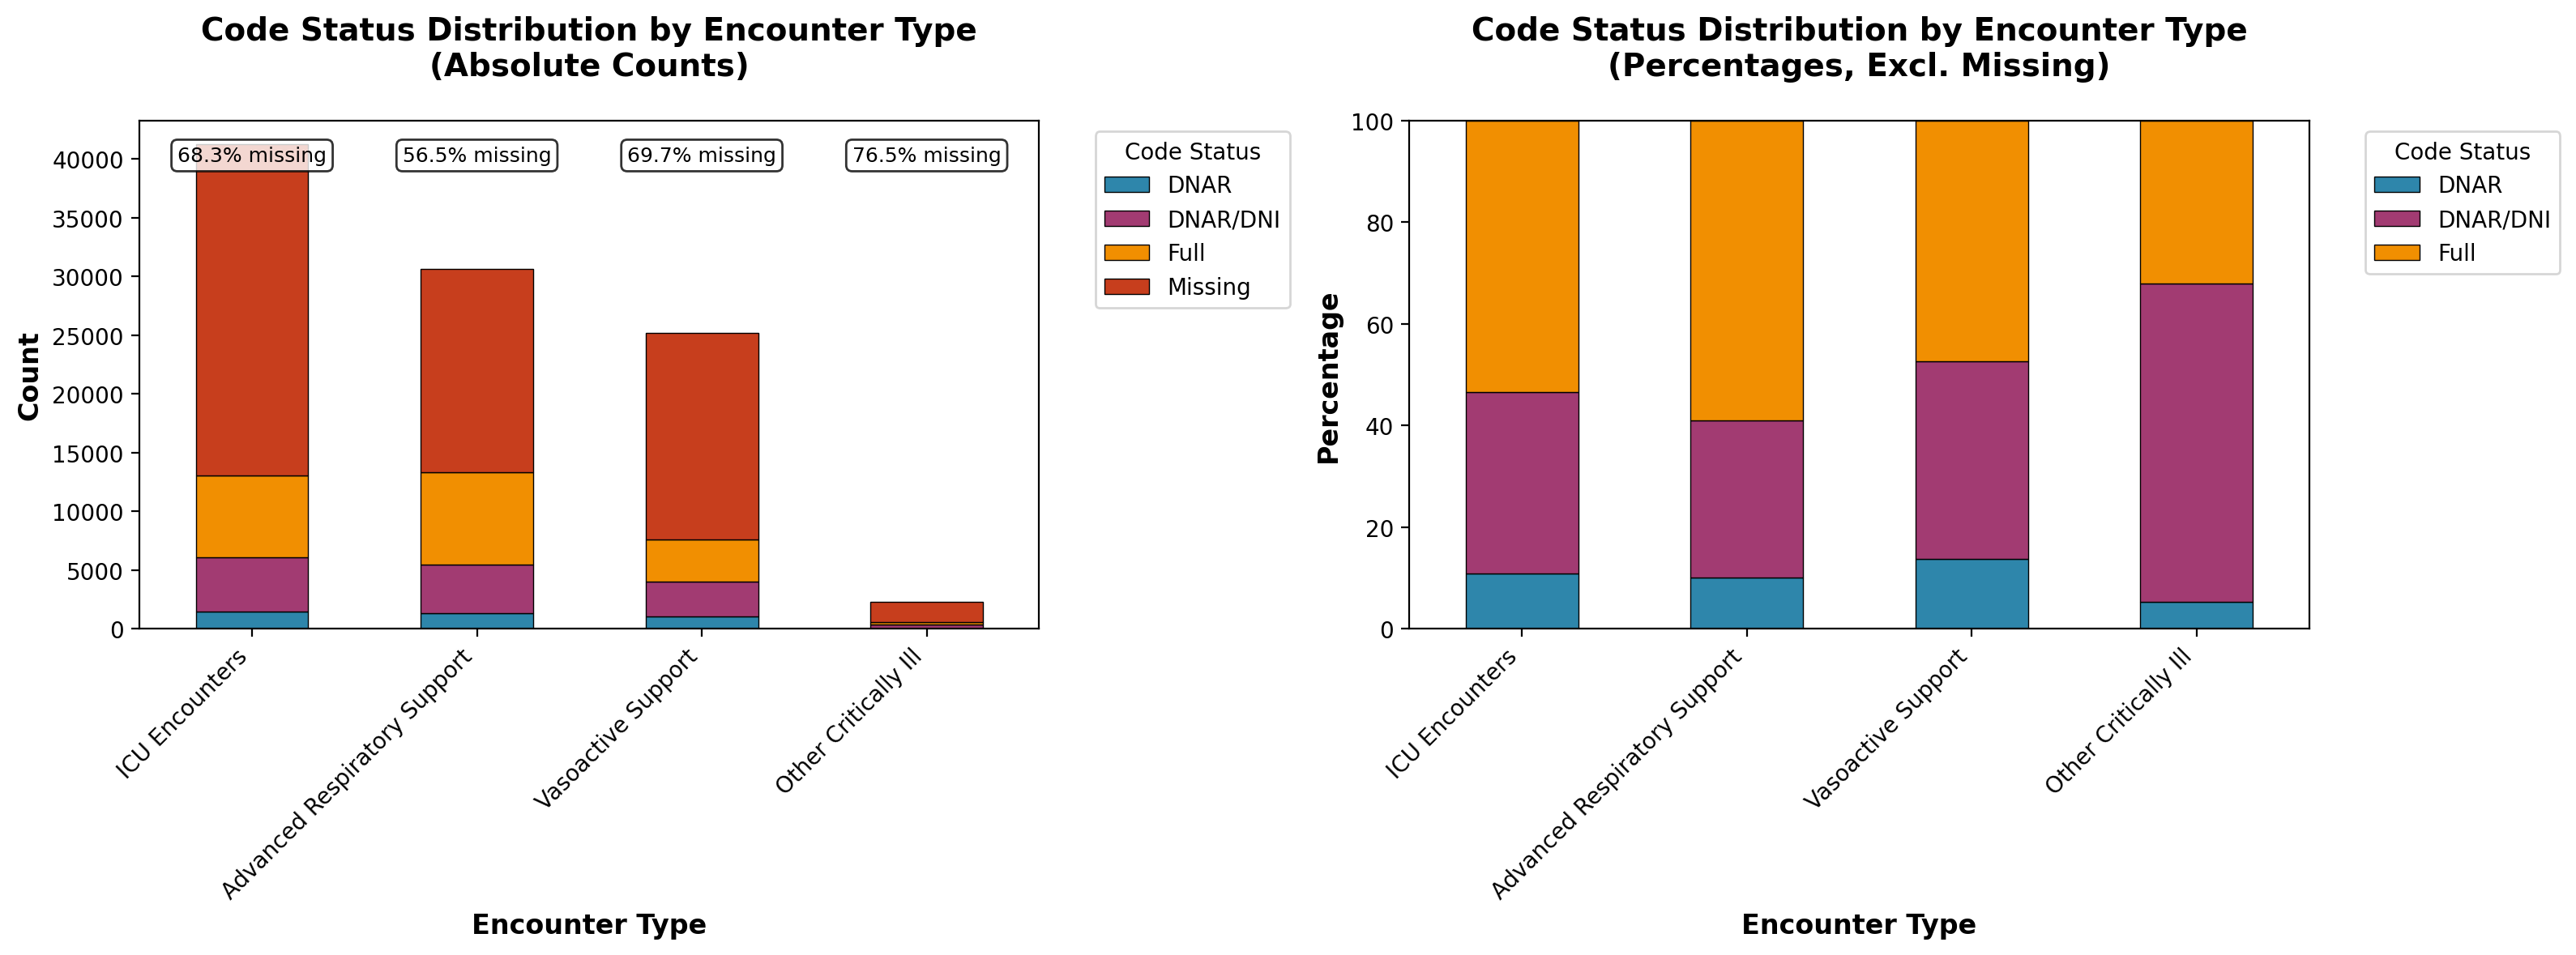

In [45]:
# ============================================================================
# Load the saved aggregated data (can be done in a separate session)
# ============================================================================

# Remove 'Total' rows/columns for visualization, but only if 'Total' exists
def drop_total_and_missing(axis_df):
    # Remove 'Total' and 'Missing' rows/cols if they exist
    for axis in [0, 1]:
        if 'Total' in axis_df.axes[axis]:
            axis_df = axis_df.drop('Total', axis=axis)
        if 'Missing' in axis_df.axes[axis]:
            axis_df = axis_df.drop('Missing', axis=axis)
    return axis_df

def drop_total_keep_missing(axis_df):
    # Remove only 'Total' rows/cols, but keep 'Missing'
    for axis in [0, 1]:
        if 'Total' in axis_df.axes[axis]:
            axis_df = axis_df.drop('Total', axis=axis)
    return axis_df

# For counts, we'll keep the "Missing" row if present for plotting, for percentages we'll recompute without it
df_counts_viz = drop_total_keep_missing(df_counts)

# Recalculate percentages excluding 'Missing' category from denominator
def recalc_percentages_exclude_missing(df_counts):
    # Only keep rows that are not 'Total' (already handled), and not 'Missing'
    code_status_rows = [row for row in df_counts.index if row != 'Missing']
    # For each column, divide counts by sum excluding 'Missing'
    df_pct = df_counts.loc[code_status_rows].div(df_counts.loc[code_status_rows].sum(axis=0), axis=1) * 100
    return df_pct

df_pct_viz = recalc_percentages_exclude_missing(df_counts_viz)

# ============================================================================
# VISUALIZATION 1: Stacked Bar Chart with Missingness Indicator
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Define colors (use different color for Missing)
status_categories = [row for row in df_counts_viz.index if row != 'Missing']
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

# If 'Missing' exists, assign it a distinct color at the end for plotting counts
if 'Missing' in df_counts_viz.index:
    status_categories_full = status_categories + ['Missing']
    colors_full = colors + ['#808080']  # Gray for missing
else:
    status_categories_full = status_categories
    colors_full = colors

# Plot 1: Absolute counts (stacked bars including Missing if present)
df_counts_viz.T[status_categories_full].plot(
    kind='bar',
    stacked=True,
    ax=ax1,
    color=colors_full[:len(status_categories_full)],
    edgecolor='black',
    linewidth=0.5
)
ax1.set_title('Code Status Distribution by Encounter Type\n(Absolute Counts)', 
              fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Encounter Type', fontsize=12, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
ax1.legend(title='Code Status', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Add missingness annotations
for i, col in enumerate(df_counts_viz.columns):
    if col in df_missingness.index:
        miss_pct = df_missingness.loc[col, 'pct_missing']
        if miss_pct > 0:
            ax1.text(
                i, ax1.get_ylim()[1] * 0.95, f'{miss_pct:.1f}% missing',
                ha='center', va='top', fontsize=9, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
            )

# Plot 2: Percentages (excluding Missing from numerator/denominator)
df_pct_viz.T[status_categories].plot(
    kind='bar',
    stacked=True,
    ax=ax2,
    color=colors[:len(status_categories)],
    edgecolor='black',
    linewidth=0.5
)
ax2.set_title('Code Status Distribution by Encounter Type\n(Percentages, Excl. Missing)', 
              fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('Encounter Type', fontsize=12, fontweight='bold')
ax2.set_ylabel('Percentage', fontsize=12, fontweight='bold')
ax2.legend(title='Code Status', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.savefig(f'{output_dir}code_status_stacked_bar_with_missingness_excl_missing_cat.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# IMV encounters

In [46]:
# Filter to only IMV hospitalizations
clif.respiratory_support.df = clif.respiratory_support.df[
    clif.respiratory_support.df['hospitalization_id'].isin(final_hosp_ids)
].copy()
print(f"Respiratory support rows (IMV hospitalizations): {len(clif.respiratory_support.df):,}")
clif.respiratory_support.df = clif.respiratory_support.df.sort_values(['hospitalization_id', 'recorded_dttm'])

# Standardize category columns to lowercase
print(f"\nStandardizing category columns...")
category_cols = [col for col in clif.respiratory_support.df.columns if col.endswith('_category')]
for col in category_cols:
    clif.respiratory_support.df[col] = clif.respiratory_support.df[col].str.lower()

from clifpy.utils import apply_outlier_handling
apply_outlier_handling(clif.respiratory_support)

# Merge with encounter_block mapping
resp_stitched = clif.respiratory_support.df

#  Identify IMV rows
imv_mask = resp_stitched['device_category'].str.contains("imv", case=False, na=False)
resp_stitched_imv = resp_stitched[imv_mask].copy()

# Create on_vent column for IMV records
resp_stitched_imv['on_vent'] = 1

# Get unique encounter IDs from resp_stitched_imv
imv_encounters = resp_stitched_imv['encounter_block'].unique()

print(f"Number of IMV encounters: {len(imv_encounters):,}")
strobe_counts["IMV encounters"] = len(imv_encounters)
# Determine Vent Start/End for Each Encounter
vent_start_end = resp_stitched_imv.groupby('encounter_block').agg(
    vent_start_time=('recorded_dttm', 'min'),
    vent_end_time=('recorded_dttm', 'max')
).reset_index()

#  Add on_vent flag to final_cohort
final_tableone_df = final_tableone_df.merge(
    resp_stitched_imv[['encounter_block', 'on_vent']].drop_duplicates(),
    on='encounter_block',
    how='left'
)
final_tableone_df['on_vent'] = final_tableone_df['on_vent'].fillna(0).astype(int)

Respiratory support rows (IMV hospitalizations): 5,416,579

Standardizing category columns...
Using CLIF standard outlier ranges

Building outlier expressions...


Building expressions: 100%|██████████| 12/12 [00:00<00:00, 9381.48column/s]


Applying outlier filtering...


Processing: 100%|██████████| 1/1 [00:00<00:00, 79.23operation/s]


fio2_set                      : 3051808 values →   6154 nullified (  0.2%)
lpm_set                       : 1727826 values →      0 nullified (  0.0%)
tidal_volume_set              : 1643176 values →    946 nullified (  0.1%)
resp_rate_set                 : 1850058 values →    148 nullified (  0.0%)
pressure_control_set          : 161976 values →    186 nullified (  0.1%)
pressure_support_set          : 450270 values →    110 nullified (  0.0%)
peak_inspiratory_pressure_set :  71775 values →     35 nullified (  0.0%)
peep_set                      : 2226500 values →    197 nullified (  0.0%)
resp_rate_obs                 : 899782 values →    255 nullified (  0.0%)
plateau_pressure_obs          : 420227 values →     49 nullified (  0.0%)
peak_inspiratory_pressure_obs : 2153926 values →    244 nullified (  0.0%)
minute_vent_obs               : 815330 values →    576 nullified (  0.1%)
Number of IMV encounters: 18,482


In [47]:
# # Apply waterfall processing to fill sparse data
# print(f"\nApplying waterfall processing to respiratory support data. This can take 2-20 mins based on your system specs and cohort size...")
# clif.respiratory_support = clif.respiratory_support.waterfall(verbose=True)
# print(f"\n Waterfall complete: {len(clif.respiratory_support.df):,} rows for {clif.respiratory_support.df['hospitalization_id'].nunique():,} unique hospitalizations")

## Initial Mode category

In [48]:
#  Get Initial Mode Category (first mode after vent start)
# Subset resp_stitched to only those encounters on IMV
resp_imv = resp_stitched[resp_stitched['encounter_block'].isin(imv_encounters)].copy()

# Merge in the vent_start_time
resp_imv = resp_imv.merge(
    vent_start_end[['encounter_block', 'vent_start_time']],
    on='encounter_block',
    how='left'
)

# Filter to only rows at or after vent start
resp_post_start = resp_imv[
    resp_imv['recorded_dttm'] >= resp_imv['vent_start_time']
]

# Group and take first non-NA mode_category per encounter
initial_modes = (
    resp_post_start
    .sort_values(['encounter_block', 'recorded_dttm'])
    .groupby('encounter_block', as_index=False)['mode_category']
    .first()
    .rename(columns={'mode_category': 'initial_mode_category'})
)

# Fill any entirely-missing groups with "Missing"
initial_modes['initial_mode_category'] = initial_modes['initial_mode_category'].fillna('Missing')

# Merge back onto final_cohort
final_tableone_df = final_tableone_df.merge(
    initial_modes,
    on='encounter_block',
    how='left'
)

# If some encounters never went on vent, fill those too
final_tableone_df['initial_mode_category'] = final_tableone_df['initial_mode_category'].fillna('Missing')

In [49]:
#  Calculate Ventilator Settings Statistics (Median and IQR)
# Filter resp_stitched to only those encounters on IMV
# resp_stitched_final = resp_stitched[resp_stitched['encounter_block'].isin(imv_encounters)]

# # Define numeric columns to aggregate
# numeric_cols = [
#     'fio2_set', 'lpm_set', 'resp_rate_set', 'peep_set',
#     'tidal_volume_set', 'pressure_control_set', 'pressure_support_set'
# ]

# # Build named aggregation dict
# named_aggs = {}
# for col in numeric_cols:
#     named_aggs[f'{col}_median'] = (col, 'median')
#     named_aggs[f'{col}_q1'] = (col, lambda x: x.quantile(0.25))
#     named_aggs[f'{col}_q3'] = (col, lambda x: x.quantile(0.75))

# # Aggregate ventilator settings
# vent_stats = (
#     resp_stitched_final
#     .groupby('encounter_block', as_index=False)
#     .agg(**named_aggs)
# )

# # Merge vent stats back to final_cohort
# final_tableone_df = final_tableone_df.merge(vent_stats, on='encounter_block', how='left')

#  Find First Location at IMV Start (closest ADT location to vent start)
# Get minimal ADT cohort with required columns and merge with encounter_block
print("Find First Location at IMV Start (closest ADT location to vent start)")

# Merge with vent start times
adt_vent = pd.merge(
    vent_start_end[['encounter_block', 'vent_start_time']],
    adt_cohort,
    on='encounter_block'
)

# Calculate time difference between vent start and ADT in_dttm
adt_vent['time_diff'] = abs(adt_vent['vent_start_time'] - adt_vent['in_dttm'])

# Get the closest ADT row for each encounter block
closest_adt = (
    adt_vent
    .sort_values('time_diff')
    .groupby('encounter_block')
    .first()
    .reset_index()
)
closest_adt = closest_adt.rename(columns={'location_category': 'first_location_imv'})

# Merge back to final_cohort
final_tableone_df = final_tableone_df.merge(
    closest_adt[['encounter_block', 'first_location_imv']],
    on='encounter_block',
    how='left'
)

print("\n=== IMV Encounter Summary Complete ===")
print(f"Total encounters: {len(final_tableone_df):,}")
print(f"Encounters on IMV: {final_tableone_df['on_vent'].sum():,}")
print(f"Initial mode categories:\n{final_tableone_df['initial_mode_category'].value_counts()}")

Find First Location at IMV Start (closest ADT location to vent start)

=== IMV Encounter Summary Complete ===
Total encounters: 57,160
Encounters on IMV: 18,501
Initial mode categories:
initial_mode_category
Missing                              38995
assist control-volume control        16614
pressure support/cpap                  848
pressure control                       366
simv                                   263
volume support                          51
pressure-regulated volume control       23
Name: count, dtype: int64


## IMV- First 24 hours 

In [50]:
# ============================================================================
# 1. Add vent_start_dttm to final_tableone_df
# ============================================================================

# Merge vent_start_time from vent_start_end into final_tableone_df
final_tableone_df = final_tableone_df.merge(
    vent_start_end[['encounter_block', 'vent_start_time']],
    on='encounter_block',
    how='left'
)

# Rename to vent_start_dttm for clarity
final_tableone_df = final_tableone_df.rename(columns={'vent_start_time': 'vent_start_dttm'})

print(f"\n✅ Added vent_start_dttm to final_tableone_df")
print(f"   Encounters with vent_start_dttm: {final_tableone_df['vent_start_dttm'].notna().sum():,}")

# ============================================================================
# 2. Prepare IMV data with time from vent start
# ============================================================================

# Get IMV encounters
resp_imv = resp_stitched[resp_stitched['encounter_block'].isin(imv_encounters)].copy()

# Merge vent_start_dttm
resp_imv = resp_imv.merge(
    final_tableone_df[['encounter_block', 'vent_start_dttm']],
    on='encounter_block',
    how='left'
)

# Calculate hours from vent start (time 0)
resp_imv['hours_from_vent_start'] = (
    (resp_imv['recorded_dttm'] - resp_imv['vent_start_dttm']).dt.total_seconds() / 3600
)

# Filter to only records at or after vent start
resp_imv_post_start = resp_imv[resp_imv['hours_from_vent_start'] >= 0].copy()


✅ Added vent_start_dttm to final_tableone_df
   Encounters with vent_start_dttm: 18,501


In [51]:
final_tableone_df.columns

Index(['patient_id', 'hospitalization_id', 'encounter_block', 'admission_dttm',
       'discharge_dttm', 'age_at_admission', 'discharge_category',
       'admission_type_category', 'race_category', 'ethnicity_category',
       'sex_category', 'death_dttm', 'icu_enc', 'death_enc', 'cohort_enc',
       'high_support_enc', 'vaso_support_enc', 'other_critically_ill',
       'first_icu_in_dttm', 'first_icu_out_dttm', 'first_icu_los_days',
       'min_in_dttm', 'max_out_dttm', 'first_admission_location',
       'hospital_length_of_stay_days', 'last_code_status_category', 'on_vent',
       'initial_mode_category', 'first_location_imv', 'vent_start_dttm'],
      dtype='object')

In [52]:
# ============================================================================
# SUPER OPTIMIZED: Calculate Statistics (10-20x faster!)
# ============================================================================
# Define all ventilator settings
vent_settings = [
    'fio2_set', 'lpm_set', 'tidal_volume_set', 'resp_rate_set',
    'pressure_control_set', 'pressure_support_set', 'peep_set'
]

# Check which columns exist
existing_settings = [col for col in vent_settings if col in resp_imv.columns]

print(f"\nSettings to calculate: {len(existing_settings)}, vent settings")

# ✅ SUPER OPTIMIZATION: Calculate each stat separately (pandas can optimize better)
results = []

# Median and mean/std (fast built-ins)
medians = resp_imv.groupby('encounter_block')[existing_settings].median()
medians.columns = [f'{col}_median' for col in medians.columns]

means = resp_imv.groupby('encounter_block')[existing_settings].mean()
means.columns = [f'{col}_mean' for col in means.columns]

stds = resp_imv.groupby('encounter_block')[existing_settings].std()
stds.columns = [f'{col}_std' for col in stds.columns]

# Quantiles (still need to use slower method, but only once each)
q1 = resp_imv.groupby('encounter_block')[existing_settings].quantile(0.25)
q1.columns = [f'{col}_q1' for col in q1.columns]

q3 = resp_imv.groupby('encounter_block')[existing_settings].quantile(0.75)
q3.columns = [f'{col}_q3' for col in q3.columns]

# Combine all statistics
vent_settings_stats = pd.concat([medians, q1, q3, means, stds], axis=1).reset_index()

print(f"✅ Calculated statistics for {len(existing_settings)} settings")
print(f"   Total encounters: {len(vent_settings_stats):,}")

# Merge back
final_tableone_df = final_tableone_df.merge(
    vent_settings_stats,
    on='encounter_block',
    how='left'
)


Settings to calculate: 7, vent settings
✅ Calculated statistics for 7 settings
   Total encounters: 18,482



📊 Mode Category Breakdown:
   Volume Control modes: 499,659 records
      - assist control-volume control: 498,114
      - pressure-regulated volume control: 1,545
   Pressure Control mode: 55,864 records
✅ Saved CSV: ../output/final/tableone/tidal_volume_volume_control_modes.csv


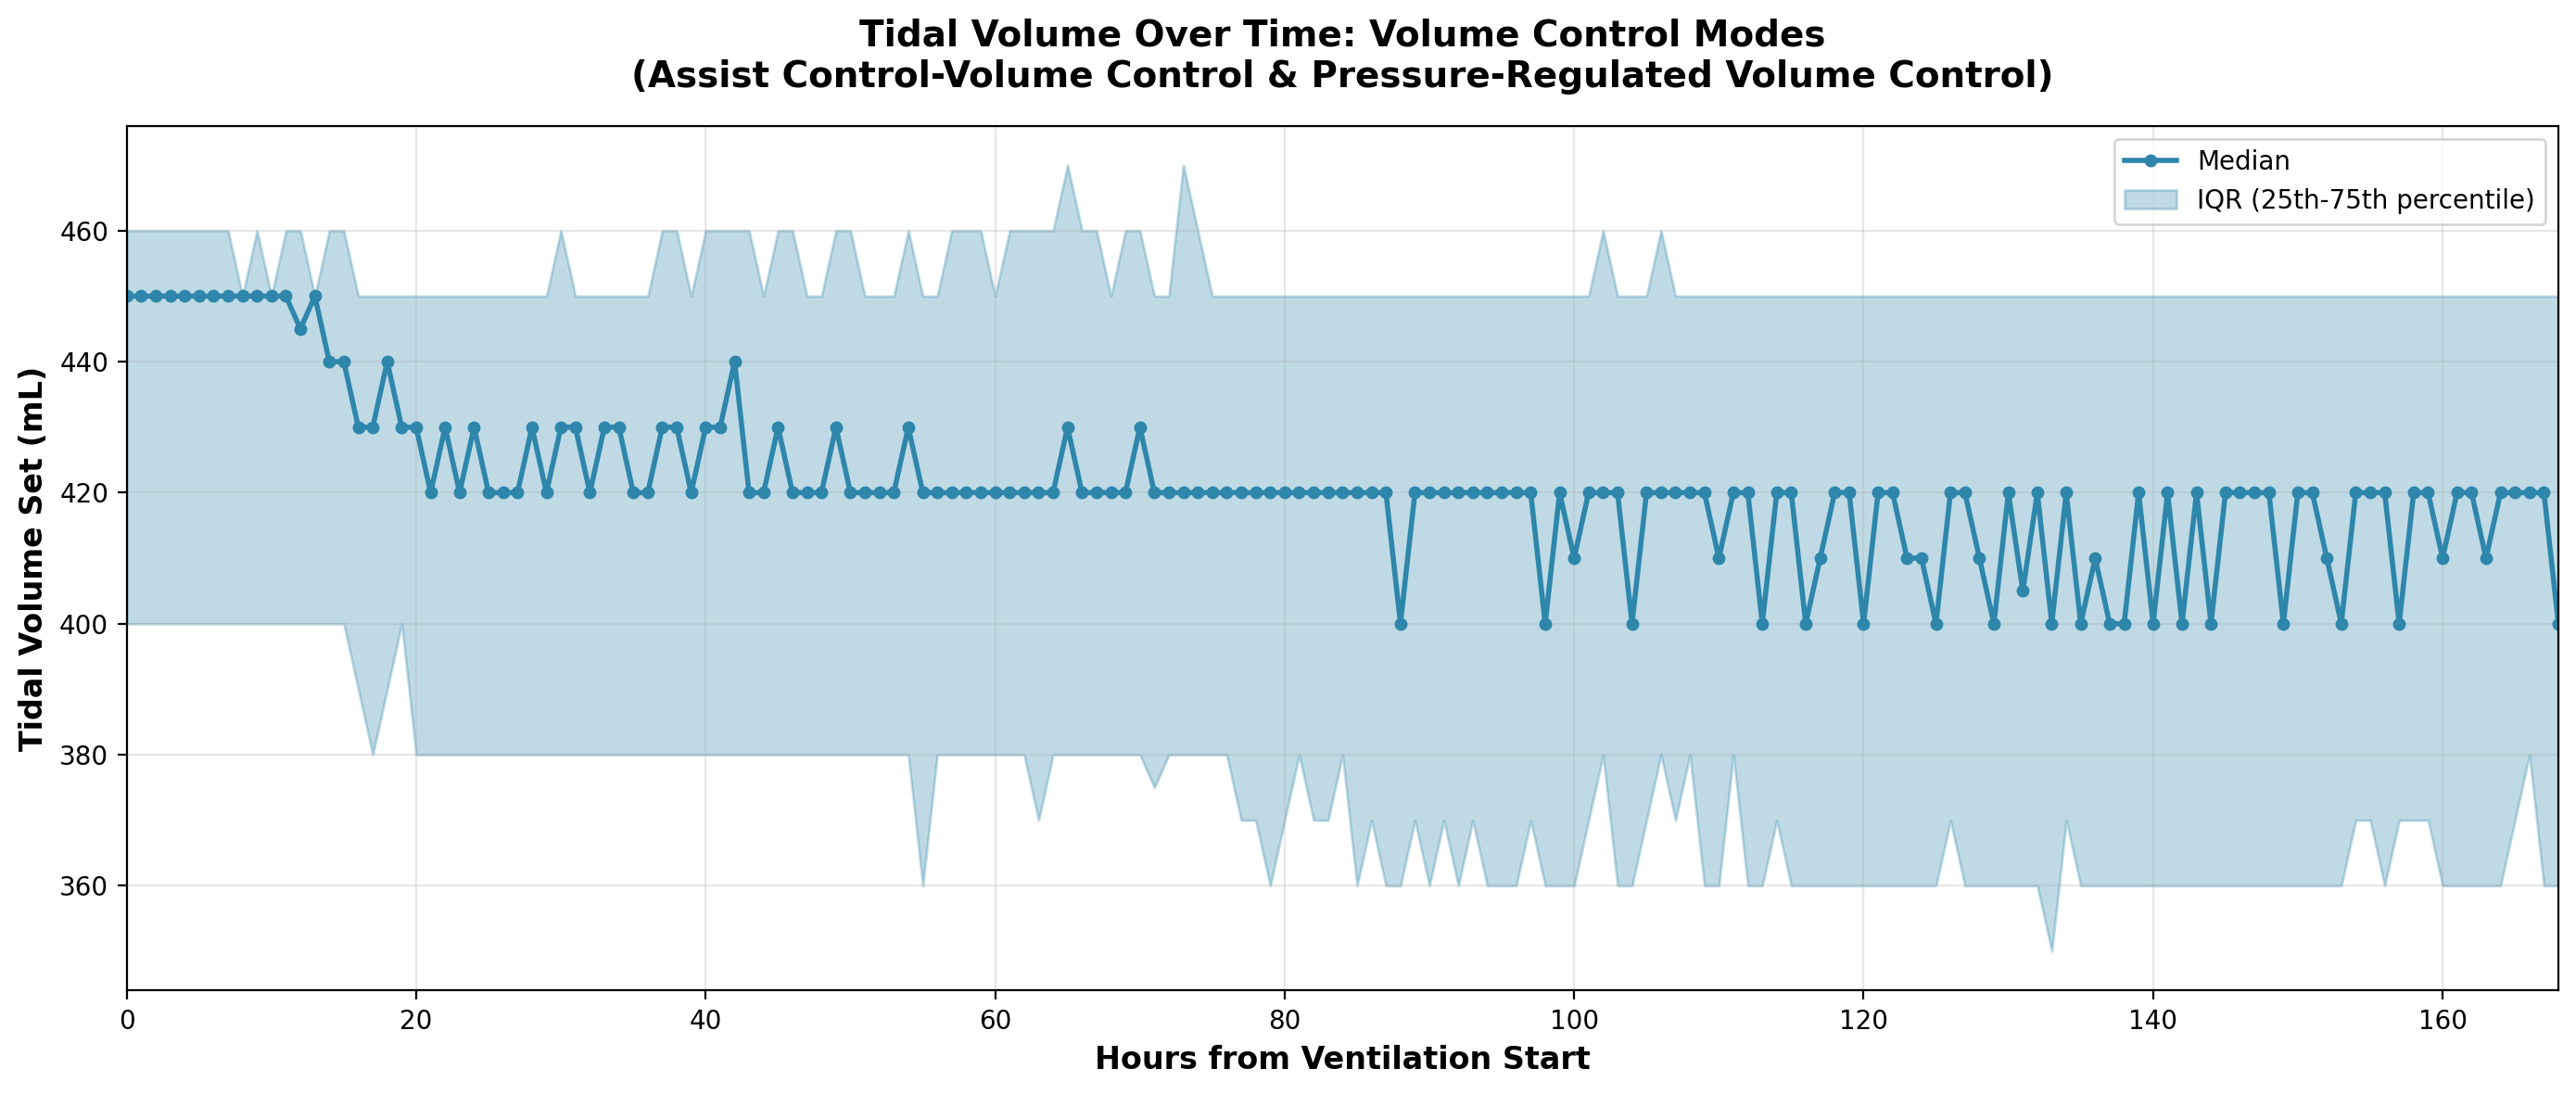


✅ Saved: ../output/final/tableone/tidal_volume_volume_control_modes.png
✅ Saved CSV: ../output/final/tableone/pressure_control_pressure_control_mode.csv


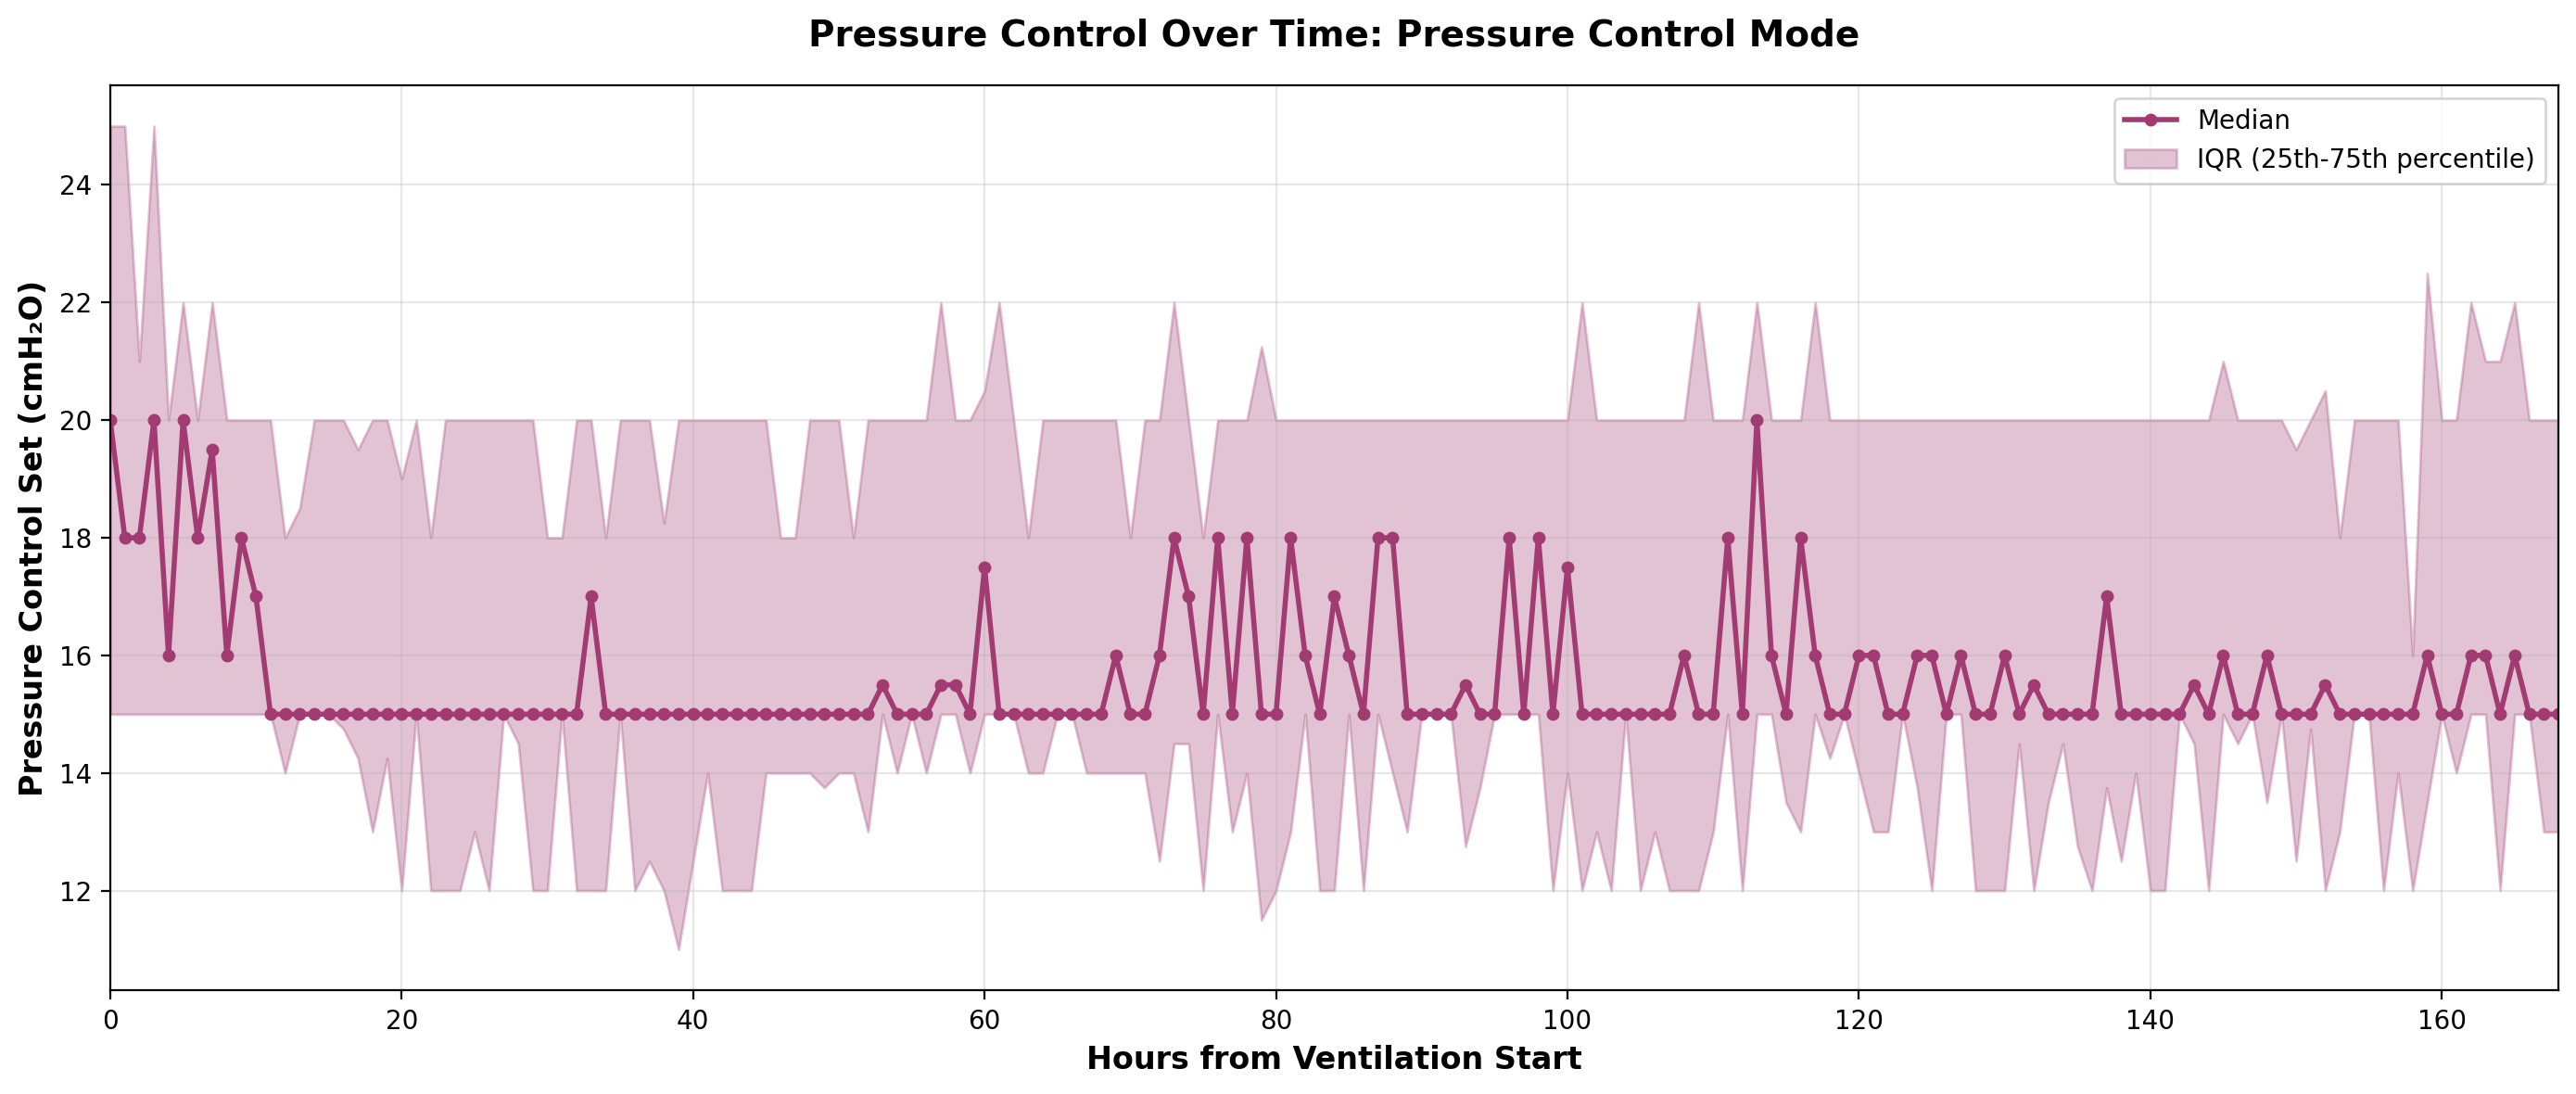

✅ Saved: ../output/final/tableone/pressure_control_pressure_control_mode.png


In [53]:
# ============================================================================
# 3. Filter for specific mode categories
# ============================================================================

# Define mode categories of interest
volume_control_modes = ['assist control-volume control', 'pressure-regulated volume control']
pressure_control_mode = ['pressure control']

# Filter data
volume_mode_data = resp_imv_post_start[
    resp_imv_post_start['mode_category'].isin(volume_control_modes)
].copy()

pressure_mode_data = resp_imv_post_start[
    resp_imv_post_start['mode_category'].isin(pressure_control_mode)
].copy()

print(f"\n📊 Mode Category Breakdown:")
print(f"   Volume Control modes: {len(volume_mode_data):,} records")
for mode in volume_control_modes:
    count = (volume_mode_data['mode_category'] == mode).sum()
    print(f"      - {mode}: {count:,}")
print(f"   Pressure Control mode: {len(pressure_mode_data):,} records")

# ============================================================================
# 4. Plot Median/IQR Tidal Volume for Volume Control Modes
# ============================================================================

# Calculate median and IQR tidal volume by hour for volume modes
volume_mode_data['hour_bin'] = volume_mode_data['hours_from_vent_start'].round(0).astype(int)

# Filter to first 168 hours (7 days)
volume_mode_data_7d = volume_mode_data[volume_mode_data['hour_bin'] <= 168].copy()

# Group by hour and calculate stats
tv_stats = volume_mode_data_7d.groupby('hour_bin')['tidal_volume_set'].agg([
    ('median', 'median'),
    ('q25', lambda x: x.quantile(0.25)),
    ('q75', lambda x: x.quantile(0.75)),
    ('count', 'count')
]).reset_index()

# Filter hours with at least 10 measurements
tv_stats = tv_stats[tv_stats['count'] >= 10]

# Save CSV for Tidal Volume data
tv_csv_path = '../output/final/tableone/tidal_volume_volume_control_modes.csv'
tv_stats.to_csv(tv_csv_path, index=False)
print(f"✅ Saved CSV: {tv_csv_path}")

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(tv_stats['hour_bin'], tv_stats['median'], 'o-', color='#2E86AB', linewidth=2, markersize=4, label='Median')
ax.fill_between(tv_stats['hour_bin'], tv_stats['q25'], tv_stats['q75'], 
                alpha=0.3, color='#2E86AB', label='IQR (25th-75th percentile)')

ax.set_xlabel('Hours from Ventilation Start', fontsize=12, fontweight='bold')
ax.set_ylabel('Tidal Volume Set (mL)', fontsize=12, fontweight='bold')
ax.set_title('Tidal Volume Over Time: Volume Control Modes\n(Assist Control-Volume Control & Pressure-Regulated Volume Control)', 
             fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 168)

plt.tight_layout()
plt.savefig('../output/final/tableone/tidal_volume_volume_control_modes.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"\n✅ Saved: ../output/final/tableone/tidal_volume_volume_control_modes.png")

# ============================================================================
# 5. Plot Median/IQR Pressure Control for Pressure Control Mode
# ============================================================================

# Calculate stats for pressure control
pressure_mode_data['hour_bin'] = pressure_mode_data['hours_from_vent_start'].round(0).astype(int)
pressure_mode_data_7d = pressure_mode_data[pressure_mode_data['hour_bin'] <= 168].copy()

pc_stats = pressure_mode_data_7d.groupby('hour_bin')['pressure_control_set'].agg([
    ('median', 'median'),
    ('q25', lambda x: x.quantile(0.25)),
    ('q75', lambda x: x.quantile(0.75)),
    ('count', 'count')
]).reset_index()

pc_stats = pc_stats[pc_stats['count'] >= 10]

# Save CSV for Pressure Control data
pc_csv_path = '../output/final/tableone/pressure_control_pressure_control_mode.csv'
pc_stats.to_csv(pc_csv_path, index=False)
print(f"✅ Saved CSV: {pc_csv_path}")

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(pc_stats['hour_bin'], pc_stats['median'], 'o-', color='#A23B72', linewidth=2, markersize=4, label='Median')
ax.fill_between(pc_stats['hour_bin'], pc_stats['q25'], pc_stats['q75'], 
                alpha=0.3, color='#A23B72', label='IQR (25th-75th percentile)')

ax.set_xlabel('Hours from Ventilation Start', fontsize=12, fontweight='bold')
ax.set_ylabel('Pressure Control Set (cmH₂O)', fontsize=12, fontweight='bold')
ax.set_title('Pressure Control Over Time: Pressure Control Mode', 
             fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 168)

plt.tight_layout()
plt.savefig('../output/final/tableone/pressure_control_pressure_control_mode.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: ../output/final/tableone/pressure_control_pressure_control_mode.png")

In [54]:
# ============================================================================
# OPTIMIZED: Ventilator Settings Table by Device and Mode Category - FIXED
# ============================================================================

import numpy as np

# Ventilator settings of interest
vent_settings = [
    'fio2_set',
    'tidal_volume_set',
    'resp_rate_set',
    'pressure_control_set',
    'peep_set',
    'pressure_support_set'
]

# ✅ OPTIMIZATION: Use groupby instead of nested loops (10-50x faster!)
# Filter to combinations with at least 10 observations
group_counts = resp_imv_post_start.groupby(['device_category', 'mode_category']).size()
valid_groups = group_counts[group_counts >= 10].index

# Filter data to only valid groups
resp_valid = resp_imv_post_start[
    resp_imv_post_start.set_index(['device_category', 'mode_category']).index.isin(valid_groups)
].copy()

print(f"Calculating statistics for {len(valid_groups)} device-mode combinations...")

# Calculate median, Q1, Q3
medians = resp_valid.groupby(['device_category', 'mode_category'])[vent_settings].median()
q1 = resp_valid.groupby(['device_category', 'mode_category'])[vent_settings].quantile(0.25)
q3 = resp_valid.groupby(['device_category', 'mode_category'])[vent_settings].quantile(0.75)

# ✅ FIX: Reset index for all before combining
medians_reset = medians.reset_index()
q1_reset = q1.reset_index()
q3_reset = q3.reset_index()

# Create settings summary starting with device and mode columns
settings_summary = medians_reset[['device_category', 'mode_category']].copy()

# ✅ Format as "median (q1-q3)" using .values (no index issues)
for setting in vent_settings:
    if setting in medians.columns:
        # Use .values to avoid index alignment issues
        settings_summary[setting] = (
            medians_reset[setting].round(1).astype(str) + ' (' +
            q1_reset[setting].round(1).astype(str) + '-' +
            q3_reset[setting].round(1).astype(str) + ')'
        )

# Rename columns
settings_summary = settings_summary.rename(columns={
    'mode_category': 'ventilator_setting',
    'fio2_set': 'FiO2 Set',
    'tidal_volume_set': 'Tidal Volume Set',
    'resp_rate_set': 'Resp Rate Set',
    'pressure_control_set': 'Pressure Control Set',
    'peep_set': 'PEEP Set',
    'pressure_support_set': 'Pressure Support Set'
})

# Sort by device and mode
settings_summary = settings_summary.sort_values(['device_category', 'ventilator_setting'])

# Display and save
print("\n" + "="*80)
print("VENTILATOR SETTINGS BY DEVICE AND MODE CATEGORY")
print("="*80)
print(settings_summary.to_string(index=False))

settings_summary.to_csv('../output/final/tableone/ventilator_settings_by_device_mode.csv', index=False)
print(f"\n✅ Saved: ../output/final/tableone/ventilator_settings_by_device_mode.csv")

# ============================================================================
# BONUS: Also create counts table (same optimization)
# ============================================================================

print("\n" + "="*80)
print("Creating Observation Counts Table")
print("="*80)

# Count non-null observations for each setting (vectorized)
counts_summary = resp_valid.groupby(['device_category', 'mode_category'])[vent_settings].count().reset_index()

# Rename columns
counts_summary = counts_summary.rename(columns={
    'mode_category': 'ventilator_setting',
    'fio2_set': 'FiO2 Set (N)',
    'tidal_volume_set': 'Tidal Volume Set (N)',
    'resp_rate_set': 'Resp Rate Set (N)',
    'pressure_control_set': 'Pressure Control Set (N)',
    'peep_set': 'PEEP Set (N)',
    'pressure_support_set': 'Pressure Support Set (N)'
})

# Sort
counts_summary = counts_summary.sort_values(['device_category', 'ventilator_setting'])

print("\nObservation Counts by Device and Mode:")
print(counts_summary.to_string(index=False))

counts_summary.to_csv('../output/final/tableone/ventilator_settings_counts_by_device_mode.csv', index=False)
print(f"\n✅ Saved: ../output/final/tableone/ventilator_settings_counts_by_device_mode.csv")

Calculating statistics for 11 device-mode combinations...

VENTILATOR SETTINGS BY DEVICE AND MODE CATEGORY
device_category                ventilator_setting      FiO2 Set    Tidal Volume Set    Resp Rate Set Pressure Control Set      PEEP Set Pressure Support Set
           cpap             pressure support/cpap 0.4 (0.3-0.4) 400.0 (300.2-450.0) 12.0 (12.0-16.0)     15.0 (10.0-15.0) 5.0 (5.0-5.0)       5.0 (0.0-10.0)
            imv     assist control-volume control 0.4 (0.4-0.5) 420.0 (370.0-450.0) 16.0 (12.0-20.0)     15.0 (15.0-22.0) 5.0 (5.0-5.0)       5.0 (5.0-10.0)
            imv                  pressure control 0.4 (0.4-0.6) 406.0 (370.0-450.0) 18.0 (14.0-22.0)     18.0 (15.0-22.0) 5.0 (5.0-8.0)      10.0 (5.0-15.0)
            imv             pressure support/cpap 0.4 (0.4-0.4) 400.0 (341.0-450.0) 14.0 (10.0-18.0)     15.0 (15.0-15.0) 5.0 (5.0-5.0)       8.0 (5.0-10.0)
            imv pressure-regulated volume control 0.4 (0.4-0.4) 420.0 (400.0-450.0) 14.5 (12.0-16.0)     15.

In [55]:
print("\n" + "="*80)
print("VENTILATOR MODE PROPORTIONS - FIRST 24 HOURS OF IMV")
print("="*80)

# ============================================================================
# 1. Filter to First 24 Hours of IMV
# ============================================================================

# Use the IMV data with hours from vent start that we already created
imv_first_24h = resp_imv_post_start[
    (resp_imv_post_start['hours_from_vent_start'] >= 0) &
    (resp_imv_post_start['hours_from_vent_start'] <= 24)
].copy()
resp_support = clifpy.tables.RespiratorySupport(data=imv_first_24h, output_directory=clifpy_dir)
resp_support = resp_support.waterfall(verbose=True)
imv_first_24h = resp_support.df.copy()

print(f"\n📊 Data Summary:")
print(f"   Total IMV records in first 24h: {len(imv_first_24h):,}")
print(f"   Unique encounters: {imv_first_24h['encounter_block'].nunique():,}")

# ============================================================================
# 2. Map Mode Categories to Simplified Groups
# ============================================================================

# Define mode category mapping (based on your image)
mode_mapping = {
    'assist control-volume control': 'Assist Control-Volume Control',
    'pressure-regulated volume control': 'Pressure-Regulated Volume Control',
    'simv': 'SIMV',
    'pressure support/cpap': 'Pressure Support/CPAP',
    'pressure support': 'Pressure Support/CPAP',
    'cpap': 'Pressure Support/CPAP',
    'pressure control': 'Pressure Control',
}

# Apply mapping, anything not mapped goes to "Other"
imv_first_24h['mode_group'] = imv_first_24h['mode_category'].str.lower().map(mode_mapping)
imv_first_24h['mode_group'] = imv_first_24h['mode_group'].fillna('Other')

# ============================================================================
# 3. Calculate Proportions
# ============================================================================

# Count observations per mode
mode_counts = imv_first_24h['mode_group'].value_counts()
total_obs = len(imv_first_24h)

# Calculate proportions
mode_proportions = (mode_counts / total_obs).sort_values(ascending=False)

print(f"\n📊 Mode Category Counts:")
for mode, count in mode_counts.items():
    proportion = count / total_obs
    print(f"   {mode}: {count:,} ({proportion:.1%})")

# ============================================================================
# 4. Create DataFrame for Plotting
# ============================================================================

plot_data = pd.DataFrame({
    'Mode': mode_proportions.index,
    'Proportion': mode_proportions.values,
    'Count': mode_counts[mode_proportions.index].values
})

print("\nPlot Data:")
print(plot_data.to_string(index=False))

# Save the data
plot_data.to_csv('../output/final/tableone/mode_proportions_first_24h.csv', index=False)
print(f"\n✅ Saved: ../output/final/tableone/mode_proportions_first_24h.csv")


VENTILATOR MODE PROPORTIONS - FIRST 24 HOURS OF IMV
📢 Initialized respiratory_support table
📢 Data directory: None
📢 File type: None
📢 Timezone: UTC
📢 Output directory: ../output/final/clifpy
📢 Loaded schema from /Users/kavenchhikara/Projects/CLIF/CLIF-TableOne/.venv/lib/python3.11/site-packages/clifpy/schemas/respiratory_support_schema.yaml
📢 Loaded outlier configuration
Converting timezone from US/Central to UTC for waterfall processing
✦ Phase 0: initialise & create hourly scaffold
  • Building hourly scaffold via DuckDB
  • Scaffold rows created: 414,852
✦ Phase 1: heuristic inference of device & mode
335 rows had PEEP>0 on nasal cannula device_category reset
✦ Phase 2: build hierarchical IDs
✦ Phase 3: forward-only numeric fill inside mode_name_id blocks
  • applying waterfall fill to 18,482 encounters


Waterfall fill by mode_name_id:  99%|█████████▉| 73354/73983 [00:13<00:00, 6469.29it/s]/Users/kavenchhikara/Projects/CLIF/CLIF-TableOne/.venv/lib/python3.11/site-packages/tqdm/std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
Waterfall fill by mode_name_id: 100%|██████████| 73983/73983 [00:20<00:00, 3602.61it/s]


✦ Phase 4: final dedup & ordering
[OK] Respiratory-support waterfall complete.
Converting timezone from UTC back to US/Central after processing
📢 Initialized respiratory_support table
📢 Data directory: None
📢 File type: None
📢 Timezone: UTC
📢 Output directory: ../output/final/clifpy
📢 Loaded schema from /Users/kavenchhikara/Projects/CLIF/CLIF-TableOne/.venv/lib/python3.11/site-packages/clifpy/schemas/respiratory_support_schema.yaml
📢 Loaded outlier configuration

📊 Data Summary:
   Total IMV records in first 24h: 911,768
   Unique encounters: 18,482

📊 Mode Category Counts:
   Assist Control-Volume Control: 522,446 (57.3%)
   Other: 264,975 (29.1%)
   Pressure Support/CPAP: 93,027 (10.2%)
   Pressure Control: 18,390 (2.0%)
   SIMV: 12,028 (1.3%)
   Pressure-Regulated Volume Control: 902 (0.1%)

Plot Data:
                             Mode  Proportion  Count
    Assist Control-Volume Control    0.573003 522446
                            Other    0.290617 264975
            Pressure Sup

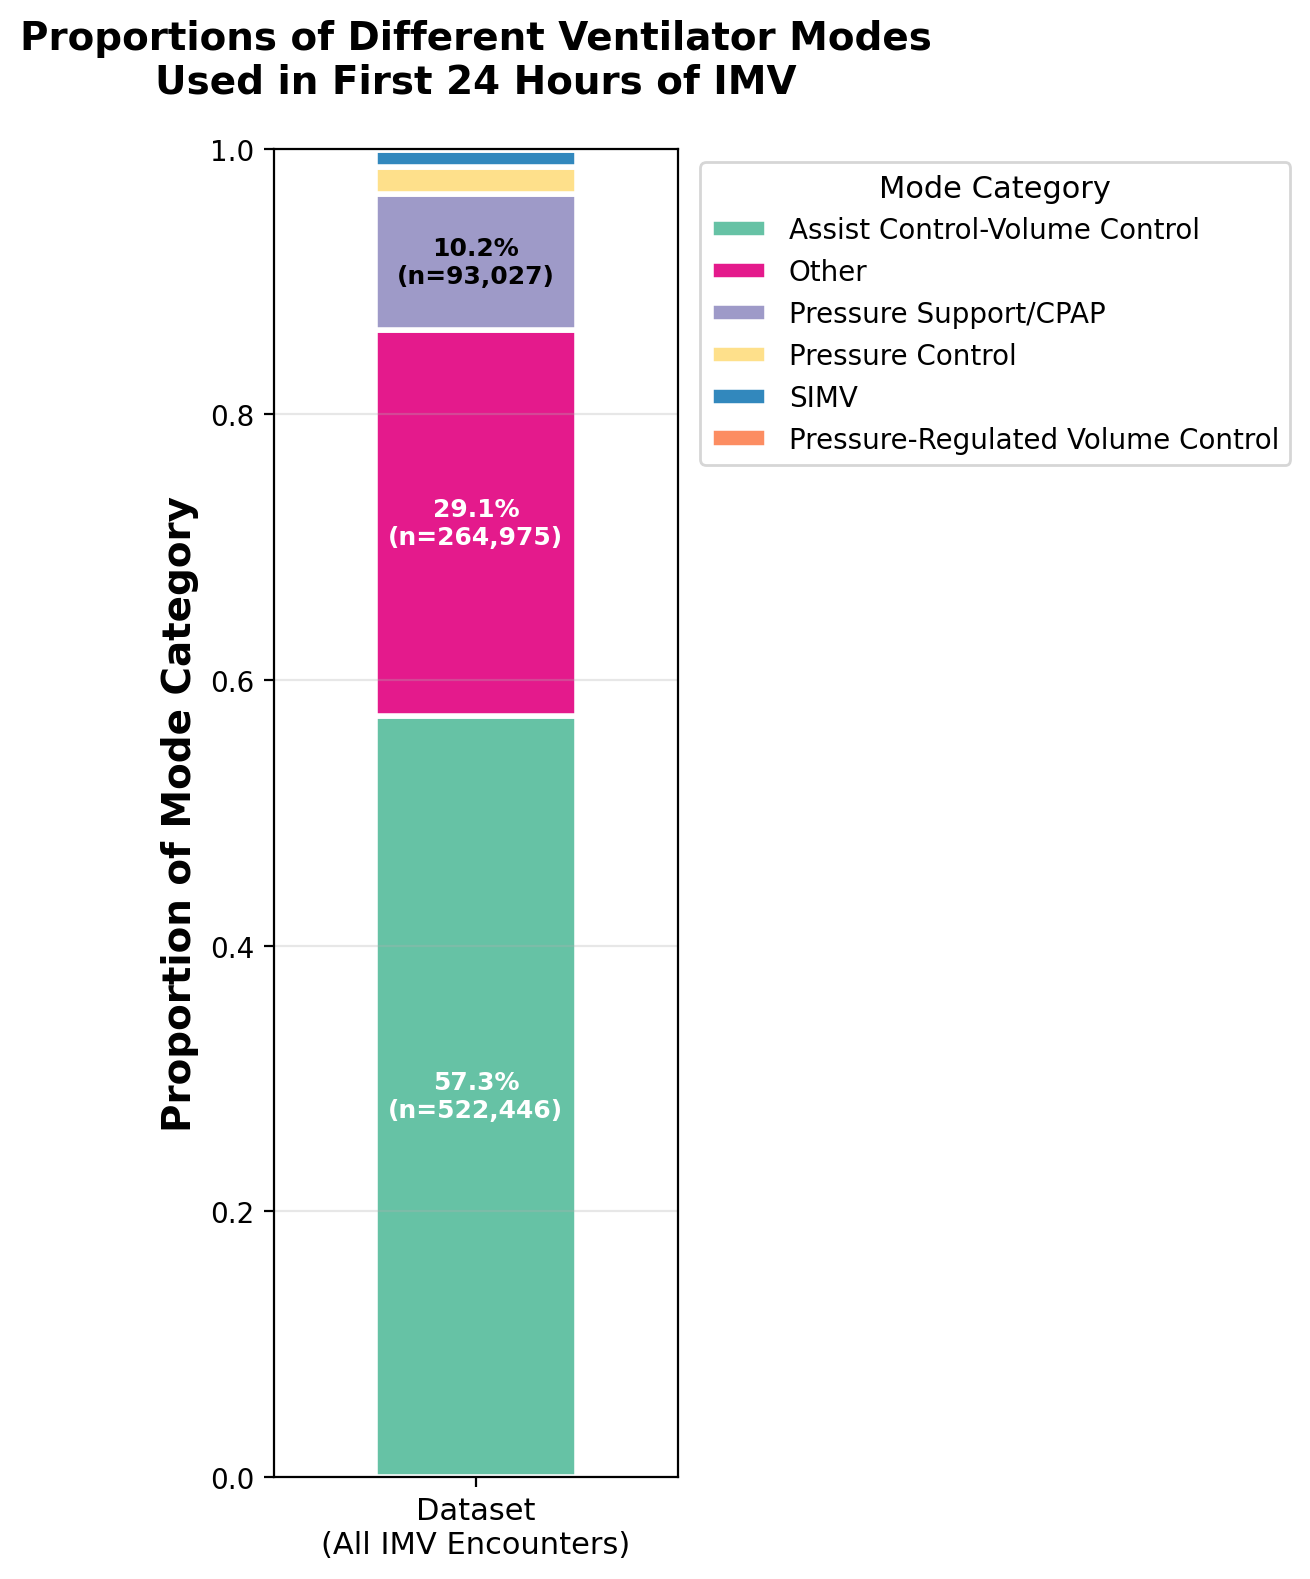

✅ Saved: ../output/final/tableone/mode_proportions_first_24h_vertical.png


In [56]:
fig, ax = plt.subplots(figsize=(6, 8))
# Define colors for each mode (matching the image)
color_map = {
    'Assist Control-Volume Control': '#66c2a5',  # Green
    'Pressure-Regulated Volume Control': '#fc8d62',  # Orange
    'SIMV': '#3288bd',  # Blue
    'Pressure Support/CPAP': '#9e9ac8',  # Purple
    'Pressure Control': '#fee08b',  # Yellow
    'Other': '#e41a8c'  # Pink/Magenta
}

# Create vertical stacked bar
bottom = 0

for idx, row in plot_data.iterrows():
    mode = row['Mode']
    proportion = row['Proportion']
    count = row['Count']
    color = color_map.get(mode, '#cccccc')
    
    ax.bar(0, proportion, bottom=bottom, width=0.5, 
          color=color, edgecolor='white', linewidth=2)
    
    # Add text label
    if proportion > 0.03:
        ax.text(0, bottom + proportion/2, f"{proportion:.1%}\n(n={count:,})", 
               ha='center', va='center', fontsize=9, fontweight='bold',
               color='white' if proportion > 0.15 else 'black')
    
    bottom += proportion

# Formatting
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(0, 1)
ax.set_ylabel('Proportion of Mode Category', fontsize=14, fontweight='bold')
ax.set_xticks([0])
ax.set_xticklabels(['Dataset\n(All IMV Encounters)'], fontsize=11)
ax.set_title('Proportions of Different Ventilator Modes\nUsed in First 24 Hours of IMV', 
            fontsize=14, fontweight='bold', pad=20)

# Create legend
legend_elements = [plt.Rectangle((0,0),1,1, fc=color_map.get(mode, '#cccccc'), 
                                edgecolor='white', linewidth=2, label=mode)
                  for mode in plot_data['Mode']]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1), 
         fontsize=10, title='Mode Category', title_fontsize=11)

# Add grid
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../output/final/tableone/mode_proportions_first_24h_vertical.png', 
           dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: ../output/final/tableone/mode_proportions_first_24h_vertical.png")


In [57]:
final_tableone_df.columns

Index(['patient_id', 'hospitalization_id', 'encounter_block', 'admission_dttm',
       'discharge_dttm', 'age_at_admission', 'discharge_category',
       'admission_type_category', 'race_category', 'ethnicity_category',
       'sex_category', 'death_dttm', 'icu_enc', 'death_enc', 'cohort_enc',
       'high_support_enc', 'vaso_support_enc', 'other_critically_ill',
       'first_icu_in_dttm', 'first_icu_out_dttm', 'first_icu_los_days',
       'min_in_dttm', 'max_out_dttm', 'first_admission_location',
       'hospital_length_of_stay_days', 'last_code_status_category', 'on_vent',
       'initial_mode_category', 'first_location_imv', 'vent_start_dttm',
       'fio2_set_median', 'lpm_set_median', 'tidal_volume_set_median',
       'resp_rate_set_median', 'pressure_control_set_median',
       'pressure_support_set_median', 'peep_set_median', 'fio2_set_q1',
       'lpm_set_q1', 'tidal_volume_set_q1', 'resp_rate_set_q1',
       'pressure_control_set_q1', 'pressure_support_set_q1', 'peep_set_q1',

# Meds

In [58]:
print(f"\nLoading medication_admin_continuous table...")
clif.load_table(
    'medication_admin_continuous',
    columns=meds_required_columns,
    filters={
        'hospitalization_id': final_hosp_ids
    }
)
clif.medication_admin_continuous.df= pd.merge(clif.medication_admin_continuous.df, encounter_mapping, 
                                        on='hospitalization_id', how='left')


print(f"   Medications loaded: {len(clif.medication_admin_continuous.df):,} rows")
print(f"   Unique medication categories: {clif.medication_admin_continuous.df['med_category'].nunique()}")
print(f"   Unique medication_admin_continuous hospitalizations: {clif.medication_admin_continuous.df['hospitalization_id'].nunique()}")

meds_df = clif.medication_admin_continuous.df


Loading medication_admin_continuous table...
📢 Initialized medication_admin_continuous table
📢 Data directory: /Users/kavenchhikara/Library/CloudStorage/Box-Box/RCLIF_data/CLIF_2018_24/WIP_2_1
📢 File type: parquet
📢 Timezone: US/Central
📢 Output directory: ../output/final/clifpy
📢 Loaded schema from /Users/kavenchhikara/Projects/CLIF/CLIF-TableOne/.venv/lib/python3.11/site-packages/clifpy/schemas/medication_admin_continuous_schema.yaml
📢 Loaded outlier configuration
   Medications loaded: 6,087,109 rows
   Unique medication categories: 58
   Unique medication_admin_continuous hospitalizations: 43153


In [59]:
# ============================================================================
# Medication Flags and Vasopressor Statistics at Encounter Block Level
# ============================================================================

print("\n" + "="*80)
print("CREATING MEDICATION FLAGS AND VASOPRESSOR STATISTICS")
print("="*80)

# Medication categories to track
med_categories = [
    'norepinephrine', 'epinephrine', 'phenylephrine', 'vasopressin', 'dopamine',
    'propofol', 'midazolam', 'lorazepam', 'dexmedetomidine', 'fentanyl',
    'vecuronium', 'rocuronium', 'cisatracurium', 'pancuronium'
]

# Vasopressors that need conversion and dose statistics
vasopressors = ['norepinephrine', 'epinephrine', 'phenylephrine', 'vasopressin', 'dopamine']

# ============================================================================
# 1. Create Binary Flags (0/1) for Each Medication
# ============================================================================

print("\n📊 Creating binary flags for medication exposure...")

# Get unique encounter_block - med_category combinations
med_encounters = meds_df[meds_df['med_category'].isin(med_categories)].groupby(
    ['encounter_block', 'med_category']
).size().reset_index(name='count')

# Pivot to create binary columns (1 if medication given, 0 if not)
med_flags = med_encounters.pivot(
    index='encounter_block',
    columns='med_category',
    values='count'
).notna().astype(int)

# Rename columns with suffix
med_flags.columns = [f'{col}_flag' for col in med_flags.columns]
med_flags = med_flags.reset_index()

print(f"✅ Created binary flags for {len(med_flags.columns)-1} medications")
print(f"   Encounters with medication data: {len(med_flags):,}")

# Show summary
for col in med_flags.columns:
    if col != 'encounter_block':
        count = med_flags[col].sum()
        pct = 100 * count / len(med_flags)
        print(f"   {col}: {count:,} encounters ({pct:.1f}%)")

# ============================================================================
# 2. Convert Vasopressor Units to mcg/kg/min
# ============================================================================

print("\n" + "="*80)
print("Converting Vasopressor Units")
print("="*80)

# Define preferred units for vasopressors
preferred_units = {
    'norepinephrine': 'mcg/kg/min',
    'epinephrine': 'mcg/kg/min',
    'phenylephrine': 'mcg/kg/min',
    'vasopressin': 'mcg/kg/min',
    'dopamine': 'mcg/kg/min'
}

print(f"Converting {len(preferred_units)} vasopressors to mcg/kg/min...")

# Convert units (uses clifpy orchestrator)
clif.convert_dose_units_for_continuous_meds(
    preferred_units=preferred_units,
    override=True, 
    save_to_table=True
)

# Get converted data
meds_converted = clif.medication_admin_continuous.df_converted.copy()

# Check conversion results
conversion_counts = clif.medication_admin_continuous.conversion_counts

print("\n=== Conversion Summary ===")
success_count = conversion_counts[conversion_counts['_convert_status'] == 'success']['count'].sum()
total_count = conversion_counts['count'].sum()
print(f"Successful conversions: {success_count:,} / {total_count:,} ({100*success_count/total_count:.1f}%)")

# Show any failed conversions
failed_conversions = conversion_counts[conversion_counts['_convert_status'] != 'success']
if len(failed_conversions) > 0:
    print(f"\n⚠️ Found {len(failed_conversions)} conversion issues:")
    print(failed_conversions[['med_category', '_clean_unit', '_convert_status', 'count']].to_string(index=False))

# ============================================================================
# 3. Calculate Median and IQR for Vasopressors (Optimized)
# ============================================================================

print("\n" + "="*80)
print("Calculating Vasopressor Dose Statistics")
print("="*80)

# Filter to vasopressors only and successfully converted doses
vaso_df = meds_converted[
    (meds_converted['med_category'].isin(vasopressors)) &
    (meds_converted['_convert_status'] == 'success')
].copy()

print(f"Vasopressor records for analysis: {len(vaso_df):,}")

# Check which vasopressors exist in data
existing_vasos = [v for v in vasopressors if v in vaso_df['med_category'].unique()]
print(f"Vasopressors found: {existing_vasos}")

# Calculate statistics for each vasopressor separately (more efficient)
vaso_stats_list = []

for vaso in existing_vasos:
    vaso_subset = vaso_df[vaso_df['med_category'] == vaso]
    
    # Calculate median, Q1, Q3 (vectorized)
    stats = vaso_subset.groupby('encounter_block')['med_dose'].agg([
        ('median', 'median'),
        ('q1', lambda x: x.quantile(0.25)),
        ('q3', lambda x: x.quantile(0.75))
    ])
    
    # Rename columns with medication prefix
    stats.columns = [f'{vaso}_{col}' for col in stats.columns]
    stats = stats.reset_index()
    
    vaso_stats_list.append(stats)
    
    print(f"   {vaso}: {len(stats):,} encounters with dose data")

# Merge all vasopressor statistics
if vaso_stats_list:
    vaso_stats = vaso_stats_list[0]
    for stats in vaso_stats_list[1:]:
        vaso_stats = vaso_stats.merge(stats, on='encounter_block', how='outer')
    
    print(f"\n✅ Calculated dose statistics for {len(existing_vasos)} vasopressors")
    print(f"   Total encounters with vasopressor data: {len(vaso_stats):,}")
else:
    vaso_stats = pd.DataFrame({'encounter_block': []})
    print("\n⚠️ No vasopressor data found for statistics")

# ============================================================================
# 4. Merge Everything to final_tableone_df
# ============================================================================

print("\n" + "="*80)
print("Merging to final_tableone_df")
print("="*80)

initial_cols = len(final_tableone_df.columns)

# Merge medication flags
final_tableone_df = final_tableone_df.merge(
    med_flags,
    on='encounter_block',
    how='left'
)

# Fill NaN with 0 for medication flags (encounters without that medication)
flag_cols = [col for col in med_flags.columns if col.endswith('_flag') and col != 'encounter_block']
for col in flag_cols:
    final_tableone_df[col] = final_tableone_df[col].fillna(0).astype(int)

print(f"✅ Added {len(flag_cols)} medication flag columns")

# Merge vasopressor statistics
if len(vaso_stats) > 0:
    final_tableone_df = final_tableone_df.merge(
        vaso_stats,
        on='encounter_block',
        how='left'
    )
    
    vaso_stat_cols = [col for col in vaso_stats.columns if col != 'encounter_block']
    print(f"✅ Added {len(vaso_stat_cols)} vasopressor dose statistic columns")

new_cols = len(final_tableone_df.columns) - initial_cols

print(f"\n✅ Total new columns added: {new_cols}")
print(f"   Final tableone columns: {len(final_tableone_df.columns)}")

# ============================================================================
# 5. Summary Report
# ============================================================================

print("\n" + "="*80)
print("MEDICATION SUMMARY")
print("="*80)

print("\n📋 Medication Flag Columns Added:")
for col in sorted(flag_cols):
    med_name = col.replace('_flag', '')
    count = final_tableone_df[col].sum()
    pct = 100 * count / len(final_tableone_df)
    print(f"   {med_name:30s}: {count:6,} encounters ({pct:5.1f}%)")

if len(vaso_stats) > 0:
    print("\n📋 Vasopressor Dose Statistics Columns Added:")
    for vaso in existing_vasos:
        median_col = f'{vaso}_median'
        if median_col in final_tableone_df.columns:
            count = final_tableone_df[median_col].notna().sum()
            print(f"   {vaso}:")
            print(f"      - {median_col}")
            print(f"      - {vaso}_q1")
            print(f"      - {vaso}_q3")
            print(f"      ({count:,} encounters with dose data)")

print("\n" + "="*80)
print("✅ MEDICATION PROCESSING COMPLETE")
print("="*80)


CREATING MEDICATION FLAGS AND VASOPRESSOR STATISTICS

📊 Creating binary flags for medication exposure...
✅ Created binary flags for 12 medications
   Encounters with medication data: 33,729
   cisatracurium_flag: 595 encounters (1.8%)
   dexmedetomidine_flag: 9,219 encounters (27.3%)
   dopamine_flag: 3,374 encounters (10.0%)
   epinephrine_flag: 4,407 encounters (13.1%)
   fentanyl_flag: 11,792 encounters (35.0%)
   lorazepam_flag: 28 encounters (0.1%)
   midazolam_flag: 1,019 encounters (3.0%)
   norepinephrine_flag: 12,736 encounters (37.8%)
   phenylephrine_flag: 16,525 encounters (49.0%)
   propofol_flag: 21,726 encounters (64.4%)
   rocuronium_flag: 34 encounters (0.1%)
   vasopressin_flag: 6,636 encounters (19.7%)

Converting Vasopressor Units
Converting 5 vasopressors to mcg/kg/min...
📢 Starting dose unit conversion for continuous medications with parameters: preferred_units={'norepinephrine': 'mcg/kg/min', 'epinephrine': 'mcg/kg/min', 'phenylephrine': 'mcg/kg/min', 'vasopress

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

📢 Initialized vitals table
📢 Data directory: /Users/kavenchhikara/Library/CloudStorage/Box-Box/RCLIF_data/CLIF_2018_24/WIP_2_1
📢 File type: parquet
📢 Timezone: US/Central
📢 Output directory: ../output/final/clifpy
📢 Loaded schema from /Users/kavenchhikara/Projects/CLIF/CLIF-TableOne/.venv/lib/python3.11/site-packages/clifpy/schemas/vitals_schema.yaml
📢 Loaded outlier configuration
📢 Starting dose unit conversion
No weight_kg column found, adding the most recent from vitals


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Cannot accommodate the conversion to the following preferred units: {'ppm', 'meq/hr', 'meq/kg/hr'}. Consult the function documentation for a list of acceptable units.
📢 Dose unit conversion completed
📢 Updating medication_admin_continuous table with converted data

=== Conversion Summary ===
Successful conversions: 5,703,631 / 6,081,758 (93.8%)

⚠️ Found 38 conversion issues:
      med_category _clean_unit                                           _convert_status  count
       alprostadil  mcg/kg/min cannot convert to a weighted unit if weight_kg is missing      5
       angiotensin   ng/kg/min cannot convert to a weighted unit if weight_kg is missing    368
        argatroban  mcg/kg/min cannot convert to a weighted unit if weight_kg is missing     30
         cangrelor  mcg/kg/min cannot convert to a weighted unit if weight_kg is missing    190
     cisatracurium  mcg/kg/min cannot convert to a weighted unit if weight_kg is missing     88
   dexmedetomidine   mcg/kg/hr cannot convert

## First 24 hrs of ICU

In [62]:
import plotly.graph_objects as go
import plotly.io as pio

# Define medication groups
med_groups = {
    'vasoactive': ['norepinephrine', 'epinephrine', 'phenylephrine', 'vasopressin', 'dopamine'],
    'sedative': ['propofol', 'midazolam', 'lorazepam', 'dexmedetomidine', 'fentanyl'],
    'paralytic': ['vecuronium', 'rocuronium', 'cisatracurium', 'pancuronium']
}

all_meds = [med for meds in med_groups.values() for med in meds]

# Merge and calculate hours from ICU (vectorized)
meds_merged = meds_df.merge(
    final_tableone_df[['encounter_block', 'first_icu_in_dttm']],
    on='encounter_block',
    how='inner'
)

meds_merged['hours_from_icu'] = (
    pd.to_datetime(meds_merged['admin_dttm']) - pd.to_datetime(meds_merged['first_icu_in_dttm'])
).dt.total_seconds() / 3600

# Filter and bin (vectorized), handle non-finite for hour_bin, avoid IntCastingNaNError
meds_merged['med_lower'] = meds_merged['med_category'].str.lower()
finite_mask = np.isfinite(meds_merged['hours_from_icu'])
meds_merged['hour_bin'] = np.nan
meds_merged.loc[finite_mask, 'hour_bin'] = np.floor(meds_merged.loc[finite_mask, 'hours_from_icu'])
meds_merged['hour_bin'] = meds_merged['hour_bin'].astype('Int64')

meds_7d = meds_merged[
    (meds_merged['med_lower'].isin(all_meds)) &
    (meds_merged['hour_bin'].notna()) &
    (meds_merged['hour_bin'] >= 0) &
    (meds_merged['hour_bin'] <= 167)
]

total_icu_encounters = final_tableone_df[final_tableone_df['icu_enc'] == 1]['encounter_block'].nunique()

# ============================================================================
#  hourly counts and percentages
# ============================================================================

pivot = (
    meds_7d
    .groupby(['hour_bin', 'med_lower'])['encounter_block']
    .nunique()
    .unstack(fill_value=0)
    .reindex(index=np.arange(168), columns=all_meds, fill_value=0)
)

pct_pivot = (pivot / total_icu_encounters * 100) if total_icu_encounters > 0 else pivot * 0

hourly_df = pd.DataFrame({'hour': np.arange(168)})
hourly_df = pd.concat([
    hourly_df,
    pivot.add_suffix('_n'),
    pct_pivot.add_suffix('_pct')
], axis=1)

hourly_df.to_csv('../output/final/tableone/medications_hourly_data.csv', index=False)
print(f"✅ Saved: ../output/final/tableone/medications_hourly_data.csv")

# ============================================================================
# Plotly plotting functions (interactive area plots)
# ============================================================================

colors = {
    'norepinephrine': '#1f77b4', 'epinephrine': '#ff7f0e', 'phenylephrine': '#2ca02c',
    'vasopressin': '#d62728', 'dopamine': '#9467bd',
    'propofol': '#e377c2', 'midazolam': '#7f7f7f', 'lorazepam': '#bcbd22', 'dexmedetomidine': '#17becf',
    'vecuronium': '#8c564b', 'rocuronium': '#f7b6d2', 'cisatracurium': '#c49c94', 'pancuronium': '#dbdb8d'
}

def hex_to_rgba(hex_color, alpha=0.2):
    """Convert hex RGB color like '#1f77b4' to 'rgba(R,G,B,A)' string."""
    hex_color = hex_color.lstrip('#')
    if len(hex_color) == 6:
        r = int(hex_color[0:2], 16)
        g = int(hex_color[2:4], 16)
        b = int(hex_color[4:6], 16)
        return f'rgba({r},{g},{b},{alpha})'
    # Fallback to gray if something is wrong
    return f'rgba(180,180,180,{alpha})'

def plotly_medication_group(group_name, meds, hourly_df, output_path_html):
    fig = go.Figure()
    hours = hourly_df['hour'].values

    for med in meds:
        pct_col = f"{med}_pct"
        if pct_col in hourly_df.columns:
            color = colors.get(med, '#333')
            fillcolor = (
                hex_to_rgba(color, 0.2)
                if color.startswith("#") and len(color) == 7
                else "rgba(180,180,180,0.15)"
            )
            fig.add_trace(
                go.Scatter(
                    x=hours,
                    y=hourly_df[pct_col],
                    mode='lines',
                    name=med.capitalize(),
                    line=dict(color=color, width=3),
                    fill='tozeroy',
                    fillcolor=fillcolor,
                    opacity=0.8,
                    hovertemplate=f"{med.capitalize()}<br>Hour: %{{x}}<br>% ICU: %{{y:.2f}}<extra></extra>"
                )
            )

    fig.update_layout(
        title=f"{group_name.capitalize()} Medication Use in First 7 Days of ICU",
        xaxis_title="Hours from ICU Admission",
        yaxis_title="% of ICU Encounters",
        xaxis=dict(range=[0, 168]),
        yaxis=dict(range=[0, None]),
        legend=dict(title="Medication", font=dict(size=12)),
        template="simple_white",
        font=dict(size=14),
        margin=dict(l=50, r=20, t=70, b=50)
    )

    # Save interactive plot as HTML
    pio.write_html(fig, output_path_html)
    fig.show()

# Generate all 3 interactive plots (save as HTML)
plotly_medication_group(
    'vasoactive', med_groups['vasoactive'], hourly_df, 
    '../output/final/tableone/vasoactive_area_curve_7d.html'
)
plotly_medication_group(
    'sedative', med_groups['sedative'], hourly_df, 
    '../output/final/tableone/sedative_area_curve_7d.html'
)
plotly_medication_group(
    'paralytic', med_groups['paralytic'], hourly_df,
    '../output/final/tableone/paralytic_area_curve_7d.html'
)

print("\n✅ All medication plots (plotly) created and saved as HTML!")


✅ Saved: ../output/final/tableone/medications_hourly_data.csv



✅ All medication plots (plotly) created and saved as HTML!


In [63]:
import plotly.graph_objects as go
import plotly.io as pio

# Define medication groups
med_groups = {
    'vasoactive': ['norepinephrine', 'epinephrine', 'phenylephrine', 'vasopressin', 'dopamine'],
    'sedative': ['propofol', 'midazolam', 'lorazepam', 'dexmedetomidine', 'fentanyl'],
    'paralytic': ['vecuronium', 'rocuronium', 'cisatracurium', 'pancuronium']
}

# Lower-cased mapping for safety
med_to_group = {med: group for group, meds in med_groups.items() for med in meds}
all_meds = [med for meds in med_groups.values() for med in meds]

# Merge and preprocess (same as before)
meds_merged = meds_df.merge(
    final_tableone_df[['encounter_block', 'first_icu_in_dttm']],
    on='encounter_block',
    how='inner'
)

meds_merged['hours_from_icu'] = (
    pd.to_datetime(meds_merged['admin_dttm']) - pd.to_datetime(meds_merged['first_icu_in_dttm'])
).dt.total_seconds() / 3600

meds_merged['med_lower'] = meds_merged['med_category'].str.lower()
finite_mask = np.isfinite(meds_merged['hours_from_icu'])
meds_merged['hour_bin'] = np.nan
meds_merged.loc[finite_mask, 'hour_bin'] = np.floor(meds_merged.loc[finite_mask, 'hours_from_icu'])
meds_merged['hour_bin'] = meds_merged['hour_bin'].astype('Int64')

meds_7d = meds_merged[
    (meds_merged['med_lower'].isin(all_meds)) &
    (meds_merged['hour_bin'].notna()) &
    (meds_merged['hour_bin'] >= 0) &
    (meds_merged['hour_bin'] <= 167)
].copy()

# =======================
# Line plot: median dose by hour since ICU admission (per med group)
# =======================

colors = {
    'norepinephrine': '#1f77b4', 'epinephrine': '#ff7f0e', 'phenylephrine': '#2ca02c',
    'vasopressin': '#d62728', 'dopamine': '#9467bd',
    'propofol': '#e377c2', 'midazolam': '#7f7f7f', 'lorazepam': '#bcbd22', 'dexmedetomidine': '#17becf',
    'vecuronium': '#8c564b', 'rocuronium': '#f7b6d2', 'cisatracurium': '#c49c94', 'pancuronium': '#dbdb8d'
}

def plot_median_dose_line_by_hour(group_name, meds, meds_7d, output_path_html):
    fig = go.Figure()
    for med in meds:
        med_data = meds_7d[meds_7d['med_lower'] == med]
        # For each hour, compute the median dose (across all encounters)
        hourly_median = (
            med_data.groupby('hour_bin')['med_dose']
            .median()
            .reset_index()
            .sort_values('hour_bin')
        )
        color = colors.get(med, '#333')
        if not hourly_median.empty:
            fig.add_trace(
                go.Scatter(
                    x=hourly_median['hour_bin'],
                    y=hourly_median['med_dose'],
                    mode='lines+markers',
                    name=med.capitalize(),
                    line=dict(color=color, width=3),
                    marker=dict(size=6),
                    hovertemplate=f"{med.capitalize()}<br>Hour: %{{x}}<br>Median Dose: %{{y:.2f}}<extra></extra>"
                )
            )
    fig.update_layout(
        title=f"Median {group_name.capitalize()} Dose by Hour Since ICU Admission",
        xaxis_title="Hours from ICU Admission",
        yaxis_title="Median Dose",
        legend=dict(title="Medication", font=dict(size=12)),
        template="simple_white",
        font=dict(size=14),
        margin=dict(l=50, r=20, t=70, b=50),
        xaxis=dict(range=[0, 168])
    )
    pio.write_html(fig, output_path_html)
    fig.show()

# Generate and save plots for each medication group (lines: median dose over time)
plot_median_dose_line_by_hour(
    'vasoactive', med_groups['vasoactive'], meds_7d,
    '../output/final/tableone/vasoactive_median_dose_by_hour.html'
)
plot_median_dose_line_by_hour(
    'sedative', med_groups['sedative'], meds_7d,
    '../output/final/tableone/sedative_median_dose_by_hour.html'
)
plot_median_dose_line_by_hour(
    'paralytic', med_groups['paralytic'], meds_7d,
    '../output/final/tableone/paralytic_median_dose_by_hour.html'
)

print("\n✅ All median dose line plots by hour (plotly) created and saved as HTML!")



✅ All median dose line plots by hour (plotly) created and saved as HTML!


In [64]:
# ============================================================================
#  summary statistics
# ============================================================================

# Group by medication once, calculate all stats on med_dose
summary_agg = (
    meds_7d
    .groupby('med_lower')['med_dose']
    .agg(['count', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
    .rename(columns={'count': 'n_admin', '<lambda_0>': 'q1_dose', '<lambda_1>': 'q3_dose'})
)

# Count unique encounters per medication
encounter_counts = meds_7d.groupby('med_lower')['encounter_block'].nunique()

# Get most common dose unit per medication
dose_units = meds_7d.groupby('med_lower')['med_dose_unit'].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else '')

# Combine and add group labels
summary_df = pd.DataFrame({
    'medication': summary_agg.index,
    'n_encounters': encounter_counts.values,
    'pct_encounters': (encounter_counts / total_icu_encounters * 100).values,
    'median_dose': summary_agg['median'].values,
    'q1_dose': summary_agg['q1_dose'].values,
    'q3_dose': summary_agg['q3_dose'].values,
    'dose_unit': dose_units.values
})

# Add group labels (vectorized with map)
med_to_group = {med: group for group, meds in med_groups.items() for med in meds}
summary_df['group'] = summary_df['medication'].map(med_to_group)
summary_df = summary_df[['group', 'medication', 'n_encounters', 'pct_encounters', 
                         'median_dose', 'q1_dose', 'q3_dose', 'dose_unit']]

summary_df.to_csv('../output/final/tableone/medications_summary_stats.csv', index=False)
print(f"✅ Saved: ../output/final/tableone/medications_summary_stats.csv")

✅ Saved: ../output/final/tableone/medications_summary_stats.csv


# Labs

In [65]:
# ----------------------------------------------------------------------------
# Load Labs
# ----------------------------------------------------------------------------
print(f"\nLoading labs table...")
clif.load_table(
    'labs',
    columns=['hospitalization_id', 'lab_result_dttm', 'lab_category', 'lab_value_numeric', 'reference_unit'],
    filters={
        'hospitalization_id': final_hosp_ids
    }
)
clif.labs.df= pd.merge(clif.labs.df, encounter_mapping, 
                                        on='hospitalization_id', how='left')


print("Applying outlier handling to Labs data...")
print("=" * 50)
get_value_counts(clif.labs, ['lab_name', 'lab_category', 'lab_loinc_code'], output_dir=mcide_dir)
# get_value_counts(clif.labs, ['lab_specimen_name', 'lab_specimen_category'], output_dir=mcide_dir)
apply_outlier_handling(clif.labs)
create_summary_table(clif.labs, 'lab_value_numeric',group_by_cols='lab_category',
                    output_dir=summary_stats_dir)
create_summary_table(clif.labs, 'lab_value_numeric',group_by_cols=['lab_category', 'reference_unit'],
                    output_dir=summary_stats_dir)



Loading labs table...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

📢 Initialized labs table
📢 Data directory: /Users/kavenchhikara/Library/CloudStorage/Box-Box/RCLIF_data/CLIF_2018_24/WIP_2_1
📢 File type: parquet
📢 Timezone: US/Central
📢 Output directory: ../output/final/clifpy
📢 Loaded schema from /Users/kavenchhikara/Projects/CLIF/CLIF-TableOne/.venv/lib/python3.11/site-packages/clifpy/schemas/labs_schema.yaml
📢 Loaded outlier configuration
Applying outlier handling to Labs data...
Using CLIF standard outlier ranges

Building outlier expressions...


Building expressions: 100%|██████████| 1/1 [00:00<00:00, 868.75column/s]


Applying outlier filtering...


Processing: 100%|██████████| 1/1 [00:02<00:00,  2.32s/operation]



Labs Table - Category Statistics:
  albumin             : 292868 values →     41 nullified (  0.0%)
  alkaline_phosphatase: 270149 values →     45 nullified (  0.0%)
  alt                 : 271661 values →     38 nullified (  0.0%)
  ast                 : 267385 values →     87 nullified (  0.0%)
  basophils_absolute  : 139108 values →      2 nullified (  0.0%)
  basophils_percent   : 148018 values →      1 nullified (  0.0%)
  beta_hydroxubutrate :  19183 values →      0 nullified (  0.0%)
  bicarbonate         : 883470 values →     82 nullified (  0.0%)
  bilirubin_conjugated: 182439 values →     35 nullified (  0.0%)
  bilirubin_total     : 274744 values →     42 nullified (  0.0%)
  bilirubin_unconjugated: 156808 values →     41 nullified (  0.0%)
  bun                 : 902408 values →    128 nullified (  0.0%)
  calcium_ionized     :  20218 values →      2 nullified (  0.0%)
  calcium_total       : 1009433 values →     72 nullified (  0.0%)
  chloride            : 1043222 values

lab_category reference_unit           variable        N  \
0                  albumin           g/dL  lab_value_numeric   292827   
1     alkaline_phosphatase            U/L  lab_value_numeric   270104   
2                      alt            U/L  lab_value_numeric   271623   
3                      ast            U/L  lab_value_numeric   267298   
4       basophils_absolute        10^3/uL  lab_value_numeric   139106   
5        basophils_percent              %  lab_value_numeric   148017   
6      beta_hydroxubutrate         mmol/L  lab_value_numeric    19183   
7              bicarbonate         mmol/L  lab_value_numeric   883388   
8     bilirubin_conjugated          mg/dL  lab_value_numeric   182404   
9          bilirubin_total          mg/dL  lab_value_numeric   274702   
10  bilirubin_unconjugated          mg/dL  lab_value_numeric   156767   
11                     bun          mg/dL  lab_value_numeric   902280   
12         calcium_ionized          mg/dL  lab_value_numeric    20216   
13           calcium_total          mg/dL  lab_value_numeric  1009361   
14                chloride         mmol/L  lab_value_numeric  1043083   
15              creatinine          mg/dL  lab_value_numeric   916330   
16                     crp           mg/L  lab_value_numeric    34374   
17    eosinophils_absolute        10^3/uL  lab_value_numeric   139505   
18     eosinophils_percent              %  lab_value_numeric   140788   
19                     esr        mm/hour  lab_value_numeric     9809   
20                ferritin          ng/mL  lab_value_numeric    22672   
21     glucose_fingerstick          mg/dL  lab_value_numeric  1516910   
22    glucose_mixed_venous          mg/dL  lab_value_numeric      131   
23           glucose_serum          mg/dL  lab_value_numeric   911404   
24              hemoglobin           g/dL  lab_value_numeric  1181273   
25                 lactate         mmol/L  lab_value_numeric   352701   
26                     ldh            U/L  lab_value_numeric    44065   
27                     ldh         [iU]/L  lab_value_numeric     2450   
28                  lipase            U/L  lab_value_numeric    13841   
29    lymphocytes_absolute        10^3/uL  lab_value_numeric   140658   
30     lymphocytes_percent              %  lab_value_numeric   141717   
31               magnesium          mg/dL  lab_value_numeric   748046   
32      monocytes_absolute        10^3/uL  lab_value_numeric   140662   
33       monocytes_percent              %  lab_value_numeric   141633   
34    neutrophils_absolute        10^3/uL  lab_value_numeric   140539   
35     neutrophils_percent              %  lab_value_numeric   145858   
36           pco2_arterial           mmHg  lab_value_numeric   687786   
37             pco2_venous           mmHg  lab_value_numeric   262337   
38               phosphate          mg/dL  lab_value_numeric   746855   
39          platelet_count        10^3/uL  lab_value_numeric   754856   
40            po2_arterial           mmHg  lab_value_numeric   717529   
41               potassium         mmol/L  lab_value_numeric   943957   
42                      pt            sec  lab_value_numeric   303597   
43                     ptt            sec  lab_value_numeric   342262   
44                     rdw              %  lab_value_numeric   552422   
45            so2_arterial              %  lab_value_numeric   469205   
46      so2_central_venous              %  lab_value_numeric    18717   
47        so2_mixed_venous              %  lab_value_numeric    42104   
48                  sodium         mmol/L  lab_value_numeric  1044224   
49      sodium_bicarbonate         mmol/L  lab_value_numeric    51966   
50           total_protein           g/dL  lab_value_numeric   274809   
51              troponin_t           ng/L  lab_value_numeric   104572   
52                     wbc        10^3/uL  lab_value_numeric   747431   

    missing      min     q25  median         q75         mean        ma

# Comorbidity Index

In [66]:
print(f"\nLoading vitals table...")
clif.load_table(
    'hospital_diagnosis',
    filters={
        'hospitalization_id': final_hosp_ids
    }
)


Loading vitals table...
📢 Initialized hospital_diagnosis table
📢 Data directory: /Users/kavenchhikara/Library/CloudStorage/Box-Box/RCLIF_data/CLIF_2018_24/WIP_2_1
📢 File type: parquet
📢 Timezone: US/Central
📢 Output directory: ../output/final/clifpy
📢 Loaded schema from /Users/kavenchhikara/Projects/CLIF/CLIF-TableOne/.venv/lib/python3.11/site-packages/clifpy/schemas/hospital_diagnosis_schema.yaml
📢 Loaded outlier configuration


In [67]:
from clifpy.utils.comorbidity import calculate_cci
cci_results = calculate_cci( clif.hospital_diagnosis, hierarchy=True)

name: "Charlson Comorbidity Index"
version: "quan"
supported_formats:
  - ICD10CM


Mapping ICD codes to CCI conditions: 100%|██████████| 17/17 [00:00<00:00, 16410.40it/s]


In [68]:
cci_results = (
    cci_results.merge(encounter_mapping, on="hospitalization_id")
    .drop(columns=["hospitalization_id"])
    .drop_duplicates()
)
# Join with final_tableone_df on encounter_block
final_tableone_df = final_tableone_df.merge(cci_results, on="encounter_block", how="left")
final_tableone_df.columns

Index(['patient_id', 'hospitalization_id', 'encounter_block', 'admission_dttm',
       'discharge_dttm', 'age_at_admission', 'discharge_category',
       'admission_type_category', 'race_category', 'ethnicity_category',
       ...
       'mild_liver_disease', 'diabetes_uncomplicated',
       'diabetes_with_complications', 'hemiplegia', 'renal_disease', 'cancer',
       'moderate_severe_liver_disease', 'metastatic_solid_tumor', 'aids',
       'cci_score'],
      dtype='object', length=107)

Total hospitalizations: 50,028

Comorbidity table saved to: ../output/final/tableone/comorbidities_per_1000_hospitalizations.csv
Summary statistics saved to: ../output/final/tableone/comorbidities_per_1000_hospitalizations_summary.csv


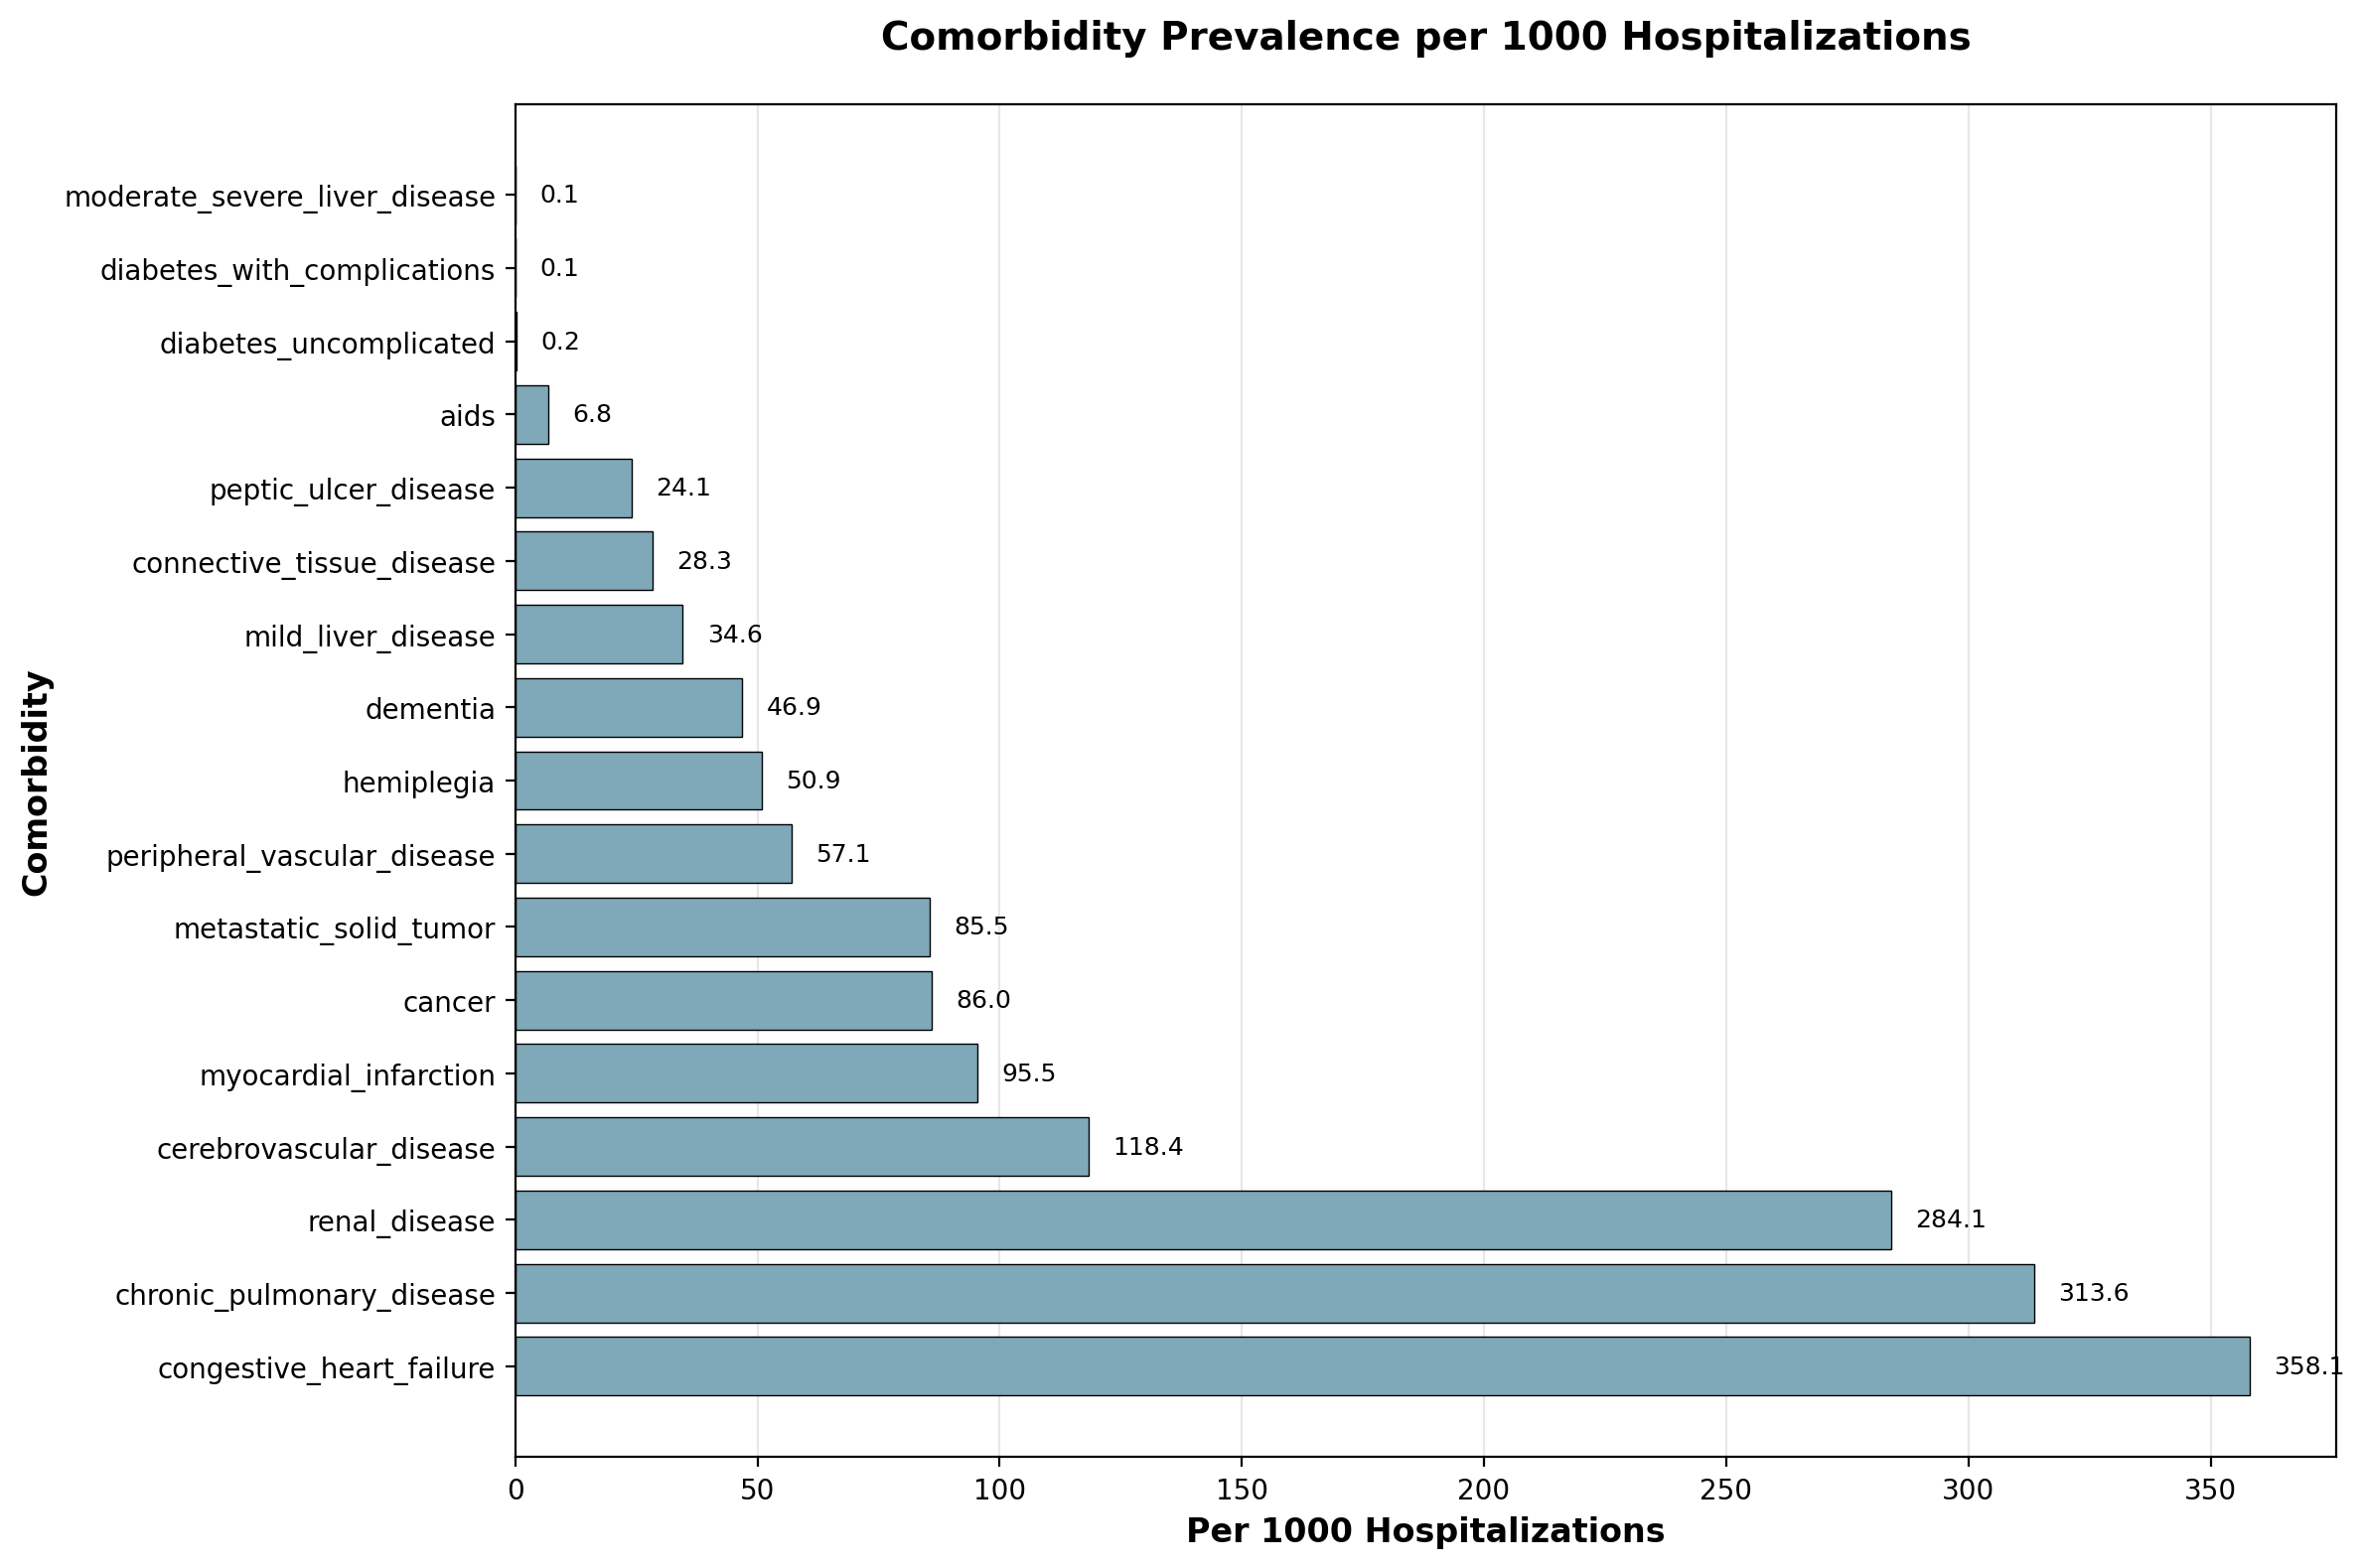

In [69]:
# Calculate comorbidities per 1000 hospitalizations, and save results WITH statistical summaries in CSV
# Step 1: Get the total number of unique hospitalizations
total_hospitalizations = cci_results['encounter_block'].nunique()
print(f"Total hospitalizations: {total_hospitalizations:,}")

# Step 2: Define the comorbidity columns (exclude IDs and total score)
exclude_columns = {'hospitalization_id', 'encounter_block', 'cci_score'}
comorbidity_columns = [col for col in cci_results.columns if col not in exclude_columns]

# Step 3: Calculate the count of each comorbidity (assume binary indicators)
comorbidity_counts = cci_results[comorbidity_columns].sum()

# Step 4: Compute prevalence rates
comorbidity_per_1000 = (comorbidity_counts / total_hospitalizations) * 1000
prevalence_percent = (comorbidity_counts.values / total_hospitalizations * 100).round(2)

# Step 5: Create a summary dataframe
comorbidity_summary = pd.DataFrame({
    'comorbidity': comorbidity_columns,
    'n_patients': comorbidity_counts.values,
    'prevalence_percent': prevalence_percent,
    'per_1000_hospitalizations': comorbidity_per_1000.values.round(1)
})

# Sort by per 1000 prevalence
comorbidity_summary = comorbidity_summary.sort_values('per_1000_hospitalizations', ascending=False).reset_index(drop=True)

# Step 6: Prepare summary statistics for output
total_comorbidities = int(comorbidity_counts.sum())
avg_comorbidities_per_hosp = total_comorbidities / total_hospitalizations if total_hospitalizations > 0 else 0
most_common_comorbidity = comorbidity_summary.iloc[0]['comorbidity']
most_common_per_1000 = comorbidity_summary.iloc[0]['per_1000_hospitalizations']

# Step 7: Save both table and summary statistics to CSV

# First, write the comorbidity table to CSV
out_csv = '../output/final/tableone/comorbidities_per_1000_hospitalizations.csv'
comorbidity_summary.to_csv(out_csv, index=False)

# Write summary statistics to a second csv, and then append to same file as lines at the end

summary_stats = [
    ['Total hospitalizations', total_hospitalizations],
    ['Total comorbidities across all patients', total_comorbidities],
    ['Average comorbidities per hospitalization', f"{avg_comorbidities_per_hosp:.2f}"],
    ['Most common comorbidity', most_common_comorbidity],
    ['Most common: per 1000 hospitalizations', f"{most_common_per_1000:.1f}"],
]

# Save the summary stats to a separate CSV for clarity (and also appending to the main comorbidity file for convenience)
summary_csv = '../output/final/tableone/comorbidities_per_1000_hospitalizations_summary.csv'
with open(summary_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Metric', 'Value'])
    for row in summary_stats:
        writer.writerow(row)

print(f"\nComorbidity table saved to: {out_csv}")
print(f"Summary statistics saved to: {summary_csv}")

# Step 8: Bar plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(
    comorbidity_summary['comorbidity'], 
    comorbidity_summary['per_1000_hospitalizations'],
    color='#7FA8B8',
    edgecolor='black',
    linewidth=0.5
)

ax.set_xlabel('Per 1000 Hospitalizations', fontsize=12, fontweight='bold')
ax.set_ylabel('Comorbidity', fontsize=12, fontweight='bold')
ax.set_title('Comorbidity Prevalence per 1000 Hospitalizations', fontsize=14, fontweight='bold', pad=20)

# Add value labels
for i, (idx, row) in enumerate(comorbidity_summary.iterrows()):
    ax.text(row['per_1000_hospitalizations'] + 5, i, f"{row['per_1000_hospitalizations']:.1f}", va='center', fontsize=9)

ax.grid(axis='x', linestyle='-', alpha=0.3)
ax.set_axisbelow(True)
plt.tight_layout()
plt.savefig('../output/final/tableone/comorbidities_per_1000_barplot.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# ECMO

In [70]:
print(f"\nLoading ECMO table...")
try:
    clif.load_table(
        'ecmo_mcs',
        filters={
            'hospitalization_id': final_hosp_ids
        }
    )
    clif.ecmo_mcs.df = pd.merge(
        clif.ecmo_mcs.df,
        encounter_mapping,
        on='hospitalization_id',
        how='left'
    )
    # Add on_ecmo = 1 for all encounter blocks in this df
    clif.ecmo_mcs.df['on_ecmo'] = 1
    # Keep only encounter_block and on_ecmo
    ecmo_df = clif.ecmo_mcs.df[['encounter_block', 'on_ecmo']].drop_duplicates()
    # Join with final_tableone_df on encounter_block (left join)
    final_tableone_df = final_tableone_df.merge(ecmo_df, on='encounter_block', how='left')
    # Optionally fill NaN with 0 if you want on_ecmo=0 for non-ECMO
    final_tableone_df['on_ecmo'] = final_tableone_df['on_ecmo'].fillna(0).astype(int)
    get_value_counts(clif.ecmo_mcs, ['device_name', 'device_category'], output_dir=mcide_dir)
    create_summary_table(clif.ecmo_mcs, 
                            ['device_rate', 'sweep', 'fdO2','flow'],
                            group_by_cols='device_category',
                            output_dir=summary_stats_dir)
except FileNotFoundError as e:
    print(f"Warning: Failed to load the ECMO table: {e}. Proceeding without ECMO data.")



Loading ECMO table...


# CRRT Therapy

In [71]:
print(f"\nLoading crrt_therapy table...")
try:
    clif.load_table(
        'crrt_therapy',
        filters={
            'hospitalization_id': final_hosp_ids
        }
    )
    clif.crrt_therapy.df = pd.merge(
        clif.crrt_therapy.df,
        encounter_mapping,
        on='hospitalization_id',
        how='left'
    )
    clif.crrt_therapy.df['on_crrt'] = 1
    # Keep only encounter_block and on_crrt
    on_crrt_df = clif.crrt_therapy.df[['encounter_block', 'on_crrt']].drop_duplicates()
    # Join with final_tableone_df on encounter_block (left join)
    final_tableone_df = final_tableone_df.merge(on_crrt_df, on='encounter_block', how='left')
    # Before proceeding, ensure 'on_crrt' column exists after the merge; if not, create it
    if 'on_crrt' not in final_tableone_df.columns:
        final_tableone_df['on_crrt'] = 0
    else:
        final_tableone_df['on_crrt'] = final_tableone_df['on_crrt'].fillna(0).astype(int)
    get_value_counts(clif.crrt_therapy, ['crrt_mode_name', 'crrt_mode_category'], output_dir=mcide_dir)
    create_summary_table(clif.crrt_therapy, 
                            ['blood_flow_rate', 'pre_filter_replacement_fluid_rate', 'post_filter_replacement_fluid_rate',
                                'dialysate_flow_rate', 'ultrafiltration_out'],
                            group_by_cols='crrt_mode_category',
                            output_dir=summary_stats_dir)
except FileNotFoundError as e:
    print(f"Warning: Failed to load the ECMO table: {e}. Proceeding without ECMO data.")



Loading crrt_therapy table...
📢 Initialized crrt_therapy table
📢 Data directory: /Users/kavenchhikara/Library/CloudStorage/Box-Box/RCLIF_data/CLIF_2018_24/WIP_2_1
📢 File type: parquet
📢 Timezone: US/Central
📢 Output directory: ../output/final/clifpy
📢 Loaded schema from /Users/kavenchhikara/Projects/CLIF/CLIF-TableOne/.venv/lib/python3.11/site-packages/clifpy/schemas/crrt_therapy_schema.yaml
📢 Loaded outlier configuration


/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_52347/45759005.py:108: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



# Patient Assessments

In [72]:
print(f"\nLoading patient_assessments table...")
try:
    clif.load_table(
        'patient_assessments',
        filters={
            'hospitalization_id': final_hosp_ids
        }
    )
    clif.patient_assessments.df = pd.merge(
        clif.patient_assessments.df,
        encounter_mapping,
        on='hospitalization_id',
        how='left'
    )
    get_value_counts(clif.patient_assessments, ['assessment_name', 'assessment_category'], output_dir=mcide_dir)
except FileNotFoundError as e:
    print(f"Warning: Failed to load the ECMO table: {e}. Proceeding without ECMO data.")


Loading patient_assessments table...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

📢 Initialized patient_assessments table
📢 Data directory: /Users/kavenchhikara/Library/CloudStorage/Box-Box/RCLIF_data/CLIF_2018_24/WIP_2_1
📢 File type: parquet
📢 Timezone: US/Central
📢 Output directory: ../output/final/clifpy
📢 Loaded schema from /Users/kavenchhikara/Projects/CLIF/CLIF-TableOne/.venv/lib/python3.11/site-packages/clifpy/schemas/patient_assessments_schema.yaml
📢 Loaded outlier configuration


# Number of clinical events

In [73]:
clif.get_loaded_tables()

['patient',
 'hospitalization',
 'adt',
 'labs',
 'vitals',
 'medication_admin_continuous',
 'patient_assessments',
 'respiratory_support',
 'hospital_diagnosis',
 'crrt_therapy',
 'code_status']

In [74]:
def count_clinical_events(clif_table, composite_key_fields, verbose=True):
    """
    Count unique clinical events in a CLIF table based on composite key.
    
    A clinical event is defined as a unique combination of the composite key fields,
    with all fields non-null.
    
    Parameters:
    -----------
    clif_table : CLIFTable object
        The CLIF table object (e.g., clif.vitals, clif.labs, clif.medication_admin_continuous)
    composite_key_fields : list of str
        List of column names that form the composite key.
        Example: ['hospitalization_id', 'recorded_dttm', 'vital_category']
    verbose : bool, default=True
        If True, print summary statistics
        
    Returns:
    --------
    dict with keys:
        - 'n_events': Number of unique non-null clinical events
        - 'n_total_rows': Total rows in table
        - 'n_rows_with_nulls': Rows with null values in composite key
        - 'n_valid_rows': Rows with all composite key fields non-null
        - 'pct_valid': Percentage of rows that are valid
        
    Example:
    --------
    >>> # Count unique vital sign measurements
    >>> result = count_clinical_events(
    ...     clif.vitals, 
    ...     ['hospitalization_id', 'recorded_dttm', 'vital_category']
    ... )
    >>> print(f"Unique vital measurements: {result['n_events']:,}")
    """
    # Get dataframe
    df = clif_table.df
    table_name = clif_table.__class__.__name__
    
    # Check that all composite key fields exist
    missing_fields = [f for f in composite_key_fields if f not in df.columns]
    if missing_fields:
        raise ValueError(f"Fields not found in {table_name}: {missing_fields}")
    
    # Total rows
    n_total = len(df)
    
    # Drop rows where ANY composite key field is null
    df_valid = df.dropna(subset=composite_key_fields)
    n_valid = len(df_valid)
    n_with_nulls = n_total - n_valid
    
    # Count unique combinations of composite key fields (clinical events)
    n_events = df_valid[composite_key_fields].drop_duplicates().shape[0]
    
    # Calculate percentage
    pct_valid = 100 * n_valid / n_total if n_total > 0 else 0
    
    # Prepare results
    results = {
        'n_events': n_events,
        'n_total_rows': n_total,
        'n_rows_with_nulls': n_with_nulls,
        'n_valid_rows': n_valid,
        'pct_valid': pct_valid
    }
    
    # Print summary if verbose
    if verbose:
        print(f"\n{'='*80}")
        print(f"Clinical Events Count: {table_name}")
        print(f"{'='*80}")
        print(f"Composite key: {composite_key_fields}")
        print(f"\nTotal rows in table:        {n_total:>12,}")
        print(f"Rows with null in key:      {n_with_nulls:>12,} ({100*n_with_nulls/n_total:.1f}%)")
        print(f"Valid rows (non-null key):  {n_valid:>12,} ({pct_valid:.1f}%)")
        print(f"Unique clinical events:     {n_events:>12,}")
        print(f"{'='*80}")
    
    return results
    
def count_all_clinical_events(clif_obj):
    """
    Count clinical events for all common CLIF tables.
    
    Parameters:
    -----------
    clif_obj : CLIF object
        The main CLIF object containing all tables
        
    Returns:
    --------
    pd.DataFrame : Summary of clinical events for all tables
    """
    tables_config = {
        'vitals': ['hospitalization_id', 'recorded_dttm', 'vital_category'],
        'labs': ['hospitalization_id', 'lab_result_dttm', 'lab_category'],
        'medication_admin_continuous': ['hospitalization_id', 'admin_dttm', 'med_category'],
        'respiratory_support': ['hospitalization_id', 'recorded_dttm'],
        'adt': ['hospitalization_id', 'in_dttm'],
        'patient_assessments': ['hospitalization_id', 'recorded_dttm', 'assessment_category'],
        'ecmo_mcs': ['hospitalization_id', 'recorded_dttm', 'device_category'],
        'crrt_therapy' : ['hospitalization_id', 'recorded_dttm', 'crrt_mode_category'],
    }
    
    results = []
    
    for table_name, composite_key in tables_config.items():
        if hasattr(clif_obj, table_name):
            table = getattr(clif_obj, table_name)
            if hasattr(table, 'df') and len(table.df) > 0:
                result = count_clinical_events(table, composite_key, verbose=False)
                results.append({
                    'table': table_name,
                    'composite_key': str(composite_key),
                    'n_events': result['n_events'],
                    'n_total_rows': result['n_total_rows'],
                    'pct_valid': result['pct_valid']
                })
    
    summary_df = pd.DataFrame(results)
    
    print("\n" + "="*80)
    print("CLINICAL EVENTS SUMMARY - ALL TABLES")
    print("="*80)
    print(summary_df.to_string(index=False))
    print("="*80)
    
    return summary_df

# Run batch summary
events_summary = count_all_clinical_events(clif)


CLINICAL EVENTS SUMMARY - ALL TABLES
                      table                                                  composite_key  n_events  n_total_rows  pct_valid
                     vitals      ['hospitalization_id', 'recorded_dttm', 'vital_category']  92384922      95486416      100.0
                       labs      ['hospitalization_id', 'lab_result_dttm', 'lab_category']  20899164      22143900      100.0
medication_admin_continuous           ['hospitalization_id', 'admin_dttm', 'med_category']   6081758       6087109      100.0
        respiratory_support                        ['hospitalization_id', 'recorded_dttm']   5416339       5416579      100.0
                        adt                              ['hospitalization_id', 'in_dttm']    425067        425067      100.0
        patient_assessments ['hospitalization_id', 'recorded_dttm', 'assessment_category']  19886007      19886898      100.0
               crrt_therapy  ['hospitalization_id', 'recorded_dttm', 'crrt_mode_

# SOFA calculation

In [75]:
print("Initializing ClifOrchestrator for SOFA computation...")
co = ClifOrchestrator(
    data_directory=config['tables_path'],
    filetype=config['file_type'],
    timezone=config['timezone'],
    output_directory=clifpy_dir
)
print("✅ ClifOrchestrator initialized")

# Filter to icu_enc == 1
sofa_cohort_df = final_tableone_df[final_tableone_df['icu_enc'] == 1][['hospitalization_id', 'encounter_block', 'icu_enc', 'first_icu_in_dttm']]
sofa_cohort_df['start_time'] = sofa_cohort_df['first_icu_in_dttm']
sofa_cohort_df['end_time'] = sofa_cohort_df['start_time'] + pd.Timedelta(hours=24)
sofa_cohort_df= sofa_cohort_df[['hospitalization_id', 'encounter_block', 'start_time', 'end_time']]
sofa_cohort_ids = cohort_df['hospitalization_id'].astype(str).unique().tolist()


# Load required tables for SOFA computation with cohort filtering
print("Loading required tables for SOFA computation...")
print("SOFA requires: Labs (creatinine, platelet_count, po2_arterial, bilirubin_total)")
print("               Vitals (map, spo2)")
print("               Assessments (gcs_total)")
print("               Medications (norepinephrine, epinephrine, dopamine, dobutamine)")
print("               Respiratory (device_category, fio2_set)")

# Define columns to load for each table (optimize memory usage)
sofa_columns = {
    'labs': ['hospitalization_id', 'lab_result_dttm', 'lab_category', 'lab_value', 'lab_value_numeric'],
    'vitals': ['hospitalization_id', 'recorded_dttm', 'vital_category', 'vital_value'],
    'patient_assessments': ['hospitalization_id', 'recorded_dttm', 'assessment_category', 'numerical_value', 'categorical_value'],
    'medication_admin_continuous': None,  # Load all columns
    'respiratory_support': None  # Load all columns
}

sofa_tables = ['labs', 'vitals', 'patient_assessments', 'medication_admin_continuous', 'respiratory_support']

for table_name in sofa_tables:
    table_cols = sofa_columns.get(table_name)
    print(f"Loading {table_name} with {len(table_cols) if table_cols else 'all'} columns and {len(sofa_cohort_ids)} hospitalization filters...")
    co.load_table(
        table_name,
        filters={'hospitalization_id': sofa_cohort_ids},
        columns=table_cols
    )

co.encounter_mapping = encounter_mapping[encounter_mapping['hospitalization_id'].isin(cohort_df['hospitalization_id'])]
print("✅ All required tables loaded for SOFA computation")

Initializing ClifOrchestrator for SOFA computation...
📢 ClifOrchestrator initialized
✅ ClifOrchestrator initialized
Loading required tables for SOFA computation...
SOFA requires: Labs (creatinine, platelet_count, po2_arterial, bilirubin_total)
               Vitals (map, spo2)
               Assessments (gcs_total)
               Medications (norepinephrine, epinephrine, dopamine, dobutamine)
               Respiratory (device_category, fio2_set)
Loading labs with 5 columns and 57160 hospitalization filters...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

📢 Initialized labs table
📢 Data directory: /Users/kavenchhikara/Library/CloudStorage/Box-Box/RCLIF_data/CLIF_2018_24/WIP_2_1
📢 File type: parquet
📢 Timezone: US/Central
📢 Output directory: ../output/final/clifpy
📢 Loaded schema from /Users/kavenchhikara/Projects/CLIF/CLIF-TableOne/.venv/lib/python3.11/site-packages/clifpy/schemas/labs_schema.yaml
📢 Loaded outlier configuration
Loading vitals with 4 columns and 57160 hospitalization filters...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

📢 Initialized vitals table
📢 Data directory: /Users/kavenchhikara/Library/CloudStorage/Box-Box/RCLIF_data/CLIF_2018_24/WIP_2_1
📢 File type: parquet
📢 Timezone: US/Central
📢 Output directory: ../output/final/clifpy
📢 Loaded schema from /Users/kavenchhikara/Projects/CLIF/CLIF-TableOne/.venv/lib/python3.11/site-packages/clifpy/schemas/vitals_schema.yaml
📢 Loaded outlier configuration
Loading patient_assessments with 5 columns and 57160 hospitalization filters...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

📢 Initialized patient_assessments table
📢 Data directory: /Users/kavenchhikara/Library/CloudStorage/Box-Box/RCLIF_data/CLIF_2018_24/WIP_2_1
📢 File type: parquet
📢 Timezone: US/Central
📢 Output directory: ../output/final/clifpy
📢 Loaded schema from /Users/kavenchhikara/Projects/CLIF/CLIF-TableOne/.venv/lib/python3.11/site-packages/clifpy/schemas/patient_assessments_schema.yaml
📢 Loaded outlier configuration
Loading medication_admin_continuous with all columns and 57160 hospitalization filters...
📢 Initialized medication_admin_continuous table
📢 Data directory: /Users/kavenchhikara/Library/CloudStorage/Box-Box/RCLIF_data/CLIF_2018_24/WIP_2_1
📢 File type: parquet
📢 Timezone: US/Central
📢 Output directory: ../output/final/clifpy
📢 Loaded schema from /Users/kavenchhikara/Projects/CLIF/CLIF-TableOne/.venv/lib/python3.11/site-packages/clifpy/schemas/medication_admin_continuous_schema.yaml
📢 Loaded outlier configuration
Loading respiratory_support with all columns and 57160 hospitalization fil

In [ ]:
# Convert medication units to mcg/kg/min for SOFA computation
print("Converting medication units to mcg/kg/min for SOFA...")

# Define preferred units for SOFA medications
preferred_units = {
    'norepinephrine': 'mcg/kg/min',
    'epinephrine': 'mcg/kg/min',
    'dopamine': 'mcg/kg/min',
    'dobutamine': 'mcg/kg/min'
}

print(f"Converting {len(preferred_units)} medications: {list(preferred_units.keys())}")

# Convert units (uses vitals table for weight data)
co.convert_dose_units_for_continuous_meds(
    preferred_units=preferred_units,
    override = True, 
    save_to_table=True  # Saves to co.medication_admin_continuous.df_converted
)

# Check conversion results
conversion_counts = co.medication_admin_continuous.conversion_counts

print("\n=== Conversion Summary ===")
print(f"Total conversion records: {len(conversion_counts):,}")

# Check for conversion failures
success_count = conversion_counts[conversion_counts['_convert_status'] == 'success']['count'].sum()
total_count = conversion_counts['count'].sum()

print(f"Successful conversions: {success_count:,} / {total_count:,} ({100*success_count/total_count:.1f}%)")

# Show any failed conversions
failed_conversions = conversion_counts[conversion_counts['_convert_status'] != 'success']
if len(failed_conversions) > 0:
    print(f"\n⚠️ Found {len(failed_conversions)} conversion issues:")
    for _, row in failed_conversions.head(10).iterrows():
        print(f"  {row['med_category']}: {row['_clean_unit']} → {row['_convert_status']} ({row['count']} records)")
else:
    print("✅ All conversions successful!")
print("\n✅ Medication unit conversion completed")

In [ ]:
print("Computing SOFA")
sofa_scores = co.compute_sofa_scores(
    cohort_df=sofa_cohort_df,
    id_name='encounter_block'
)

In [78]:
sofa_scores = sofa_scores.merge(
    final_tableone_df[['encounter_block', 'death_enc']], 
    how='left', 
    on='encounter_block'
)

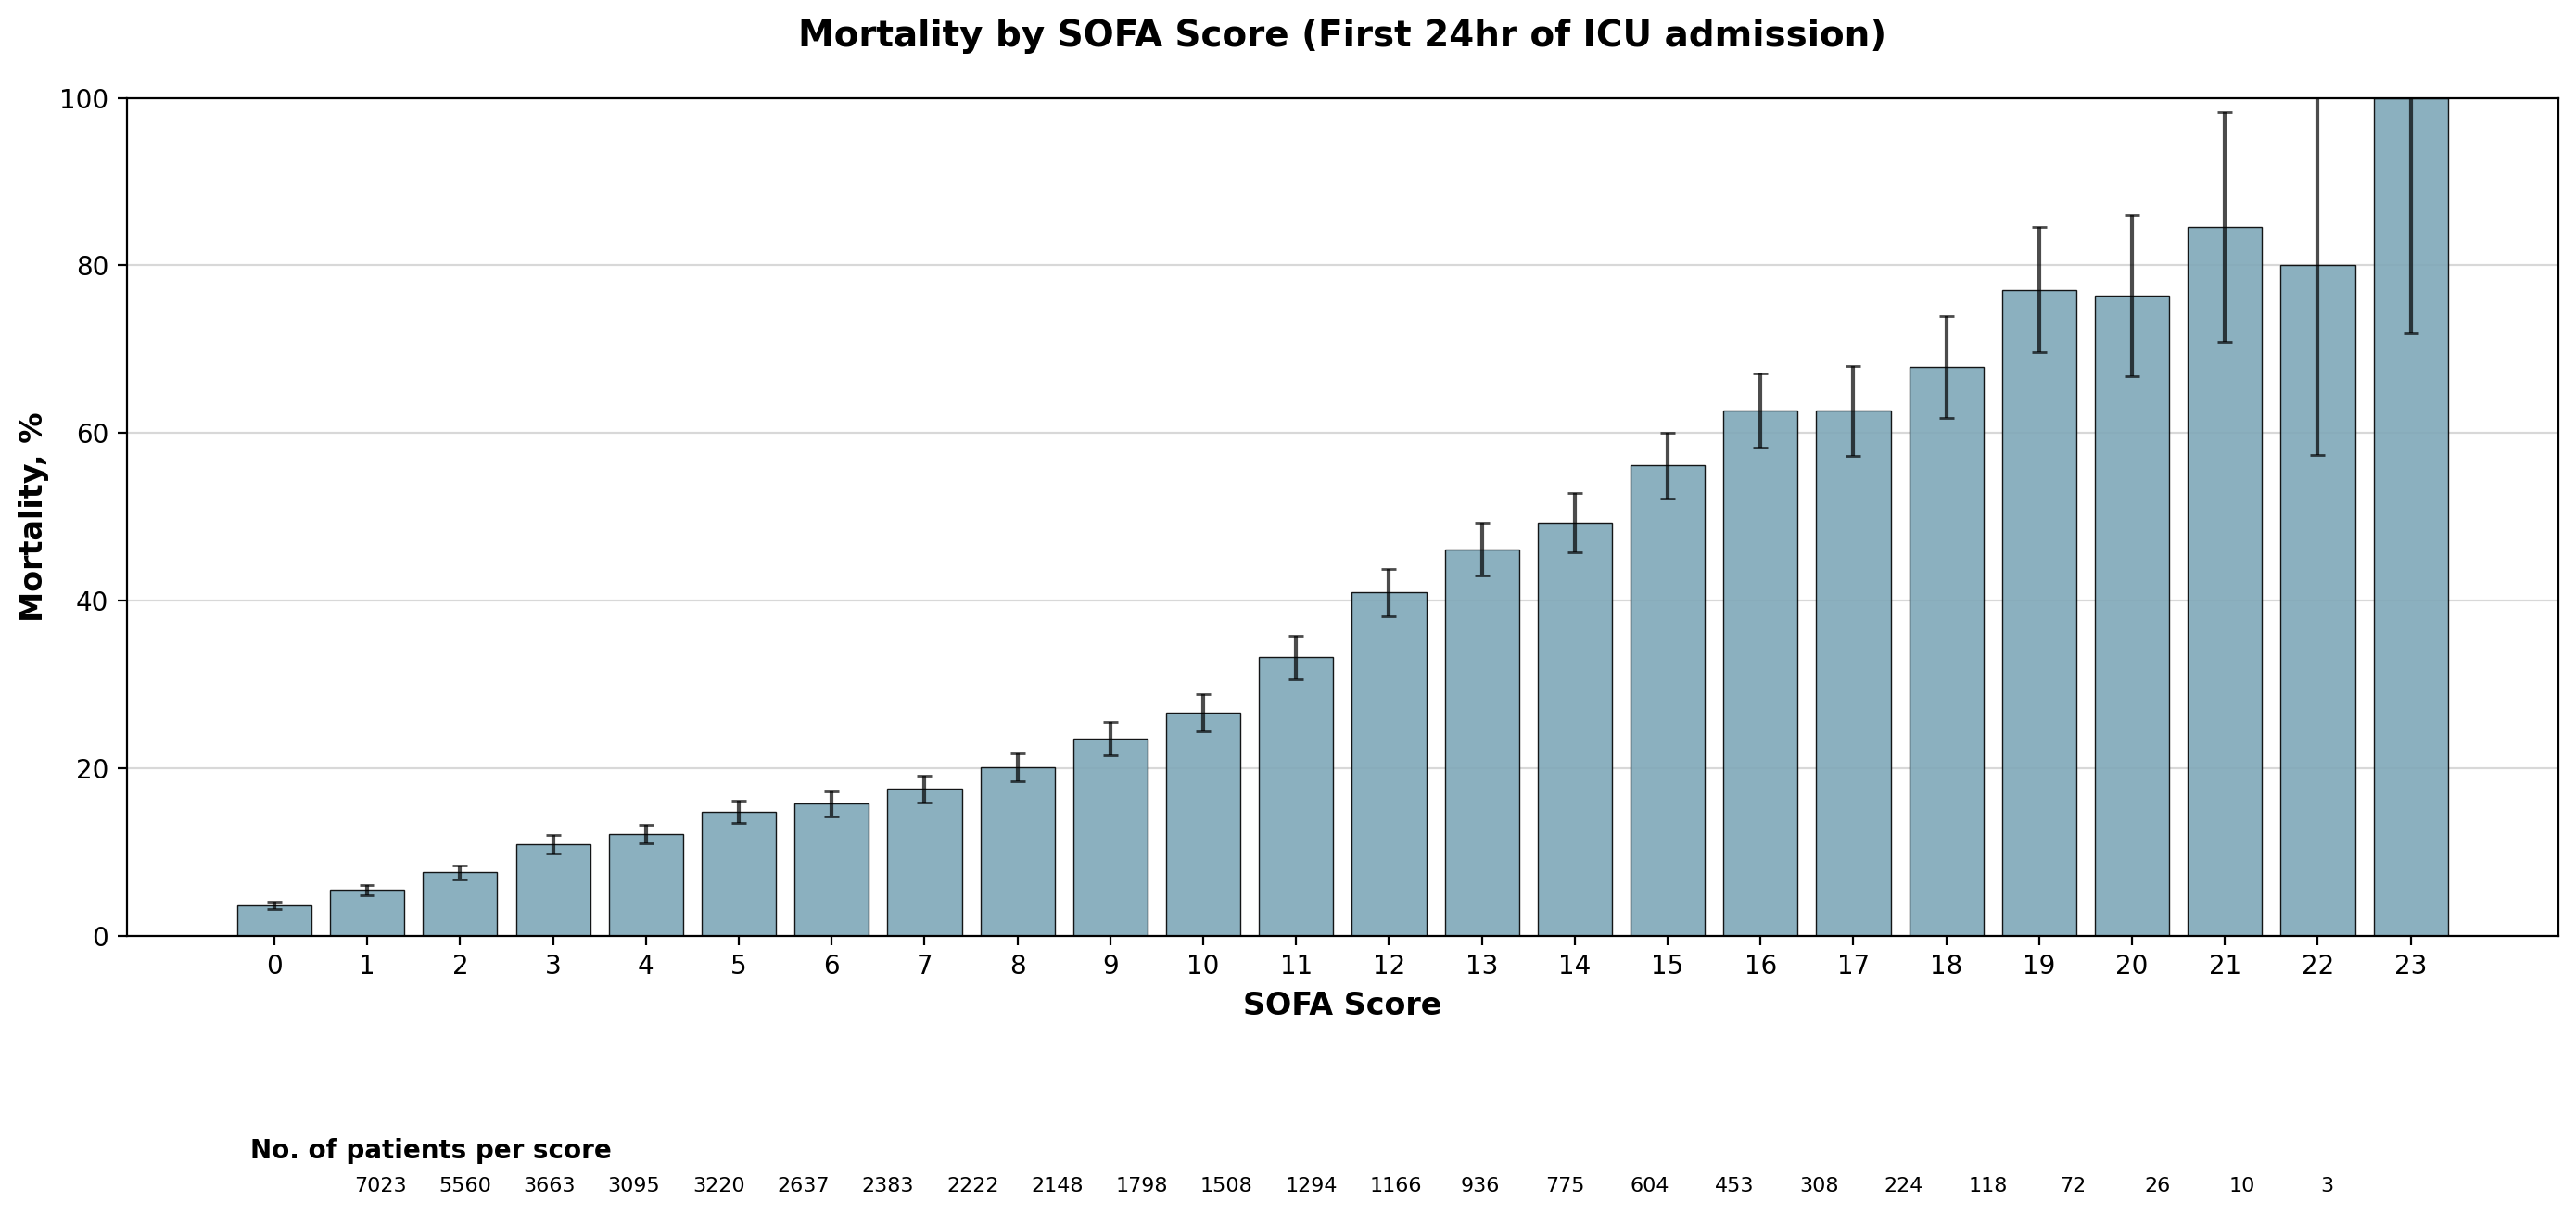


=== SOFA Mortality Summary Saved ===
File saved to: ../output/final/tableone/sofa_mortality_summary.csv


In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#  Prepare the data
# Group by SOFA score and calculate mortality rate and counts
sofa_mortality = sofa_scores.groupby('sofa_total').agg({
    'death_enc': ['mean', 'count']
}).reset_index()

sofa_mortality.columns = ['sofa_score', 'mortality_rate', 'count']
sofa_mortality['mortality_rate'] = sofa_mortality['mortality_rate'] * 100  # Convert to percentage

# Step 2: Calculate confidence intervals (optional, for error bars)
# Using Wilson score interval for binomial proportions
def wilson_ci(successes, n, confidence=0.95):
    from scipy import stats
    z = stats.norm.ppf((1 + confidence) / 2)
    p_hat = successes / n
    denominator = 1 + z**2 / n
    center = (p_hat + z**2 / (2*n)) / denominator
    margin = z * np.sqrt((p_hat * (1 - p_hat) + z**2 / (4*n)) / n) / denominator
    return center * 100, margin * 100

# Calculate number of deaths per score
sofa_mortality['deaths'] = (sofa_mortality['mortality_rate'] / 100) * sofa_mortality['count']

# Calculate confidence intervals
ci_data = [wilson_ci(deaths, n) if n > 0 else (0, 0) 
           for deaths, n in zip(sofa_mortality['deaths'], sofa_mortality['count'])]
sofa_mortality['ci_center'] = [x[0] for x in ci_data]
sofa_mortality['ci_margin'] = [x[1] for x in ci_data]

# Step 3: Create the plot
fig, ax = plt.subplots(figsize=(14, 6))

# Create bar chart
bars = ax.bar(sofa_mortality['sofa_score'], 
              sofa_mortality['mortality_rate'],
              color='#7FA8B8',  # Steel blue color similar to the image
              edgecolor='black',
              linewidth=0.5,
              alpha=0.9)

# Add error bars
ax.errorbar(sofa_mortality['sofa_score'], 
            sofa_mortality['mortality_rate'],
            yerr=sofa_mortality['ci_margin'],
            fmt='none',
            ecolor='black',
            capsize=3,
            capthick=1,
            alpha=0.7)

# Customize the plot
ax.set_xlabel('SOFA Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Mortality, %', fontsize=12, fontweight='bold')
ax.set_title('Mortality by SOFA Score (First 24hr of ICU admission)', fontsize=14, fontweight='bold', pad=20)

# Set y-axis limits
ax.set_ylim(0, 100)

# Add grid for readability
ax.yaxis.grid(True, linestyle='-', alpha=0.3, color='gray')
ax.set_axisbelow(True)

# Set x-axis ticks to show all SOFA scores
ax.set_xticks(range(int(sofa_mortality['sofa_score'].min()), 
                    int(sofa_mortality['sofa_score'].max()) + 1))

# Add count labels below x-axis
counts_text = '\n'.join([
    'No. of patients per score',
    '  '.join([f'{int(count)}' for count in sofa_mortality['count']])
])

# Create a second table-like annotation below the plot
fig.text(0.1, -0.05, 'No. of patients per score', 
         ha='left', fontsize=10, weight='bold')

# Add individual counts
x_positions = np.linspace(0.15, 0.9, len(sofa_mortality))
for i, (score, count) in enumerate(zip(sofa_mortality['sofa_score'], sofa_mortality['count'])):
    if i < len(x_positions):
        fig.text(x_positions[i], -0.08, f'{int(count)}', 
                ha='center', fontsize=8)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for patient counts

# Save the figure
plt.savefig('../output/final/tableone/sofa_mortality_histogram.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Step 5: Prepare data for CSV export
# Calculate lower and upper confidence interval bounds
sofa_mortality['ci_lower'] = sofa_mortality['mortality_rate'] - sofa_mortality['ci_margin']
sofa_mortality['ci_upper'] = sofa_mortality['mortality_rate'] + sofa_mortality['ci_margin']

# Ensure CI bounds are within valid range [0, 100]
sofa_mortality['ci_lower'] = sofa_mortality['ci_lower'].clip(lower=0)
sofa_mortality['ci_upper'] = sofa_mortality['ci_upper'].clip(upper=100)
sofa_mortality['total_encounters'] = sofa_scores['encounter_block'].nunique()
# Create export dataframe with all relevant columns
sofa_export = sofa_mortality[[
    'sofa_score', 
    'total_encounters',
    'count',
    'deaths',
    'mortality_rate', 
    'ci_lower',
    'ci_upper',
    'ci_margin'
]].copy()

# Rename columns for clarity
sofa_export.columns = [
    'sofa_score',
    'total_encounters',
    'n_encounters',
    'n_deaths',
    'mortality_rate_percent',
    'ci_lower_95',
    'ci_upper_95',
    'ci_margin_95'
]

# Round numeric columns for readability
sofa_export['n_encounters'] = sofa_export['n_encounters'].astype(int)
sofa_export['total_encounters'] = sofa_export['total_encounters'].astype(int)
sofa_export['n_deaths'] = sofa_export['n_deaths'].round(0).astype(int)
sofa_export['mortality_rate_percent'] = sofa_export['mortality_rate_percent'].round(2)
sofa_export['ci_lower_95'] = sofa_export['ci_lower_95'].round(2)
sofa_export['ci_upper_95'] = sofa_export['ci_upper_95'].round(2)
sofa_export['ci_margin_95'] = sofa_export['ci_margin_95'].round(2)

# Save to CSV
output_path = '../output/final/tableone/sofa_mortality_summary.csv'
sofa_export.to_csv(output_path, index=False)

print(f"\n=== SOFA Mortality Summary Saved ===")
print(f"File saved to: {output_path}")

In [80]:
# Join sofa_scores with final_tableone_df on 'encounter_block'
final_tableone_df = final_tableone_df.merge(sofa_scores, on='encounter_block', how='left')
final_tableone_df = final_tableone_df.drop(columns=['death_enc_y'])


# Outside of Table1- on whole dataset

## Hospice Use vs Mortality Trends

✅ Saved: ../output/final/tableone/hospice_trends_summary.csv


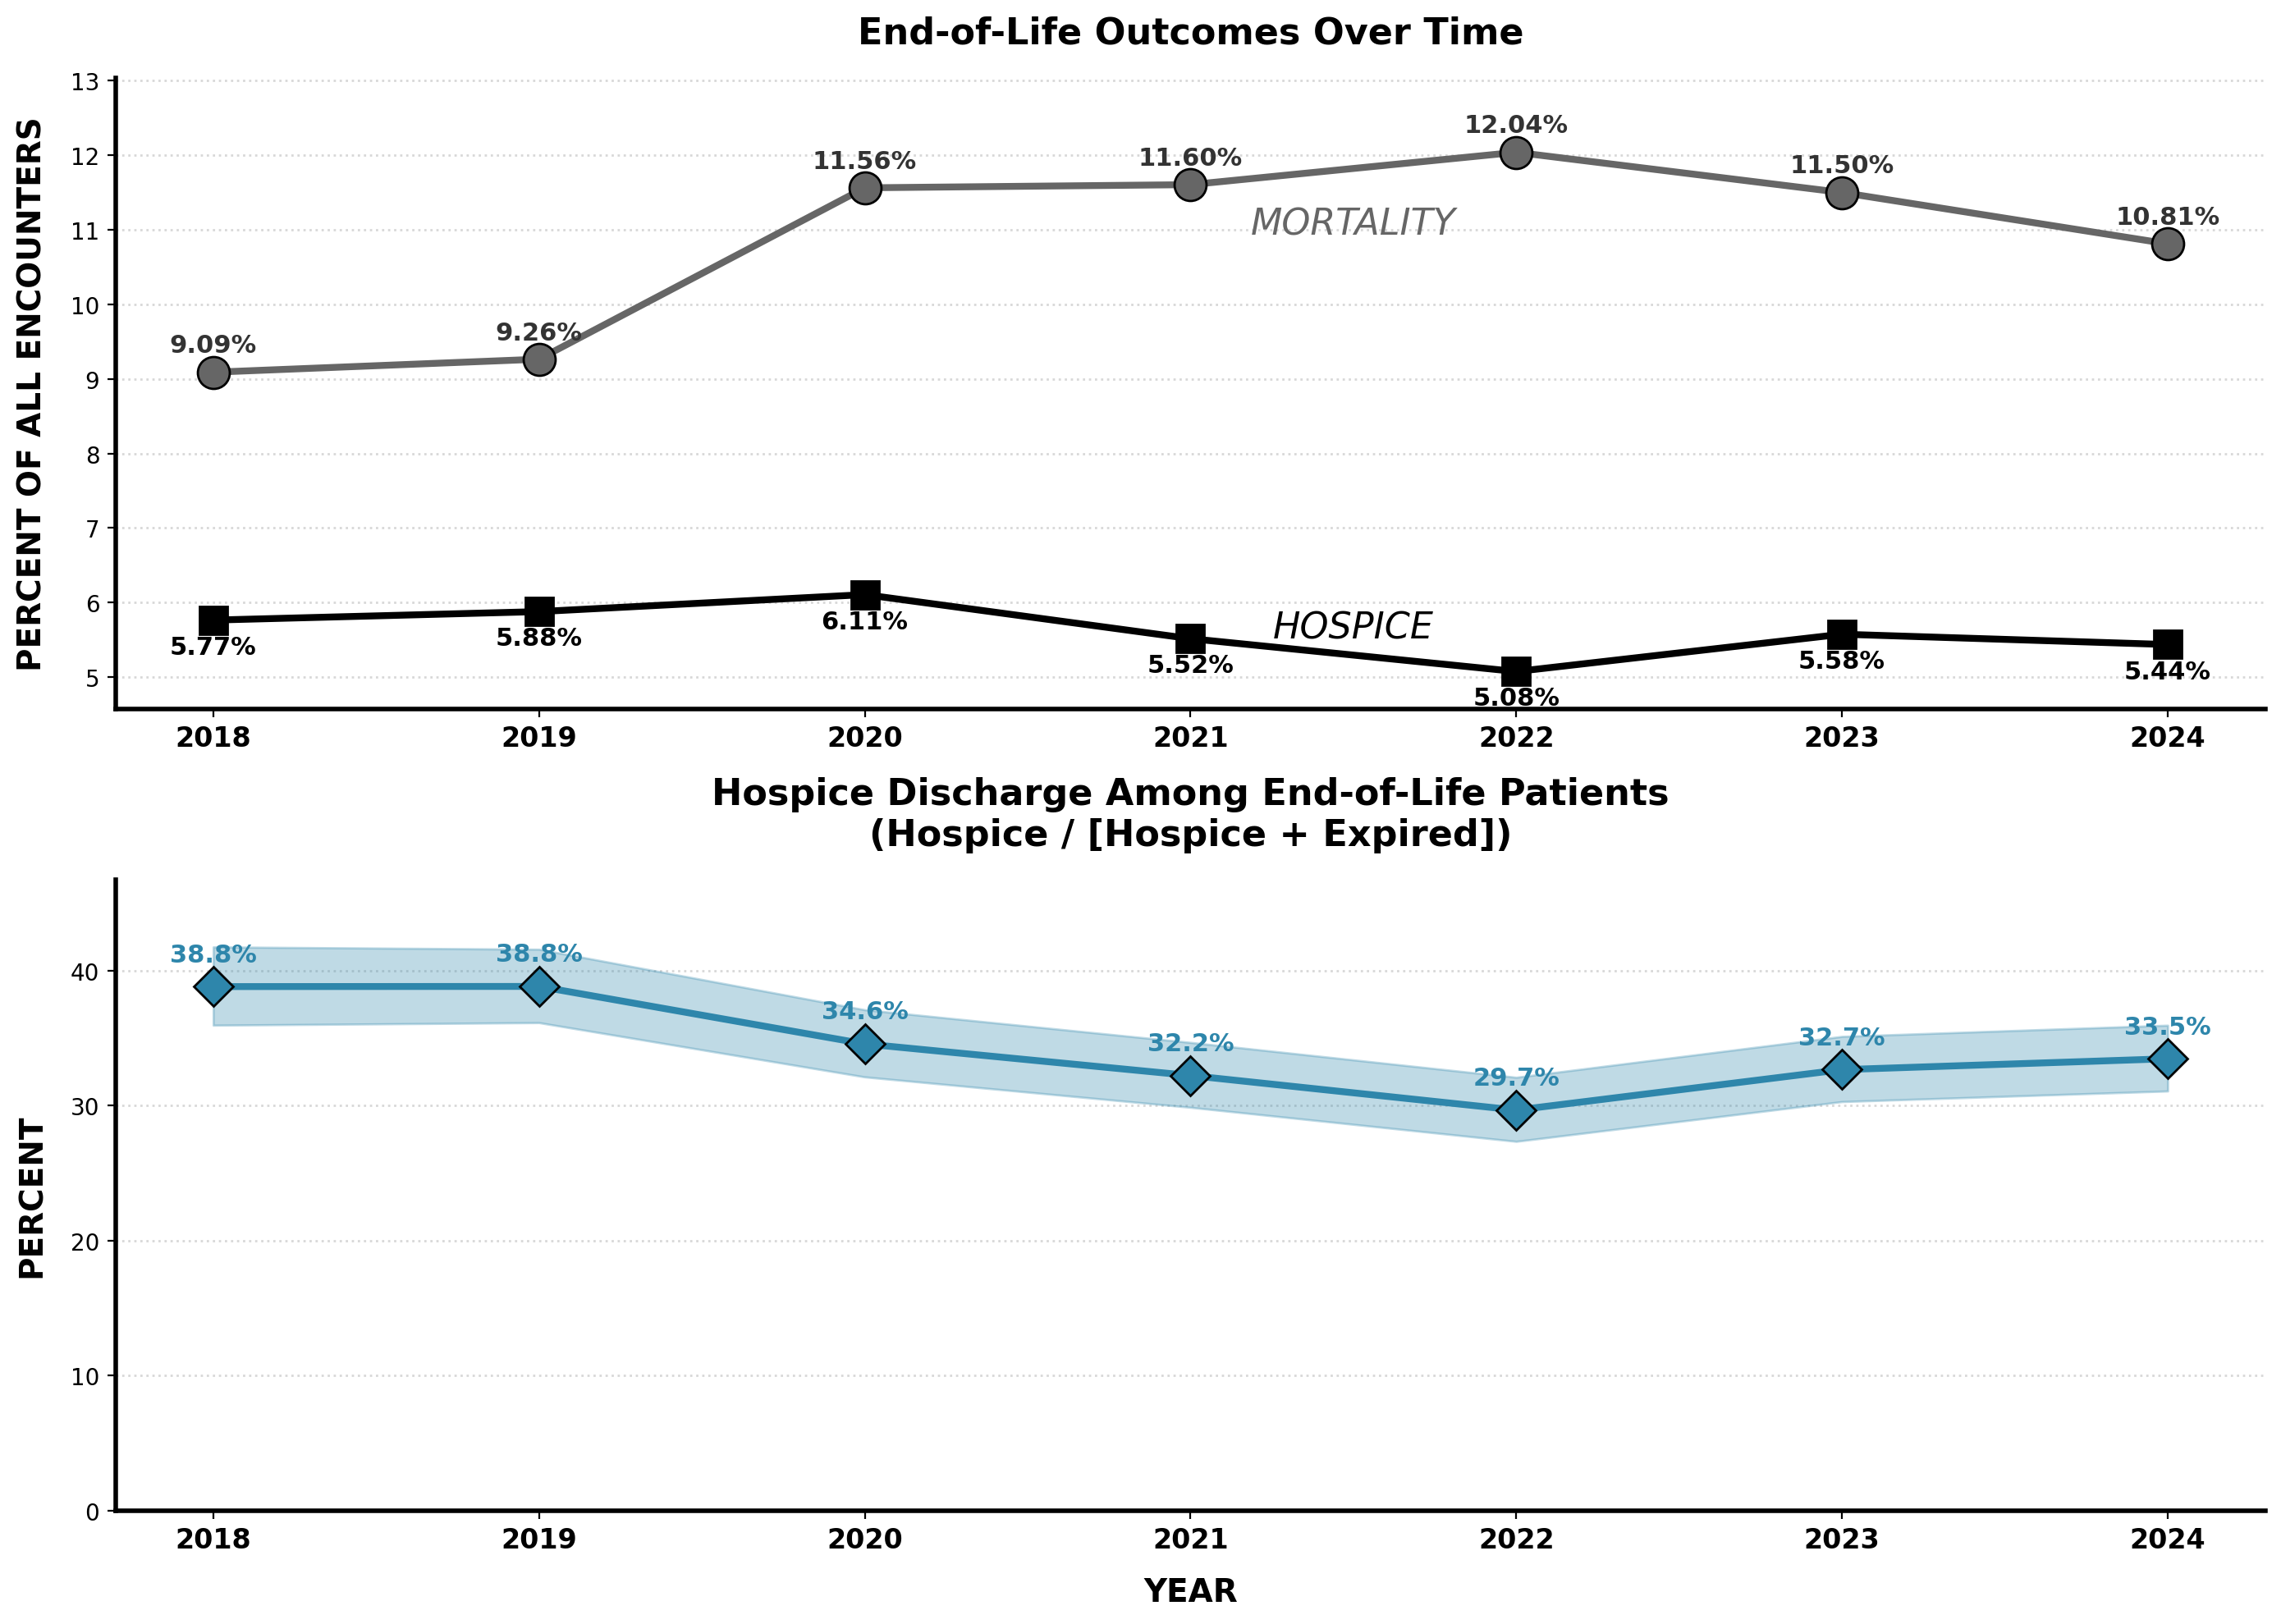


✅ Hospice trends analysis complete!


In [81]:
from statsmodels.stats.proportion import proportion_confint

# ============================================================================
# Prepare Comprehensive Hospice Trend Data
# ============================================================================

# Extract year from admission_dttm
final_tableone_df['admission_year'] = final_tableone_df['admission_dttm'].dt.year

# Create outcome variables
final_tableone_df['hospice_outcome'] = (
    final_tableone_df['discharge_category'].str.lower() == 'hospice'
).astype(int)

final_tableone_df['expired_outcome'] = (
    final_tableone_df['discharge_category'].str.lower() == 'expired'
).astype(int)

final_tableone_df['hospice_or_expired'] = (
    final_tableone_df['discharge_category'].str.lower().isin(['hospice', 'expired'])
).astype(int)

# ============================================================================
# Aggregate All Metrics by Year (Single DataFrame)
# ============================================================================

hospice_trends = final_tableone_df.groupby('admission_year').agg({
    'encounter_block': 'count',  # Total encounters
    'hospice_outcome': 'sum',    # Hospice discharges
    'expired_outcome': 'sum',    # Deaths
    'hospice_or_expired': 'sum'  # Combined end-of-life
}).reset_index()

hospice_trends.columns = ['year', 'total_encounters', 'hospice', 'expired', 'hospice_or_expired']

# Calculate percentages (of all encounters)
hospice_trends['hospice_pct'] = (hospice_trends['hospice'] / hospice_trends['total_encounters'] * 100)
hospice_trends['mortality_pct'] = (hospice_trends['expired'] / hospice_trends['total_encounters'] * 100)

# Calculate hospice proportion among end-of-life patients
hospice_trends['hospice_among_eol_pct'] = (
    hospice_trends['hospice'] / hospice_trends['hospice_or_expired'] * 100
)

# Calculate Wilson score confidence intervals
def calculate_ci(successes, n, confidence=0.95):
    """Calculate Wilson score confidence interval for proportions"""
    if n == 0:
        return 0, 0
    ci_low, ci_upp = proportion_confint(successes, n, alpha=1-confidence, method='wilson')
    return ci_low * 100, ci_upp * 100

# CIs for hospice among end-of-life
ci_results = [
    calculate_ci(row['hospice'], row['hospice_or_expired'])
    for _, row in hospice_trends.iterrows()
]
hospice_trends['hospice_among_eol_ci_lower'] = [x[0] for x in ci_results]
hospice_trends['hospice_among_eol_ci_upper'] = [x[1] for x in ci_results]

# ============================================================================
# Save Results DataFrame
# ============================================================================

output_dir = '../output/final/tableone/'
hospice_trends.to_csv(f'{output_dir}hospice_trends_summary.csv', index=False)
print(f"✅ Saved: {output_dir}hospice_trends_summary.csv")

# ============================================================================
# Create Combined Figure
# ============================================================================

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

x_labels = hospice_trends['year'].astype(str).tolist()
x_pos = np.arange(len(x_labels))

# ----------------------------------------------------------------------------
# TOP PANEL: Mortality vs Hospice Trends (% of all encounters)
# ----------------------------------------------------------------------------

mortality_pct = hospice_trends['mortality_pct'].values
hospice_pct = hospice_trends['hospice_pct'].values

# Plot MORTALITY line
ax1.plot(x_pos, mortality_pct, 
         marker='o', markersize=14, 
         color='#666666', 
         linewidth=3,
         markerfacecolor='#666666',
         markeredgecolor='black',
         markeredgewidth=1,
         label='MORTALITY',
         zorder=3)

# Plot HOSPICE line
ax1.plot(x_pos, hospice_pct,
         marker='s', markersize=12,
         color='#000000',
         linewidth=3,
         markerfacecolor='#000000',
         markeredgecolor='black',
         markeredgewidth=1,
         label='HOSPICE',
         zorder=3)

# Add percentage labels
for i, (mort, hosp) in enumerate(zip(mortality_pct, hospice_pct)):
    ax1.text(i, mort + 0.2, f'{mort:.2f}%', 
             ha='center', va='bottom', 
             fontsize=11, fontweight='bold',
             color='#333333')
    
    ax1.text(i, hosp - 0.2, f'{hosp:.2f}%',
             ha='center', va='top',
             fontsize=11, fontweight='bold',
             color='#000000')

# Add text labels
mid_y_mortality = np.mean(mortality_pct)
mid_y_hospice = np.mean(hospice_pct)

ax1.text(len(x_pos)/2, mid_y_mortality + 0.1, 'MORTALITY', 
         fontsize=16, fontweight='normal',
         color='#666666', ha='center',
         style='italic')

ax1.text(len(x_pos)/2, mid_y_hospice - 0.1, 'HOSPICE',
         fontsize=16, fontweight='normal',
         color='#000000', ha='center',
         style='italic')

# Customize axes
ax1.set_ylabel('PERCENT OF ALL ENCOUNTERS', fontsize=14, fontweight='bold', labelpad=10)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(x_labels, fontsize=12, fontweight='bold')
ax1.set_ylim(hospice_pct.min() - 0.5, mortality_pct.max() + 1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)
ax1.yaxis.grid(True, linestyle=':', alpha=0.3, linewidth=1, color='gray')
ax1.set_axisbelow(True)
ax1.set_title('End-of-Life Outcomes Over Time', fontsize=16, fontweight='bold', pad=15)

# ----------------------------------------------------------------------------
# BOTTOM PANEL: Hospice Proportion Among End-of-Life Patients
# ----------------------------------------------------------------------------

hospice_among_eol_pct = hospice_trends['hospice_among_eol_pct'].values
ci_lower = hospice_trends['hospice_among_eol_ci_lower'].values
ci_upper = hospice_trends['hospice_among_eol_ci_upper'].values

# Plot line with confidence interval
ax2.plot(x_pos, hospice_among_eol_pct,
         marker='D', markersize=12,
         color='#2E86AB',
         linewidth=3,
         markerfacecolor='#2E86AB',
         markeredgecolor='black',
         markeredgewidth=1,
         zorder=3)

# Add confidence interval shading
ax2.fill_between(x_pos, ci_lower, ci_upper,
                 alpha=0.3, color='#2E86AB')

# Add percentage labels
for i, pct in enumerate(hospice_among_eol_pct):
    ax2.text(i, pct + 1.5, f'{pct:.1f}%',
             ha='center', va='bottom',
             fontsize=11, fontweight='bold',
             color='#2E86AB')

# Customize axes
ax2.set_xlabel('YEAR', fontsize=14, fontweight='bold', labelpad=10)
ax2.set_ylabel('PERCENT', fontsize=14, fontweight='bold', labelpad=10)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(x_labels, fontsize=12, fontweight='bold')
ax2.set_ylim(0, max(ci_upper) + 5)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_linewidth(2)
ax2.spines['bottom'].set_linewidth(2)
ax2.yaxis.grid(True, linestyle=':', alpha=0.3, linewidth=1, color='gray')
ax2.set_axisbelow(True)
ax2.set_title('Hospice Discharge Among End-of-Life Patients\n(Hospice / [Hospice + Expired])',
             fontsize=16, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig(f'{output_dir}hospice_mortality_combined_trends.png', 
            dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

print("\n✅ Hospice trends analysis complete!")

## CCI Hospice Trends

✅ Saved: ../output/final/tableone/cci_hospice_mortality_comprehensive_summary.csv
✅ Saved plotting data for figure: ../output/final/tableone/cci_mortality_hospice_trends_by_year_category_plotdata.csv

COMPREHENSIVE CCI HOSPICE-MORTALITY SUMMARY

Total records: 28
Years covered: 2018 - 2024
CCI categories: 4

Total encounters across all years: 50,321
Total deaths: 6,024
Total hospice discharges: 2,021


/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_52347/1104699313.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_52347/1104699313.py:28: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



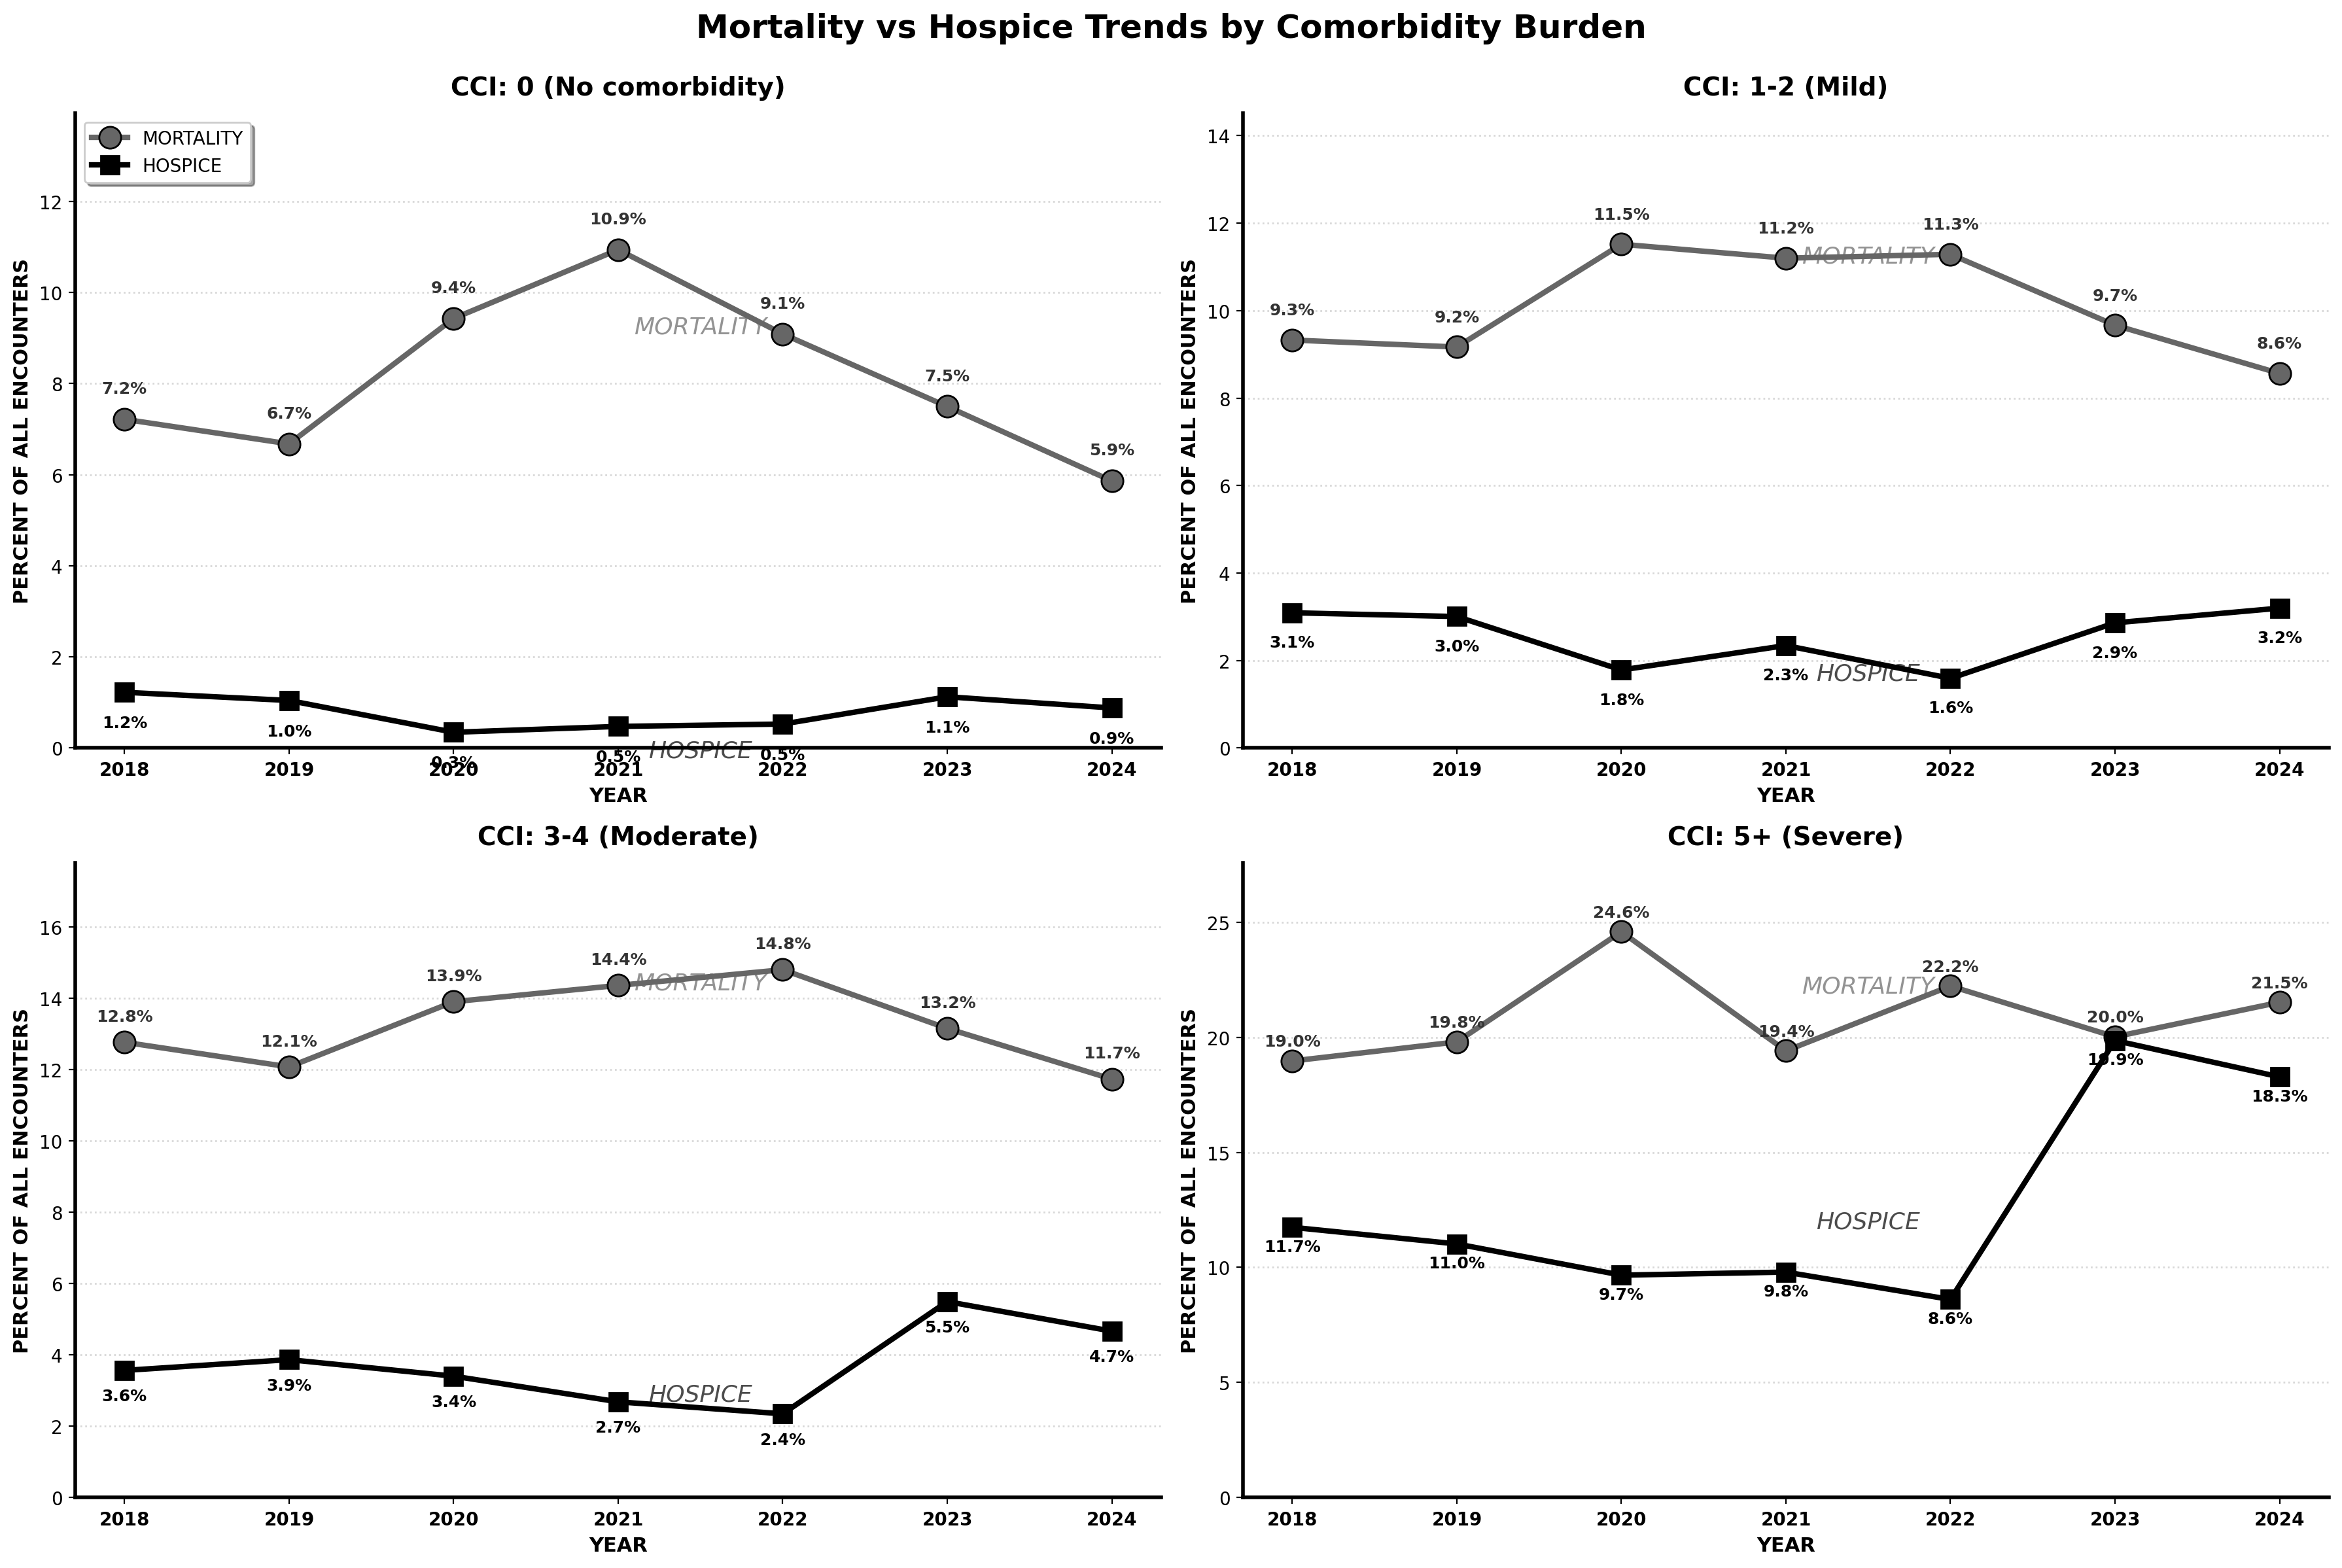

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint

# ============================================================================
# Merge CCI Results with Final TableOne (if not already done)
# ============================================================================
# final_tableone_df['admission_year'] = final_tableone_df['admission_dttm'].dt.year
# tableone_with_cci = final_tableone_df.merge(
#     cci_results[['hospitalization_id', 'cci_score']], 
#     on='hospitalization_id', 
#     how='left'
# )
tableone_with_cci = final_tableone_df[['encounter_block','cci_score','admission_year',
                                        'expired_outcome', 'hospice_or_expired', 'hospice_outcome']]
# Create CCI Categories
tableone_with_cci['cci_category'] = pd.cut(
    tableone_with_cci['cci_score'],
    bins=[-np.inf, 0, 2, 4, np.inf],
    labels=['0 (No comorbidity)', '1-2 (Mild)', '3-4 (Moderate)', '5+ (Severe)']
)

# ============================================================================
# Create Comprehensive Summary by CCI Category and Year
# ============================================================================

cci_summary = tableone_with_cci.groupby(['admission_year', 'cci_category']).agg({
    'encounter_block': 'count',
    'hospice_outcome': 'sum',
    'expired_outcome': 'sum',
    'hospice_or_expired': 'sum'
}).reset_index()

cci_summary.columns = ['year', 'cci_category', 'total_encounters', 
                       'hospice_count', 'expired_count', 'hospice_or_expired_count']

# Calculate all key metrics
cci_summary['mortality_pct'] = (
    cci_summary['expired_count'] / cci_summary['total_encounters'] * 100
)
cci_summary['hospice_pct'] = (
    cci_summary['hospice_count'] / cci_summary['total_encounters'] * 100
)
cci_summary['combined_eol_pct'] = (
    cci_summary['hospice_or_expired_count'] / cci_summary['total_encounters'] * 100
)
cci_summary['hospice_among_eol_pct'] = (
    cci_summary['hospice_count'] / cci_summary['hospice_or_expired_count'] * 100
)
cci_summary['hospice_capture_rate'] = (
    cci_summary['hospice_count'] / cci_summary['expired_count'] * 100
)

# Calculate confidence intervals for hospice among EOL
def calculate_ci(row):
    if row['hospice_or_expired_count'] == 0:
        return pd.Series({'hospice_eol_ci_lower': np.nan, 'hospice_eol_ci_upper': np.nan})
    ci_low, ci_upp = proportion_confint(
        row['hospice_count'], row['hospice_or_expired_count'], 
        alpha=0.05, method='wilson'
    )
    return pd.Series({
        'hospice_eol_ci_lower': ci_low * 100, 
        'hospice_eol_ci_upper': ci_upp * 100
    })

cci_summary[['hospice_eol_ci_lower', 'hospice_eol_ci_upper']] = cci_summary.apply(calculate_ci, axis=1)

# Reorder columns for clarity
cci_summary = cci_summary[[
    'year', 'cci_category', 'total_encounters',
    'expired_count', 'mortality_pct',
    'hospice_count', 'hospice_pct',
    'hospice_or_expired_count', 'combined_eol_pct',
    'hospice_among_eol_pct', 'hospice_eol_ci_lower', 'hospice_eol_ci_upper',
    'hospice_capture_rate'
]]

# Save comprehensive summary
output_dir = '../output/final/tableone/'
cci_summary.to_csv(f'{output_dir}cci_hospice_mortality_comprehensive_summary.csv', index=False)
print(f"✅ Saved: {output_dir}cci_hospice_mortality_comprehensive_summary.csv")

# Save the plotting data ("data behind the figure") to a separate CSV file
# This replicates the data used for each panel in the grid:
plot_data = []
categories = ['0 (No comorbidity)', '1-2 (Mild)', '3-4 (Moderate)', '5+ (Severe)']

for category in categories:
    cat_data = cci_summary[cci_summary['cci_category'] == category].sort_values('year')
    plot_data.append(
        cat_data.assign(cci_category_label=category)
    )

plot_data_df = pd.concat(plot_data, axis=0)

plot_data_df.to_csv(f'{output_dir}cci_mortality_hospice_trends_by_year_category_plotdata.csv', index=False)
print(f"✅ Saved plotting data for figure: {output_dir}cci_mortality_hospice_trends_by_year_category_plotdata.csv")

# Display summary statistics
print("\n" + "="*80)
print("COMPREHENSIVE CCI HOSPICE-MORTALITY SUMMARY")
print("="*80)
print(f"\nTotal records: {len(cci_summary)}")
print(f"Years covered: {cci_summary['year'].min():.0f} - {cci_summary['year'].max():.0f}")
print(f"CCI categories: {cci_summary['cci_category'].nunique()}")
print(f"\nTotal encounters across all years: {cci_summary['total_encounters'].sum():,}")
print(f"Total deaths: {cci_summary['expired_count'].sum():,}")
print(f"Total hospice discharges: {cci_summary['hospice_count'].sum():,}")

# ============================================================================
# Create Unified Visualization: 2x2 Grid with Mortality vs Hospice
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

colors_mortality = '#666666'
colors_hospice = '#000000'

for i, (category, ax) in enumerate(zip(categories, axes)):
    data = cci_summary[cci_summary['cci_category'] == category].sort_values('year')
    
    x_labels = data['year'].astype(str).tolist()
    x_pos = np.arange(len(x_labels))
    
    mortality_pct = data['mortality_pct'].values
    hospice_pct = data['hospice_pct'].values
    
    # Plot MORTALITY line
    ax.plot(x_pos, mortality_pct, 
            marker='o', markersize=12, 
            color=colors_mortality, 
            linewidth=3,
            markerfacecolor=colors_mortality,
            markeredgecolor='black',
            markeredgewidth=1,
            label='MORTALITY',
            zorder=3)
    
    # Plot HOSPICE line
    ax.plot(x_pos, hospice_pct,
            marker='s', markersize=10,
            color=colors_hospice,
            linewidth=3,
            markerfacecolor=colors_hospice,
            markeredgecolor='black',
            markeredgewidth=1,
            label='HOSPICE',
            zorder=3)
    
    # Add percentage labels
    for j, (mort, hosp) in enumerate(zip(mortality_pct, hospice_pct)):
        ax.text(j, mort + 0.5, f'{mort:.1f}%', 
                ha='center', va='bottom', 
                fontsize=9, fontweight='bold',
                color='#333333')
        
        ax.text(j, hosp - 0.5, f'{hosp:.1f}%',
                ha='center', va='top',
                fontsize=9, fontweight='bold',
                color='#000000')
    
    # Add text labels in plot area
    mid_y_mortality = np.mean(mortality_pct)
    mid_y_hospice = np.mean(hospice_pct)
    
    if mid_y_mortality - mid_y_hospice > 3:
        ax.text(len(x_pos)/2, mid_y_mortality + 1, 'MORTALITY', 
                fontsize=13, fontweight='normal',
                color='#666666', ha='center',
                style='italic', alpha=0.7)
        
        ax.text(len(x_pos)/2, mid_y_hospice - 1, 'HOSPICE',
                fontsize=13, fontweight='normal',
                color='#000000', ha='center',
                style='italic', alpha=0.7)
    
    # Customize axes
    ax.set_ylabel('PERCENT OF ALL ENCOUNTERS', fontsize=11, fontweight='bold')
    ax.set_xlabel('YEAR', fontsize=11, fontweight='bold')
    ax.set_title(f'CCI: {category}', fontsize=14, fontweight='bold', pad=10)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_labels, fontsize=10, fontweight='bold')
    
    y_max = max(mortality_pct.max(), hospice_pct.max())
    ax.set_ylim(0, y_max + 3)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    
    ax.yaxis.grid(True, linestyle=':', alpha=0.3, linewidth=1, color='gray')
    ax.set_axisbelow(True)
    
    if i == 0:
        ax.legend(loc='upper left', fontsize=10, frameon=True, 
                 fancybox=True, shadow=True)

plt.suptitle('Mortality vs Hospice Trends by Comorbidity Burden', 
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(f'{output_dir}cci_mortality_hospice_comprehensive.png', 
            dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

In [83]:
strobe_counts

{'0_total_hospitalizations': 166781,
 '1_adult_hospitalizations': 166781,
 '1b_before_stitching': 166781,
 '1b_after_stitching': 166644,
 '1b_stitched_hosp_ids': 137,
 '1_icu_encounters': 41179,
 '2_advanced_resp_support_hospitalizations': 30596,
 '3_vasoactive_hospitalizations': 25190,
 '4_other_critically_ill': 2314,
 '5_all_critically_ill': 57095,
 'IMV encounters': 18482}

# TableOne

In [84]:
cols = final_tableone_df.columns
for x in cols:
    print(x)

patient_id
hospitalization_id
encounter_block
admission_dttm
discharge_dttm
age_at_admission
discharge_category
admission_type_category
race_category
ethnicity_category
sex_category
death_dttm
icu_enc
death_enc_x
cohort_enc
high_support_enc
vaso_support_enc
other_critically_ill
first_icu_in_dttm
first_icu_out_dttm
first_icu_los_days
min_in_dttm
max_out_dttm
first_admission_location
hospital_length_of_stay_days
last_code_status_category
on_vent
initial_mode_category
first_location_imv
vent_start_dttm
fio2_set_median
lpm_set_median
tidal_volume_set_median
resp_rate_set_median
pressure_control_set_median
pressure_support_set_median
peep_set_median
fio2_set_q1
lpm_set_q1
tidal_volume_set_q1
resp_rate_set_q1
pressure_control_set_q1
pressure_support_set_q1
peep_set_q1
fio2_set_q3
lpm_set_q3
tidal_volume_set_q3
resp_rate_set_q3
pressure_control_set_q3
pressure_support_set_q3
peep_set_q3
fio2_set_mean
lpm_set_mean
tidal_volume_set_mean
resp_rate_set_mean
pressure_control_set_mean
pressure_supp

In [85]:
# ============================================================================
# OPTIMIZED: Prepare Data and Create Table One
# ============================================================================

import pandas as pd
import numpy as np

# ============================================================================
# Step 1: Prepare final_tableone_df for Table One (Optimized)
# ============================================================================

print("\n" + "="*80)
print("PREPARING DATA FOR TABLE ONE")
print("="*80)

print(f"\nOriginal final_tableone_df shape: {final_tableone_df.shape}")
print(f"Unique encounter_blocks: {final_tableone_df['encounter_block'].nunique()}")

# ✅ OPTIMIZATION: Check and deduplicate in one step
duplicates = final_tableone_df['encounter_block'].duplicated().sum()
print(f"Duplicate encounter_blocks: {duplicates}")

if duplicates > 0:
    print("\n⚠️  Multiple rows per encounter_block found. Keeping last value...")
    tableone_df = final_tableone_df.drop_duplicates(subset=['encounter_block'], keep='last')
else:
    tableone_df = final_tableone_df

print(f"\nFinal tableone_df shape: {tableone_df.shape}")

# ✅ OPTIMIZATION: Create patient demographics once, reuse throughout
patient_df = tableone_df[['patient_id', 'race_category', 'ethnicity_category', 'sex_category', 'age_at_admission']].drop_duplicates('patient_id')
print(f"Unique patients: {len(patient_df):,}")

# ============================================================================
# Step 2: OPTIMIZED Table One Generation Function
# ============================================================================

def make_table_one_optimized(df, patient_demographics, id_col='encounter_block'):
    """
    Optimized Table One generation - pre-computes values, minimizes iterations.
    """
    rows = []
    
    # ✅ PRE-COMPUTE: Common values used throughout
    N_enc = len(df)
    N_pat = len(patient_demographics)
    
    # ✅ OPTIMIZATION: Compute all summations once
    flag_sums = {}
    for col in df.columns:
        if col.endswith('_flag') or col in ['icu_enc', 'death_enc', 'high_support_enc', 
                                             'vaso_support_enc', 'other_critically_ill', 
                                             'on_vent', 'on_crrt', 'hospice_outcome', 
                                             'expired_outcome']:
            if col in df.columns:
                flag_sums[col] = df[col].sum()
    
    # ✅ OPTIMIZATION: Compute all medians/quantiles once for continuous vars
    continuous_stats = {}
    for col in ['age_at_admission', 'first_icu_los_days', 'hospital_length_of_stay_days', 'cci_score',
                'p_f', 'p_f_imputed', 'sofa_cv_97', 'sofa_coag', 'sofa_liver', 
                'sofa_resp', 'sofa_cns', 'sofa_renal', 'sofa_total']:
        if col in df.columns:
            data = df[col].dropna() if col != 'age_at_admission' else patient_demographics['age_at_admission'].dropna()
            if len(data) > 0:
                continuous_stats[col] = {
                    'median': data.median(),
                    'q1': data.quantile(0.25),
                    'q3': data.quantile(0.75)
                }
    
    # -------------------------------------------------------------------------
    # 1. Sample Size
    # -------------------------------------------------------------------------
    rows.append(("N: Encounter blocks", f"{N_enc:,}"))
    rows.append(("N: Unique patients", f"{N_pat:,}"))
    
    # -------------------------------------------------------------------------
    # 2. Demographics
    # -------------------------------------------------------------------------
    # Age
    if 'age_at_admission' in continuous_stats:
        s = continuous_stats['age_at_admission']
        rows.append(("Age at admission, median [Q1, Q3]",
                     f"{s['median']:.0f} [{s['q1']:.0f}, {s['q3']:.0f}]"))
    
    # ✅ OPTIMIZATION: Vectorized categorical function with pre-computed denominator
    def cat_n_pct_fast(data, col, title, denominator):
        vc = data[col].value_counts(dropna=False)
        for lvl, cnt in vc.items():
            pct = 100 * cnt / denominator
            lvl_str = str(lvl) if pd.notna(lvl) else 'Missing'
            rows.append((f"  {title}: {lvl_str}", f"{cnt:,} ({pct:.1f}%)"))
    
    cat_n_pct_fast(patient_demographics, 'race_category', 'Race', N_pat)
    cat_n_pct_fast(patient_demographics, 'ethnicity_category', 'Ethnicity', N_pat)
    cat_n_pct_fast(patient_demographics, 'sex_category', 'Sex', N_pat)
    
    # -------------------------------------------------------------------------
    # 3. Encounter Types (use pre-computed sums)
    # -------------------------------------------------------------------------
    rows.append(("Encounter Types", ""))
    
    for flag, label in [
        ('icu_enc', 'ICU encounters'),
        ('high_support_enc', 'Advanced respiratory support'),
        ('vaso_support_enc', 'Vasoactive support'),
        ('other_critically_ill', 'Other critically ill')
    ]:
        if flag in flag_sums:
            n = flag_sums[flag]
            rows.append((f"  {label}, n (%)", f"{n:,} ({100*n/N_enc:.1f}%)"))
    
    # -------------------------------------------------------------------------
    # 4. Mortality (use pre-computed sums)
    # -------------------------------------------------------------------------
    if 'death_enc' in flag_sums:
        mort_n = flag_sums['death_enc']
        rows.append(("Hospital mortality, n (%)", f"{mort_n:,} ({100*mort_n/N_enc:.1f}%)"))
        
        for flag, label in [('hospice_outcome', 'Discharged to hospice'),
                            ('expired_outcome', 'Expired')]:
            if flag in flag_sums:
                n = flag_sums[flag]
                rows.append((f"  {label}, n (%)", f"{n:,} ({100*n/N_enc:.1f}%)"))
    
    # -------------------------------------------------------------------------
    # 5. Admission and Location
    # -------------------------------------------------------------------------
    cat_n_pct_fast(df, 'first_admission_location', 'First admission location', N_enc)
    if 'admission_type_category' in df.columns:
        cat_n_pct_fast(df, 'admission_type_category', 'Admission type', N_enc)
    
    # -------------------------------------------------------------------------
    # 6. Length of Stay (use pre-computed stats)
    # -------------------------------------------------------------------------
    for col, label in [('first_icu_los_days', 'ICU length of stay (days)'),
                       ('hospital_length_of_stay_days', 'Hospital length of stay (days)')]:
        if col in continuous_stats:
            s = continuous_stats[col]
            rows.append((f"{label}, median [Q1, Q3]",
                        f"{s['median']:.1f} [{s['q1']:.1f}, {s['q3']:.1f}]"))
    
    # -------------------------------------------------------------------------
    # 7. Comorbidities
    # -------------------------------------------------------------------------
    if 'cci_score' in continuous_stats:
        s = continuous_stats['cci_score']
        rows.append(("Charlson Comorbidity Index, median [Q1, Q3]",
                     f"{s['median']:.0f} [{s['q1']:.0f}, {s['q3']:.0f}]"))
    
    # ✅ OPTIMIZATION: Get all comorbidity columns at once
    comorbidities = [
        'myocardial_infarction', 'congestive_heart_failure', 'peripheral_vascular_disease',
        'cerebrovascular_disease', 'dementia', 'chronic_pulmonary_disease',
        'connective_tissue_disease', 'peptic_ulcer_disease', 'mild_liver_disease',
        'diabetes_uncomplicated', 'diabetes_with_complications', 'hemiplegia',
        'renal_disease', 'cancer', 'moderate_severe_liver_disease',
        'metastatic_solid_tumor', 'aids'
    ]
    
    comorb_present = [c for c in comorbidities if c in df.columns]
    if comorb_present:
        # ✅ OPTIMIZATION: Sum all at once with one operation
        comorb_sums = df[comorb_present].sum()
        comorb_with_counts = comorb_sums[comorb_sums > 0].sort_values(ascending=False)
        
        if len(comorb_with_counts) > 0:
            rows.append(("Comorbidities, n (%)", ""))
            for comorb, n in comorb_with_counts.items():
                name = comorb.replace('_', ' ').title()
                rows.append((f"  {name}", f"{int(n):,} ({100*n/N_enc:.1f}%)"))
    # -------------------------------------------------------------------------
    # 8. SOFA Scores
    # -------------------------------------------------------------------------
    rows.append(("SOFA Scores", ""))
    
    # Total SOFA
    if 'sofa_total' in continuous_stats:
        s = continuous_stats['sofa_total']
        rows.append(("  Total SOFA score, median [Q1, Q3]",
                     f"{s['median']:.1f} [{s['q1']:.1f}, {s['q3']:.1f}]"))
    
    # Individual SOFA components
    sofa_components = [
        ('sofa_resp', 'Respiratory'),
        ('sofa_coag', 'Coagulation'),
        ('sofa_liver', 'Liver'),
        ('sofa_cv_97', 'Cardiovascular'),
        ('sofa_cns', 'CNS'),
        ('sofa_renal', 'Renal')
    ]
    
    for col, label in sofa_components:
        if col in continuous_stats:
            s = continuous_stats[col]
            rows.append((f"    {label}, median [Q1, Q3]",
                        f"{s['median']:.1f} [{s['q1']:.1f}, {s['q3']:.1f}]"))
    
    # P/F ratio (optional, if you want to include it)
    if 'p_f' in continuous_stats:
        s = continuous_stats['p_f']
        rows.append(("  P/F ratio, median [Q1, Q3]",
                     f"{s['median']:.0f} [{s['q1']:.0f}, {s['q3']:.0f}]"))
    
    if 'p_f_imputed' in continuous_stats:
        s = continuous_stats['p_f_imputed']
        rows.append(("  P/F ratio (imputed), median [Q1, Q3]",
                     f"{s['median']:.0f} [{s['q1']:.0f}, {s['q3']:.0f}]"))
    
    # -------------------------------------------------------------------------
    # 8. CRRT
    # -------------------------------------------------------------------------
    if 'on_crrt' in flag_sums:
        crrt_n = flag_sums['on_crrt']
        rows.append(("CRRT, n (%)", f"{crrt_n:,} ({100*crrt_n/N_enc:.1f}%)"))
    
    # -------------------------------------------------------------------------
    # 9. Mechanical Ventilation
    # -------------------------------------------------------------------------
    imv_n = flag_sums.get('on_vent', 0)
    rows.append(("Invasive mechanical ventilation, n (%)", f"{imv_n:,} ({100*imv_n/N_enc:.1f}%)"))
    
    if imv_n > 0:
        # ✅ OPTIMIZATION: Filter once, reuse
        imv_subset = df[df['on_vent'] == 1]
        
        cat_n_pct_fast(imv_subset, 'first_location_imv', 'First location at IMV start', imv_n)
        cat_n_pct_fast(imv_subset, 'initial_mode_category', 'Initial ventilator mode', imv_n)
        
        # ✅ OPTIMIZATION: Compute all vent settings at once
        vent_settings = {
            'fio2_set': 'FiO2 (%)',
            'peep_set': 'PEEP (cmH2O)',
            'resp_rate_set': 'Respiratory rate (breaths/min)',
            'tidal_volume_set': 'Tidal volume (mL)'
        }
        
        for setting, label in vent_settings.items():
            med_col = f'{setting}_median'
            if med_col in imv_subset.columns:
                # ✅ OPTIMIZATION: Calculate all quantiles in one go
                stats = imv_subset[[med_col, f'{setting}_q1', f'{setting}_q3']].median()
                rows.append((f"  {label}, median [Q1, Q3]",
                            f"{stats[0]:.1f} [{stats[1]:.1f}, {stats[2]:.1f}]"))
    
    # -------------------------------------------------------------------------
    # 10. Vasopressors
    # -------------------------------------------------------------------------
    vaso_flags = {
        'norepinephrine': 'Norepinephrine',
        'epinephrine': 'Epinephrine',
        'phenylephrine': 'Phenylephrine',
        'vasopressin': 'Vasopressin',
        'dopamine': 'Dopamine'
    }
    
    # ✅ OPTIMIZATION: Check if any vasopressor flags exist first
    vaso_flag_cols = [f'{v}_flag' for v in vaso_flags.keys()]
    vaso_flags_present = [c for c in vaso_flag_cols if c in df.columns]
    
    if vaso_flags_present:
        # ✅ OPTIMIZATION: Compute any_vasopressor using max (vectorized)
        vaso_enc_n = df[vaso_flags_present].max(axis=1).sum()
        rows.append(("Vasopressor encounters, n (%)", f"{vaso_enc_n:,} ({100*vaso_enc_n/N_enc:.1f}%)"))
        
        for vaso, name in vaso_flags.items():
            flag_col = f'{vaso}_flag'
            if flag_col in flag_sums:
                n = flag_sums[flag_col]
                rows.append((f"  {name}, n (%)", f"{n:,} ({100*n/N_enc:.1f}%)"))
                
                # Dose statistics
                if f'{vaso}_median' in df.columns and n > 0:
                    vaso_subset = df[df[flag_col] == 1]
                    stats = vaso_subset[[f'{vaso}_median', f'{vaso}_q1', f'{vaso}_q3']].median()
                    rows.append((f"    {name} dose (mcg/kg/min), median [Q1, Q3]",
                                f"{stats[0]:.2f} [{stats[1]:.2f}, {stats[2]:.2f}]"))
    
    # -------------------------------------------------------------------------
    # 11. Sedatives and Analgesics (use pre-computed sums)
    # -------------------------------------------------------------------------
    sedation_meds = {
        'propofol_flag': 'Propofol',
        'midazolam_flag': 'Midazolam',
        'lorazepam_flag': 'Lorazepam',
        'dexmedetomidine_flag': 'Dexmedetomidine',
        'fentanyl_flag': 'Fentanyl'
    }
    
    sed_present = {k: v for k, v in sedation_meds.items() if k in flag_sums}
    if sed_present:
        rows.append(("Sedatives and analgesics, n (%)", ""))
        for flag_col, name in sed_present.items():
            n = flag_sums[flag_col]
            rows.append((f"  {name}", f"{n:,} ({100*n/N_enc:.1f}%)"))
    
    # -------------------------------------------------------------------------
    # 12. Neuromuscular Blocking Agents (use pre-computed sums)
    # -------------------------------------------------------------------------
    nmba_meds = {
        'cisatracurium_flag': 'Cisatracurium',
        'rocuronium_flag': 'Rocuronium'
    }
    
    nmba_present = {k: v for k, v in nmba_meds.items() if k in flag_sums}
    if nmba_present:
        rows.append(("Neuromuscular blocking agents, n (%)", ""))
        for flag_col, name in nmba_present.items():
            n = flag_sums[flag_col]
            rows.append((f"  {name}", f"{n:,} ({100*n/N_enc:.1f}%)"))
    
    # Assemble DataFrame
    return pd.DataFrame(rows, columns=["Variable", "Overall"])


# ============================================================================
# Step 3: Generate Table One (Optimized)
# ============================================================================

print("\n" + "="*80)
print("GENERATING TABLE ONE (OPTIMIZED)")
print("="*80)

# Generate overall table
tbl_overall = make_table_one_optimized(tableone_df, patient_df)

print("\n" + "="*80)
print("TABLE ONE - OVERALL")
print("="*80)
print(tbl_overall.to_string(index=False))

# Save
tbl_overall.to_csv('../output/final/tableone/table_one_overall.csv', index=False)
print(f"\n✅ Saved: ../output/final/tableone/table_one_overall.csv")

# ============================================================================
# Step 4: Generate by Year (Optimized)
# ============================================================================

if 'admission_year' in tableone_df.columns:
    print("\n" + "="*80)
    print("GENERATING TABLE ONE BY YEAR (OPTIMIZED)")
    print("="*80)
    
    # ✅ OPTIMIZATION: Get unique years once, sort once
    years = sorted(tableone_df['admission_year'].dropna().unique())
    print(f"Years found: {years}")
    
    var_order = tbl_overall["Variable"].tolist()
    results = {"Overall": tbl_overall.set_index("Variable")["Overall"]}
    
    # ✅ OPTIMIZATION: Group once, iterate over groups
    for yr in years:
        # Filter year data
        df_year = tableone_df[tableone_df["admission_year"] == yr]
        pat_year = patient_df[patient_df['patient_id'].isin(df_year['patient_id'])]
        
        # Generate table for this year
        tbl_year = make_table_one_optimized(df_year, pat_year)
        results[str(int(yr))] = tbl_year.set_index("Variable")["Overall"]
    
    # Create wide DataFrame
    table_by_year = (
        pd.DataFrame(results)
        .reindex(var_order)
        .reset_index()
        .rename(columns={"index": "Variable"})
    )
    
    print("\n" + "="*80)
    print("TABLE ONE - BY YEAR")
    print("="*80)
    print(table_by_year.to_string(index=False))
    
    # Save
    table_by_year.to_csv('../output/final/tableone/table_one_by_year.csv', index=False)
    print(f"\n✅ Saved: ../output/final/tableone/table_one_by_year.csv")

print("\n" + "="*80)
print("✅ TABLE ONE GENERATION COMPLETE")
print("="*80)


PREPARING DATA FOR TABLE ONE

Original final_tableone_df shape: (57400, 121)
Unique encounter_blocks: 57095
Duplicate encounter_blocks: 305

⚠️  Multiple rows per encounter_block found. Keeping last value...

Final tableone_df shape: (57095, 121)
Unique patients: 43,666

GENERATING TABLE ONE (OPTIMIZED)

TABLE ONE - OVERALL
                                                    Variable              Overall
                                         N: Encounter blocks               57,095
                                          N: Unique patients               43,666
                           Age at admission, median [Q1, Q3]          61 [46, 72]
                             Race: Black or African American       24,670 (56.5%)
                                                 Race: White       13,469 (30.8%)
                                               Race: Unknown         3,464 (7.9%)
                                                 Race: Other         1,004 (2.3%)
                 

/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_52347/3058237586.py:246: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_52347/3058237586.py:246: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_52347/3058237586.py:246: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq


TABLE ONE - BY YEAR
                                                    Variable              Overall                 2018                 2019                 2020                 2021                 2022                 2023                 2024
                                         N: Encounter blocks               57,095                7,244                8,089                7,893                8,418                8,262                8,397                8,792
                                          N: Unique patients               43,666                6,238                6,964                6,884                7,363                7,260                7,428                7,710
                           Age at admission, median [Q1, Q3]          61 [46, 72]          61 [46, 70]          60 [45, 71]          61 [46, 71]          61 [46, 71]          62 [47, 72]          62 [46, 72]          62 [47, 72]
                             Race: Black or African American   

/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_52347/3058237586.py:279: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_52347/3058237586.py:279: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_52347/3058237586.py:279: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq

In [86]:
final_tableone_df.to_parquet('../output/intermediate/final_tableone_df.parquet')

In [ ]:
del patient_df
del adt_df
del hosp_df
del all_encounters
del advanced_support_df
del all_meds
del closest_adt